#  Brain Tumor Classification


In [1]:
import keras
keras.__version__
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()
import tensorflow as tf

from tensorflow.python.client import device_lib
local_device_protos = device_lib.list_local_devices()

for val in local_device_protos:
  print(val.device_type)


D0806 04:29:01.297326162      15 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0806 04:29:01.297353816      15 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0806 04:29:01.297357650      15 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0806 04:29:01.297360896      15 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0806 04:29:01.297363801      15 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0806 04:29:01.297366905      15 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0806 04:29:01.297369742      15 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0806 04:29:01.

CPU
TPU_SYSTEM
TPU
TPU
TPU
TPU
TPU
TPU
TPU
TPU


## Connect to TPU


In [2]:
import keras
keras.backend.set_session("TPU")

In [3]:
pip install scikit-learn


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.9 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 56.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install missingno


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:

import sys
import os
import math

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['figure.dpi'] = 300
%matplotlib inline
import seaborn as sns
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *

from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import *

In [8]:
import pathlib
import tensorflow as tf

train_dir = pathlib.Path('/kaggle/input/brain-tumor-mri-dataset/Training')
test_dir = pathlib.Path('/kaggle/input/brain-tumor-mri-dataset/Testing')
img_height=224
img_width=224

In [9]:
train_ds  = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 5712 files belonging to 4 classes.
Using 4570 files for training.


In [10]:
test_ds  = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


In [11]:
val_ds  = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  validation_split=None,
  subset=None,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=128)


Found 1311 files belonging to 4 classes.


## Visualize the data distribution

In [12]:
ROOT_DIR = r"/kaggle/input/brain-tumor-mri-dataset"
TRAIN_DIR = os.path.join(ROOT_DIR, 'Training')
TEST_DIR = os.path.join(ROOT_DIR, 'Testing')
assert os.path.isdir(ROOT_DIR) and os.path.isdir(TRAIN_DIR) and os.path.isdir(TEST_DIR)
TUMOR_CLASS = ['meningioma', 'glioma', 'pituitary', 'notumor']
IMAGE_DATA_PATHS = [os.path.join(TRAIN_DIR, tumor_class) for tumor_class in TUMOR_CLASS]
TEST_DATA_PATHS = [os.path.join(TEST_DIR, tumor_class) for tumor_class in TUMOR_CLASS]

In [13]:
TEST_DATA_PATHS

['/kaggle/input/brain-tumor-mri-dataset/Testing/meningioma',
 '/kaggle/input/brain-tumor-mri-dataset/Testing/glioma',
 '/kaggle/input/brain-tumor-mri-dataset/Testing/pituitary',
 '/kaggle/input/brain-tumor-mri-dataset/Testing/notumor']

In [14]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in TEST_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],index = TUMOR_CLASS)
data_distribution_count

meningioma    306
glioma        300
pituitary     300
notumor       405
dtype: int64

In [15]:
data_distribution_count = pd.Series([len(os.listdir(path)) for path in IMAGE_DATA_PATHS if os.path.exists(path) and os.path.isdir(path)],index = TUMOR_CLASS)
data_distribution_count

meningioma    1339
glioma        1321
pituitary     1457
notumor       1595
dtype: int64

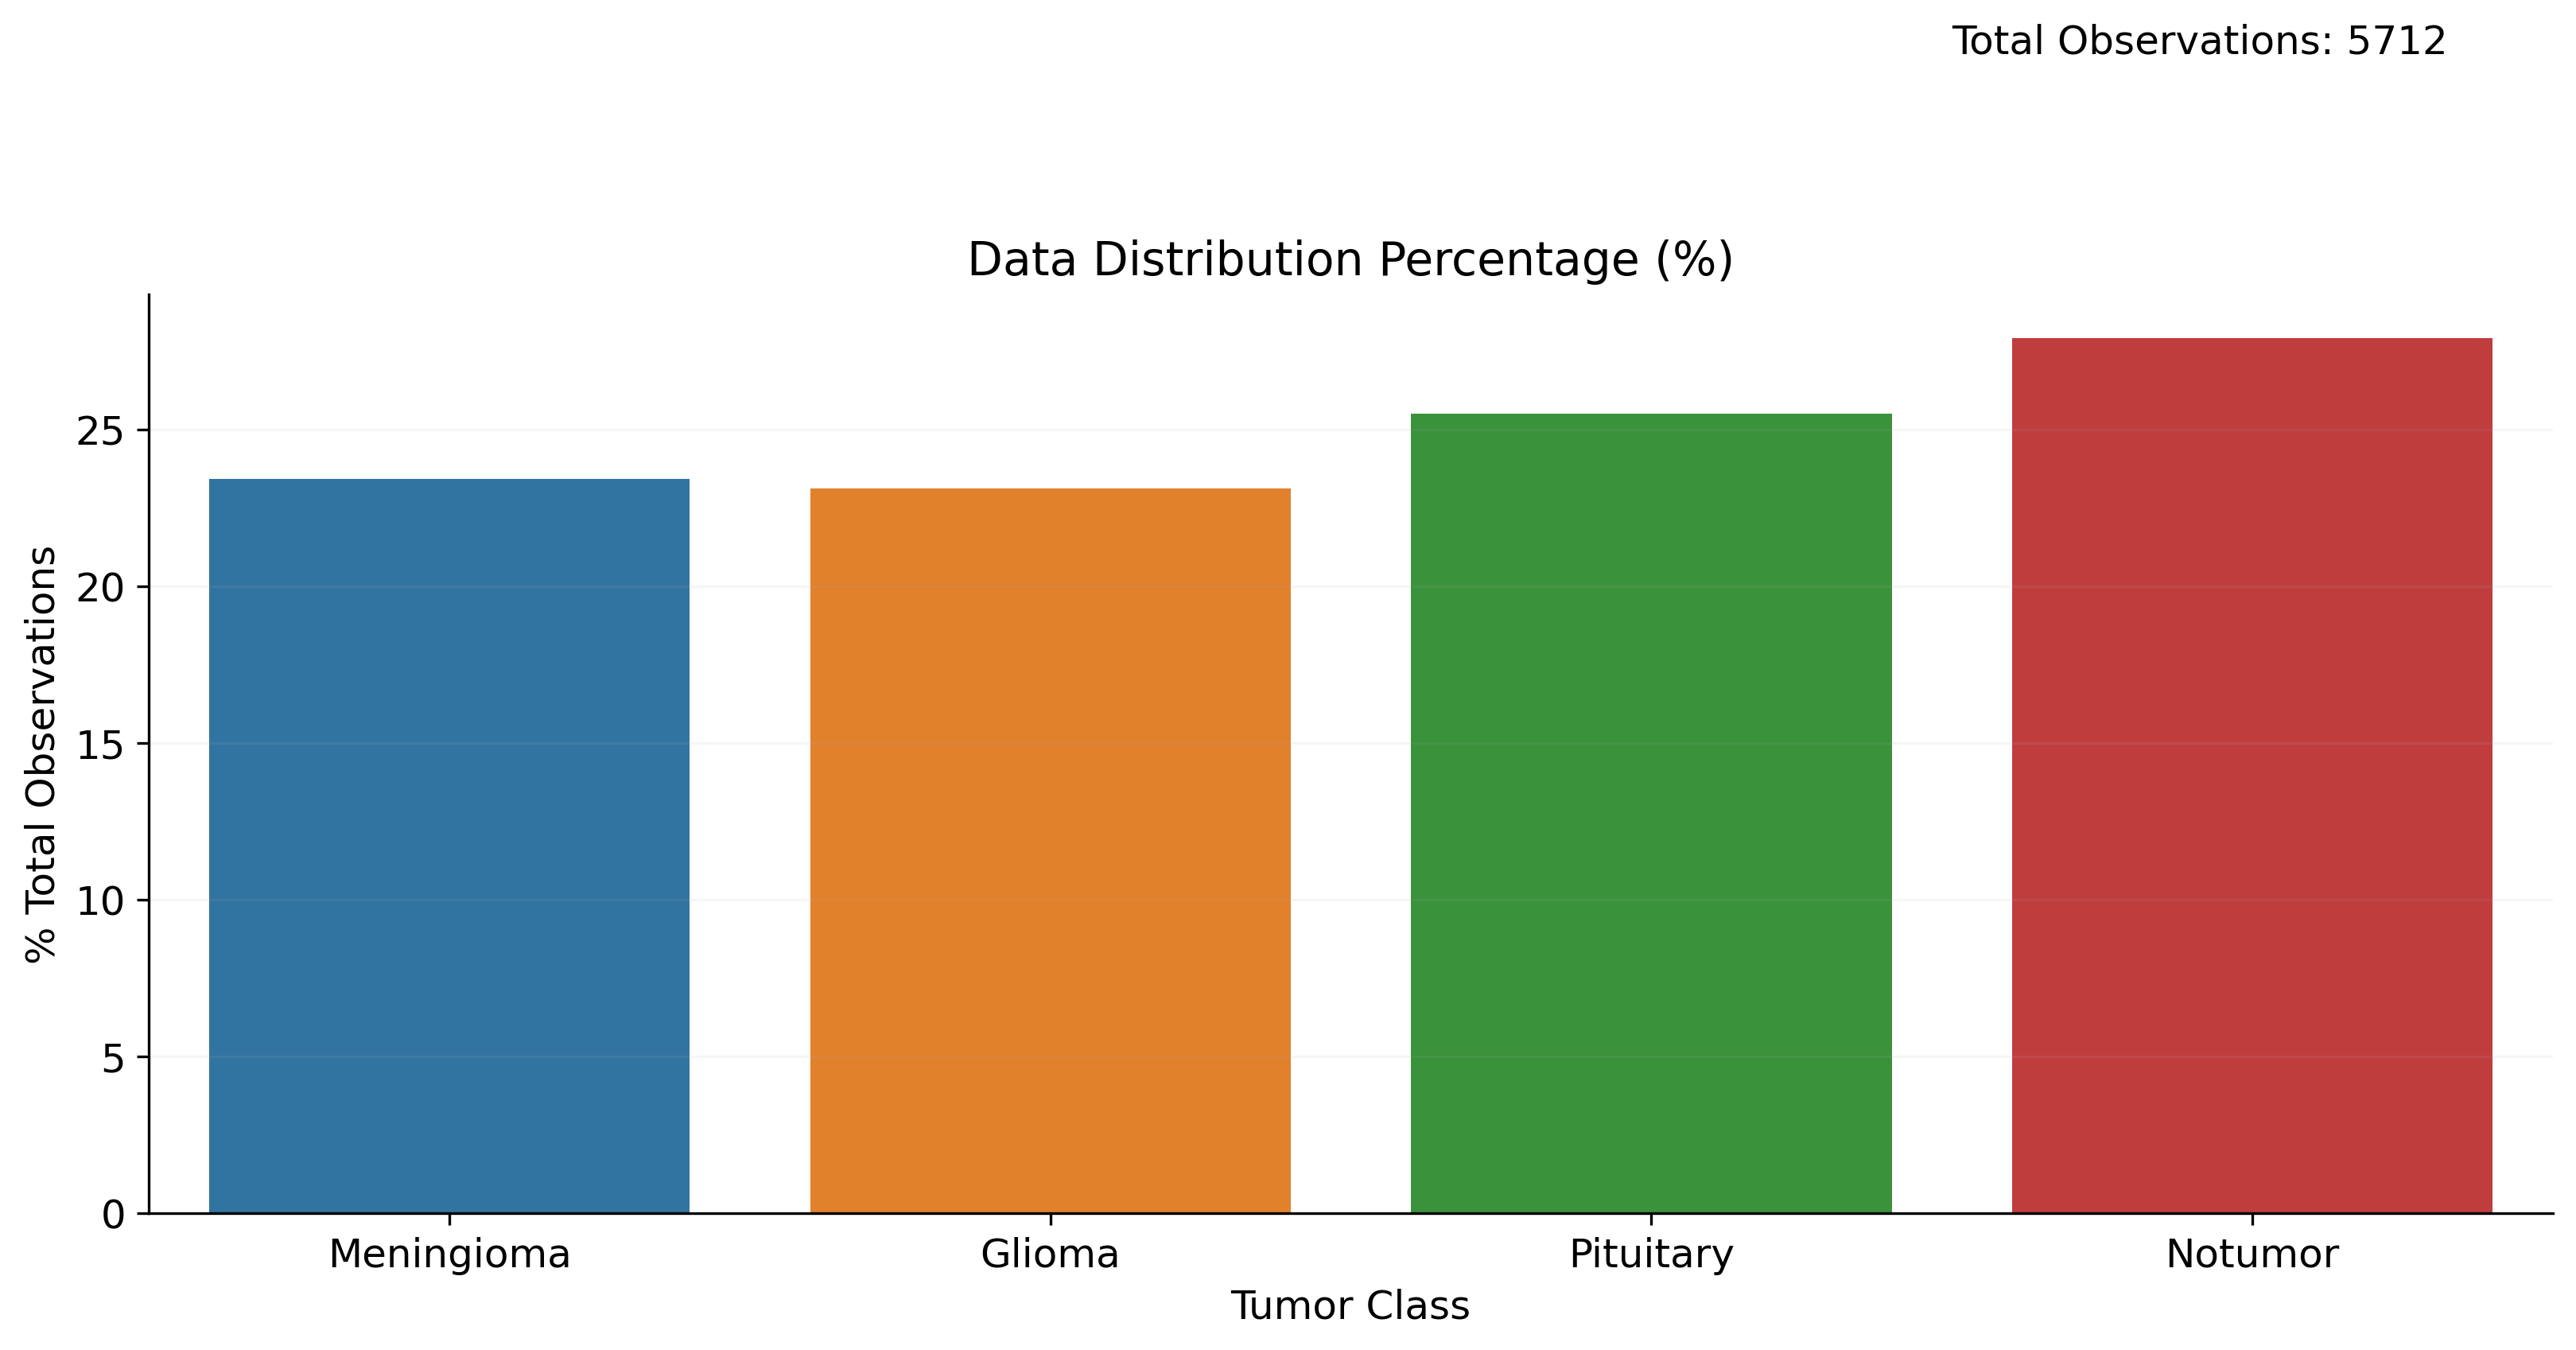

In [16]:
fig, axis = plt.subplots(figsize = (13, 5))
axis.grid(True, alpha = 0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize = 14)
sns.barplot(x = ['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y = 100 * (data_distribution_count / data_distribution_count.sum()), ax = axis)
axis.set_xlabel("Tumor Class", fontsize = 12)
axis.set_ylabel("% Total Observations", fontsize = 12)
axis.tick_params(which = 'major', labelsize = 12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict = dict(size = 12))
sns.despine()

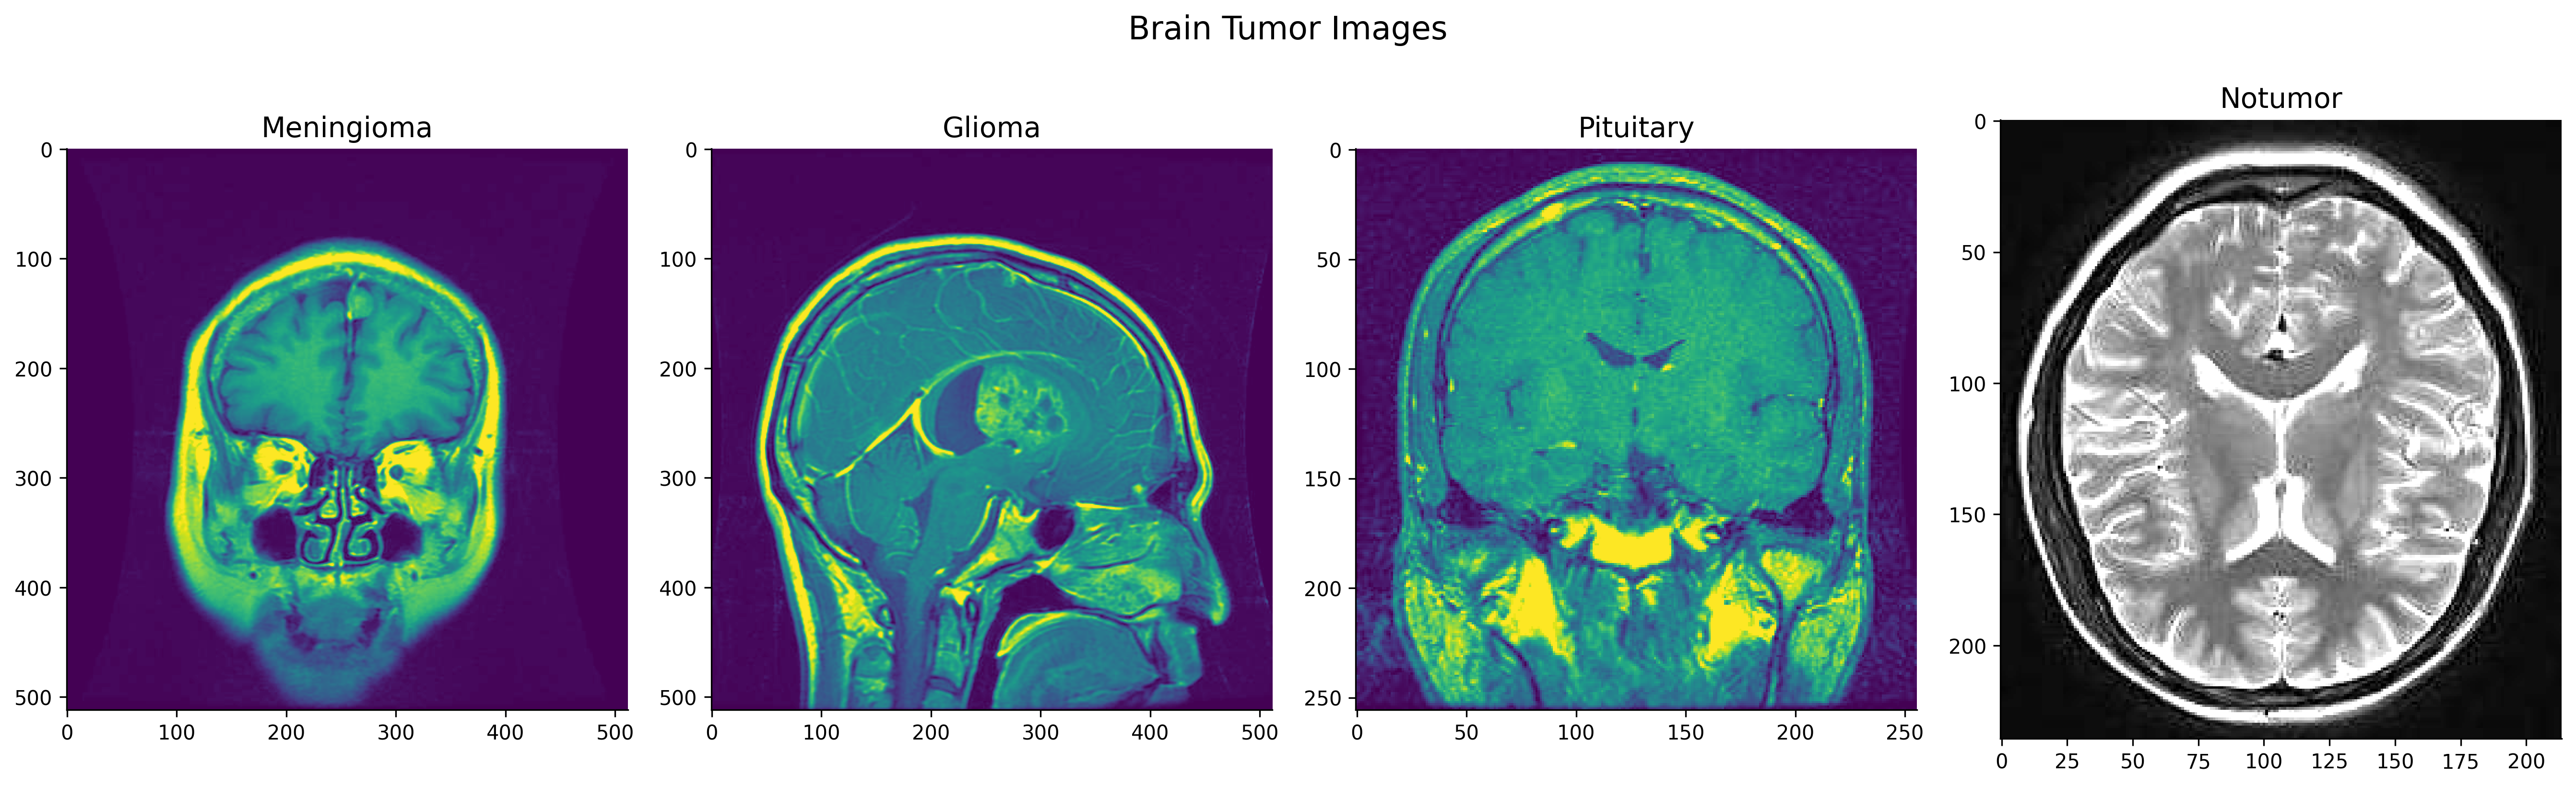

In [17]:
BRIGHTNESS_FACTOR = 1.7
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 5))
axes = axes.flatten()
fig.suptitle("Brain Tumor Images", fontsize = 16, fontdict = dict(weight = 'bold'), y = 1.04)
for curr_title, filename, curr_axis in zip(TUMOR_CLASS, IMAGE_DATA_PATHS, axes[:4]):
    curr_image = Image.open(os.path.join(filename, os.listdir(filename)[2]))
    img_enhancer = ImageEnhance.Brightness(curr_image)
    curr_axis.imshow(img_enhancer.enhance(BRIGHTNESS_FACTOR))
    curr_axis.set_title(" ".join(curr_title.split('_')).title(), fontsize = 14)

fig.tight_layout()
sns.despine()

## Image Augmentation

In [18]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [19]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 1. Inception V3

In [21]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# base_model1 = InceptionV3(
#                     input_shape=(224, 224, 3),
#                     weights='imagenet',
#                     include_top=False)
# # Freeze the first 10 layers
# for layer in base_model1.layers[:10]:
#     layer.trainable = False
# x = base_model1.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.4)(x)
# predictions1 = Dense(4, activation='softmax')(x)
# model1 = Model(inputs=base_model1.inputs, outputs=predictions1)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [22]:

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    base_model1 = InceptionV3(
                    input_shape=(224, 224, 3),
                    weights='imagenet',
                    include_top=False) # define your model normally
    for layer in base_model1.layers[:10]:
        layer.trainable = False
    x = base_model1.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions1 = Dense(4, activation='softmax')(x)
    model1 = Model(inputs=base_model1.inputs, outputs=predictions1)
    model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])



87910968/87910968 [==============================] - 0s 0us/step


In [23]:
# model1.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [24]:
history1=model1.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model1.save('model1.h5')

Epoch 1/25


2023-08-06 04:31:01.687690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:31:02.557308: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.6064 - accuracy: 0.7934

2023-08-06 04:32:35.534933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:32:35.827735: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 151s 2s/step - loss: 0.6064 - accuracy: 0.7934 - val_loss: 49.8047 - val_accuracy: 0.2084
Epoch 2/25
36/36 [==============================] - 5s 129ms/step - loss: 0.2304 - accuracy: 0.9236 - val_loss: 6.3624 - val_accuracy: 0.2513
Epoch 3/25
36/36 [==============================] - 4s 111ms/step - loss: 0.1266 - accuracy: 0.9613 - val_loss: 4.2380 - val_accuracy: 0.2294
Epoch 4/25
36/36 [==============================] - 4s 110ms/step - loss: 0.1428 - accuracy: 0.9554 - val_loss: 4.2080 - val_accuracy: 0.3897
Epoch 5/25
36/36 [==============================] - 4s 113ms/step - loss: 0.0972 - accuracy: 0.9632 - val_loss: 0.7488 - val_accuracy: 0.8187
Epoch 6/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0388 - accuracy: 0.9842 - val_loss: 0.1912 - val_accuracy: 0.9440
Epoch 7/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0608 - accuracy: 0.9803 - val_loss: 0.5411 - val_accuracy: 0.8573
Epoch 8/25
36/36 

In [25]:
inceptionv3_evaluation = model1.evaluate(val_ds)
inceptionv3_evaluation[1]*100

11/11 [==============================] - 15s 1s/step - loss: 0.0773 - accuracy: 0.9779


97.78794646263123

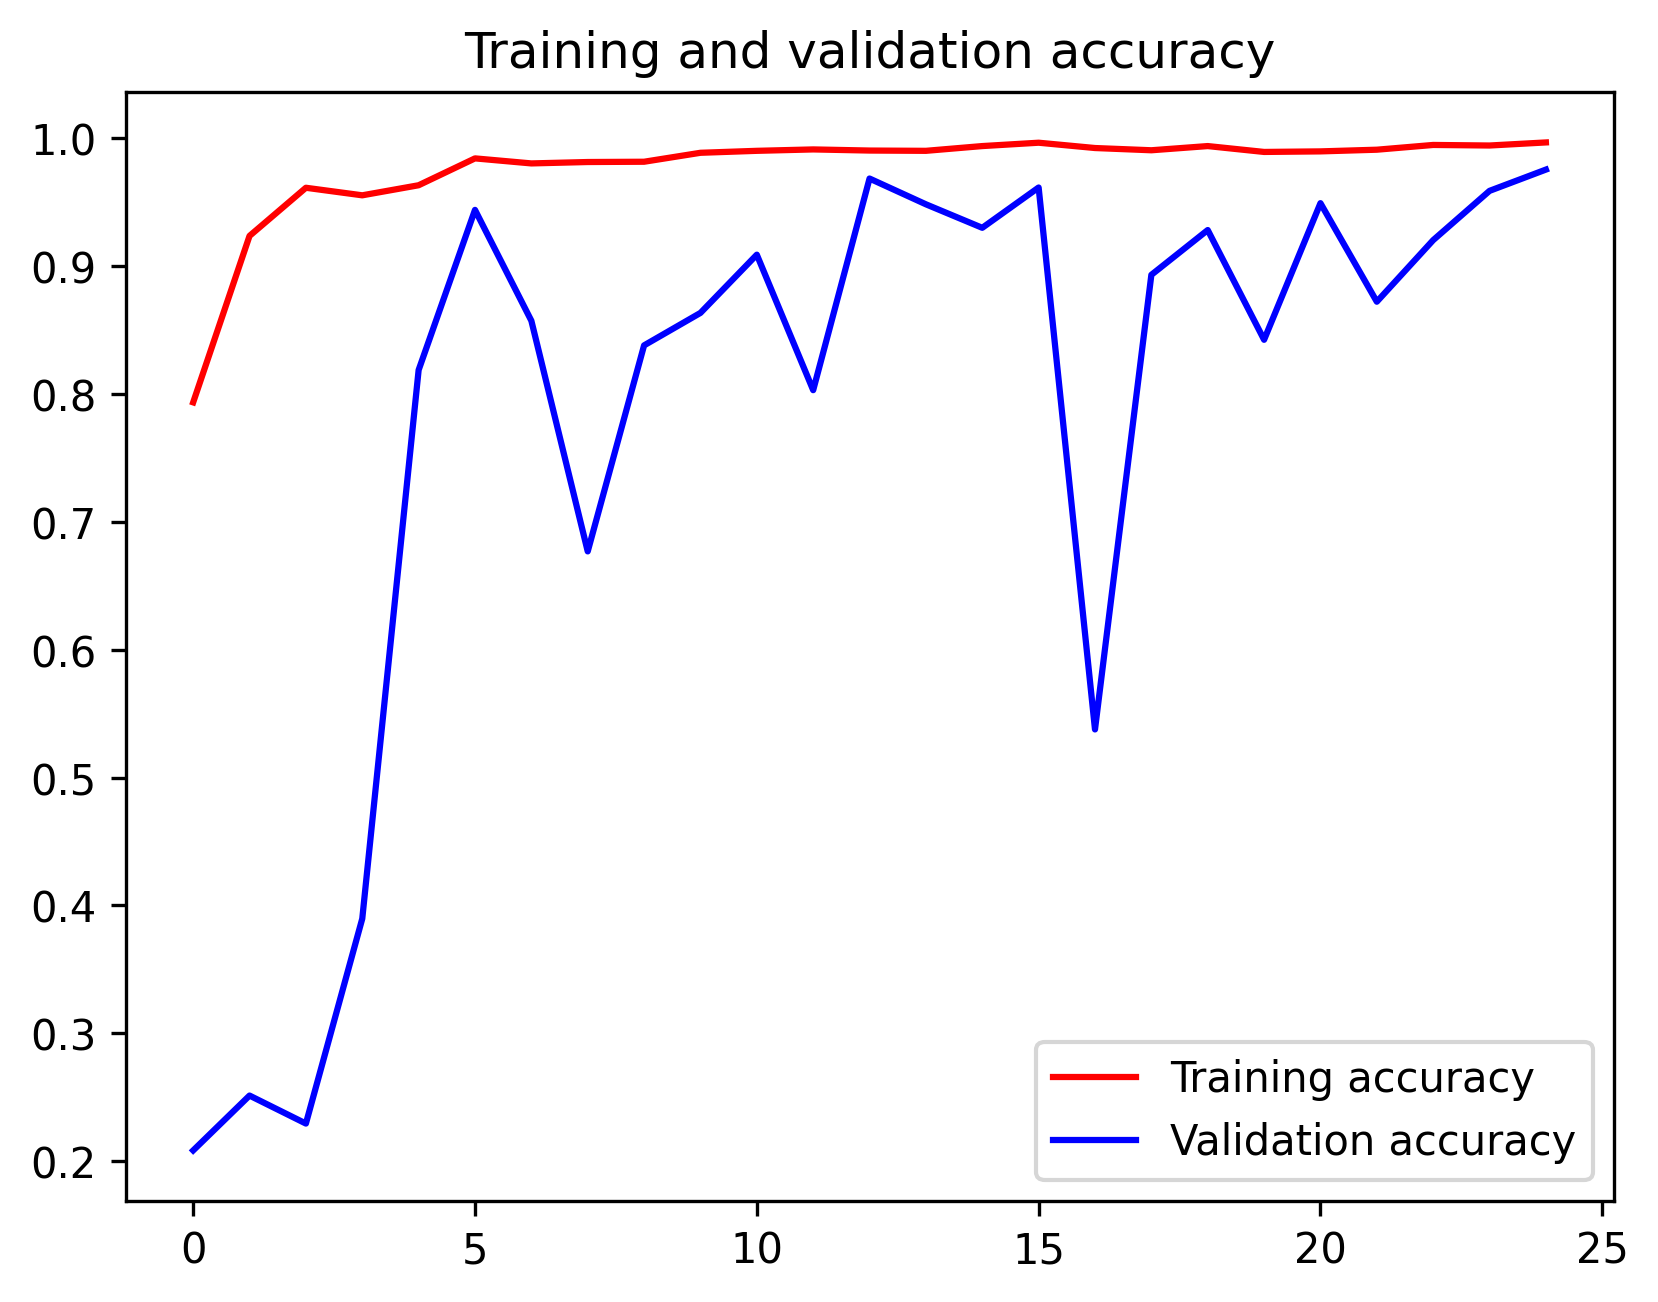

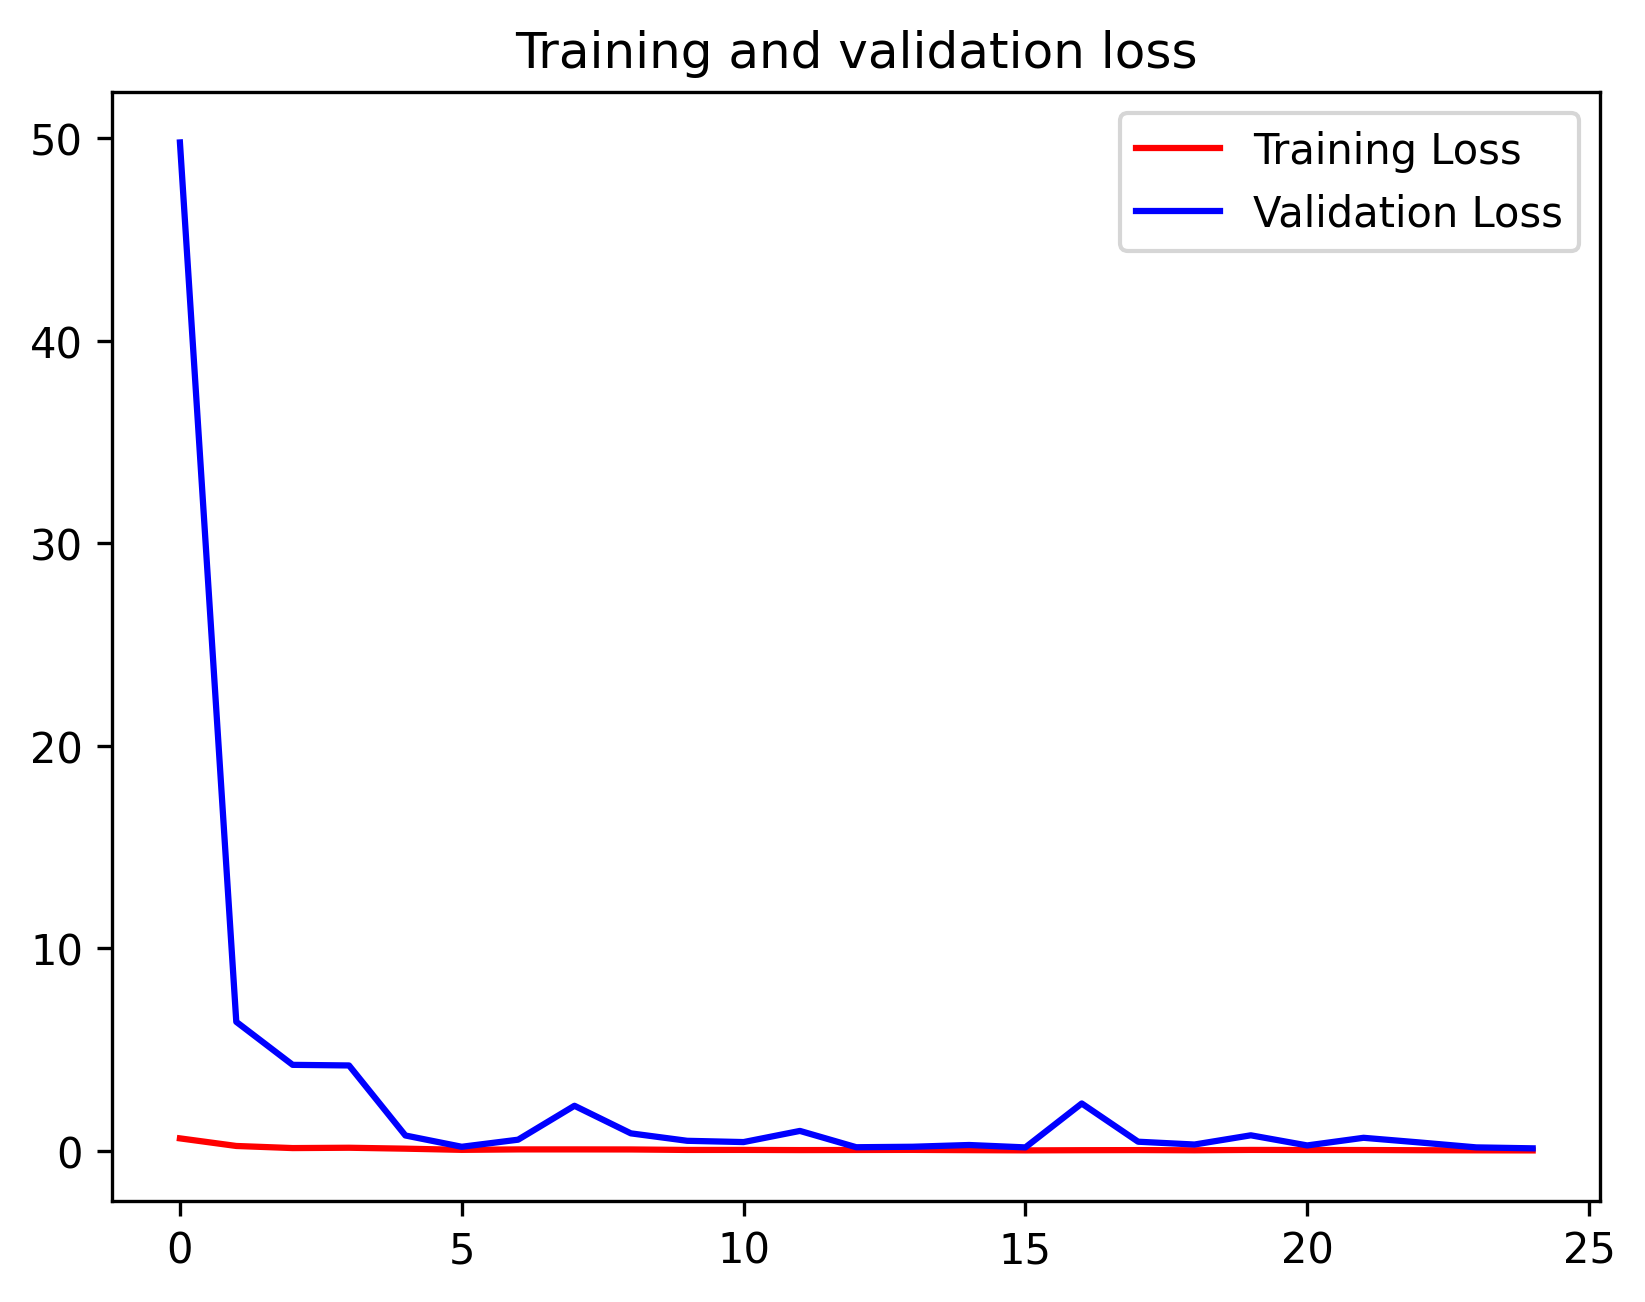

In [26]:
import matplotlib.pyplot as plt
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 04:35:16.152376: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:35:16.323534: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 17ms/step


2023-08-06 04:35:38.488305: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:35:38.718933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 17s 17s/step
              precision    recall  f1-score   support

  meningioma       0.99      0.97      0.98       300
      glioma       0.97      0.95      0.96       306
   pituitary       0.98      1.00      0.99       405
     notumor       0.97      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



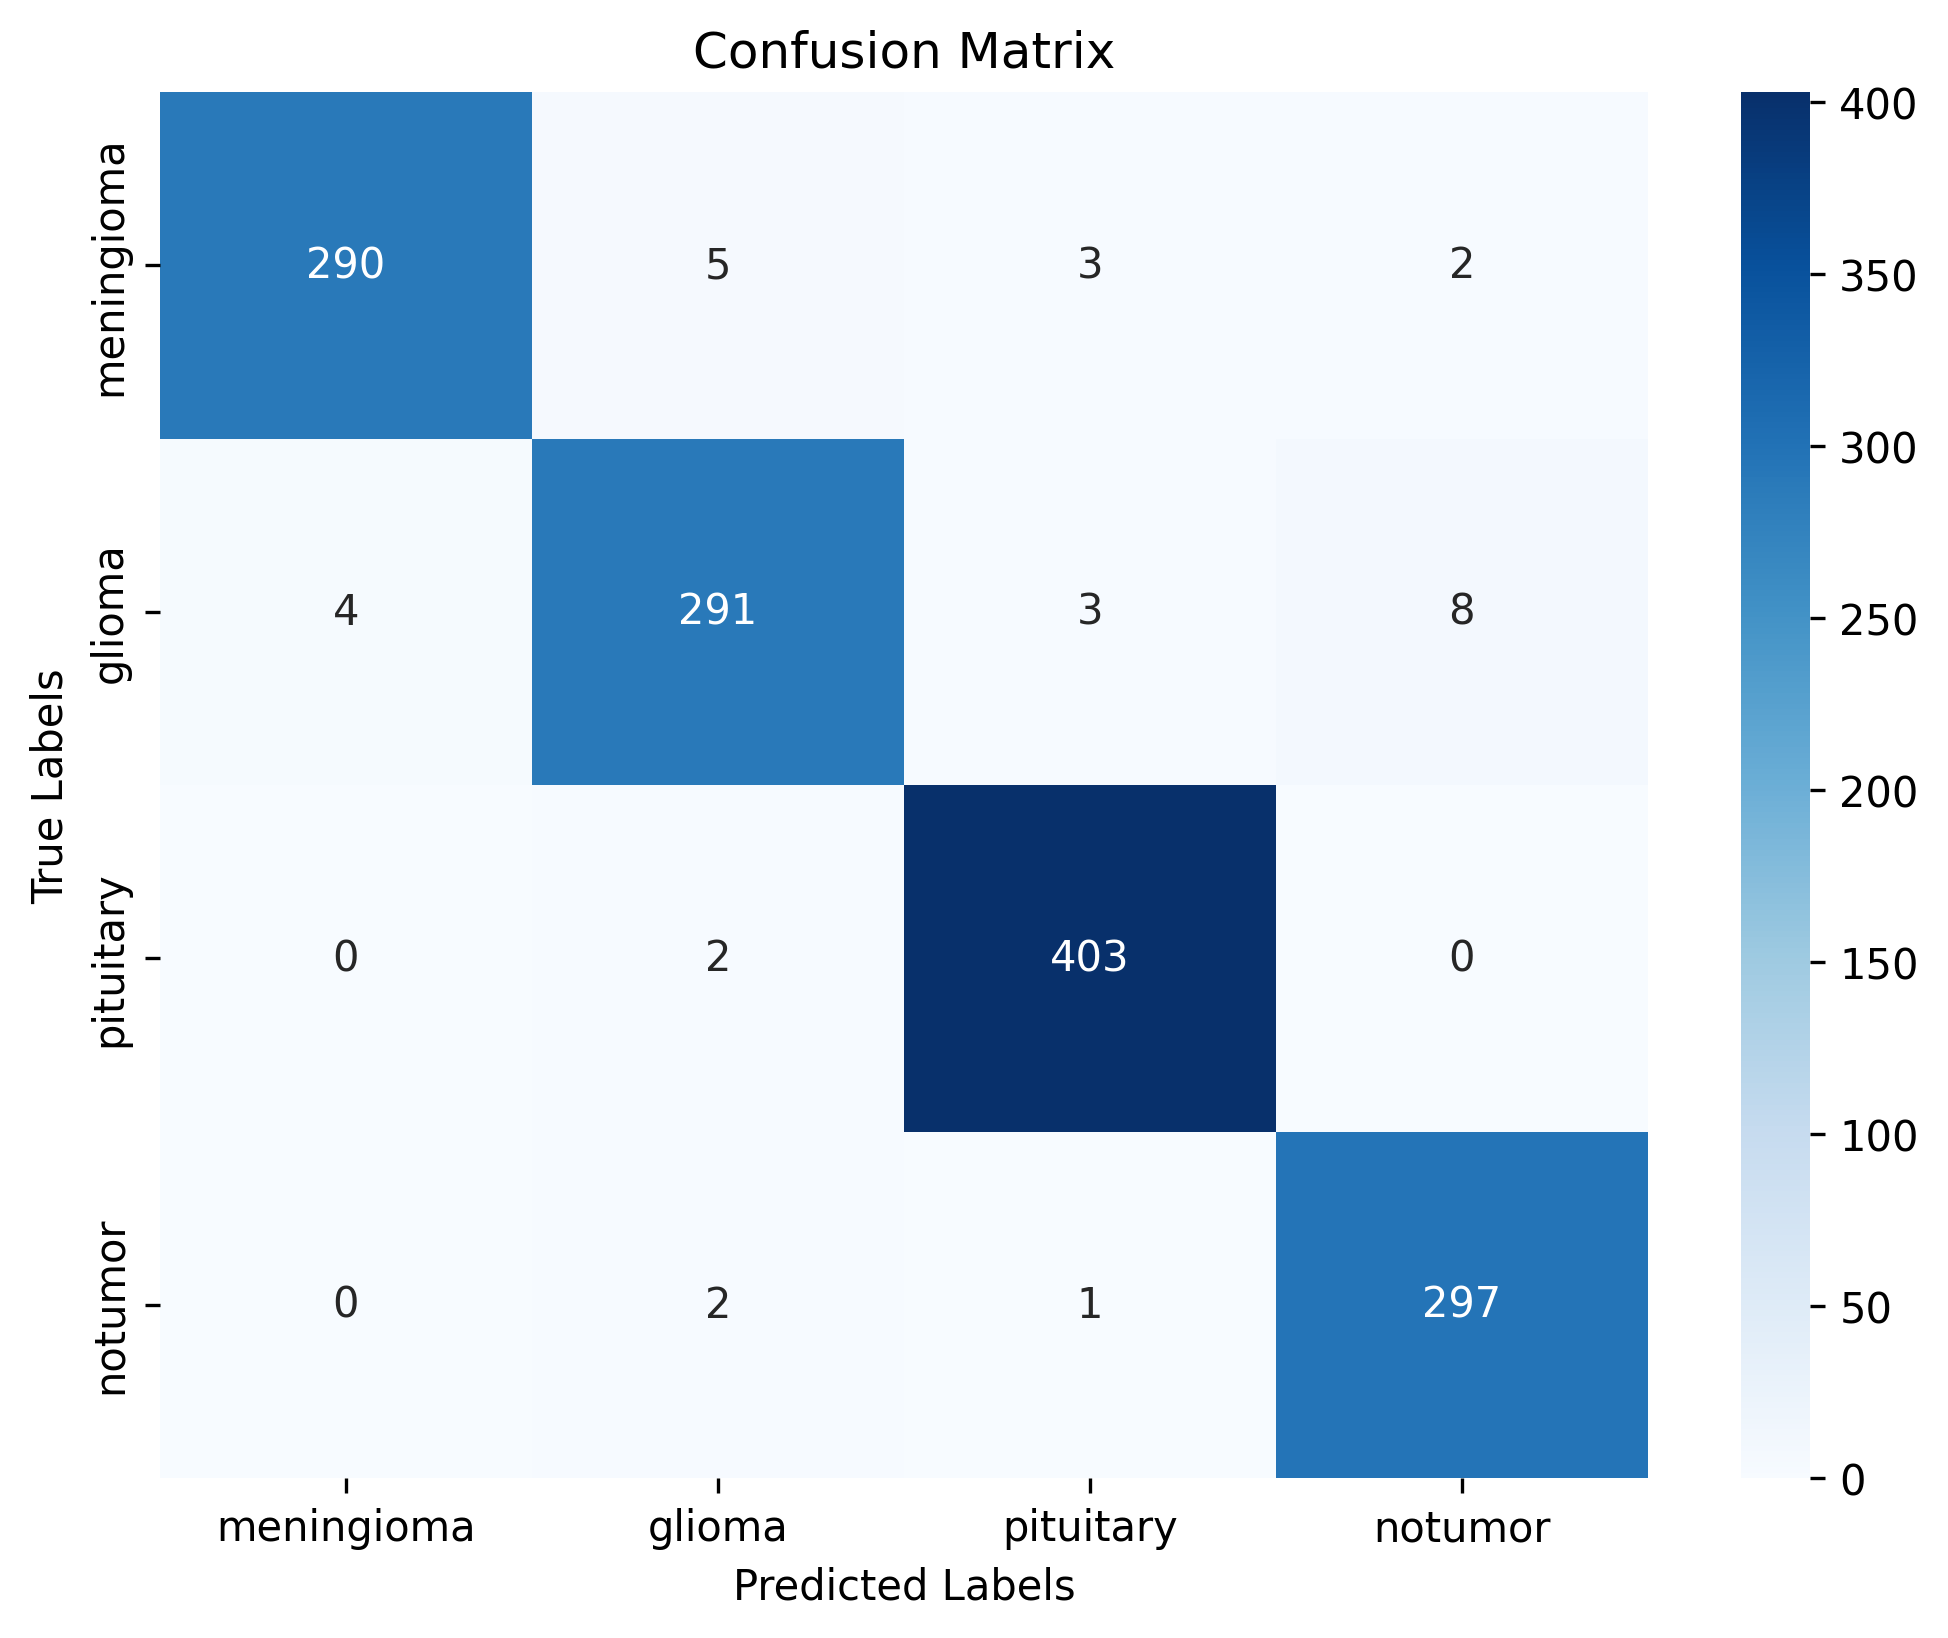

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model1.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 2. VGG16

In [28]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

with tpu_strategy.scope():
    base_model2 = VGG16(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model2.layers:
        layer.trainable = False
    x = base_model2.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions2 = Dense(4, activation='softmax')(x)
    model2 = Model(inputs=base_model2.inputs, outputs=predictions2)
    model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [29]:
# model2.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [30]:
history2=model2.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model2.save('model2.h5')

Epoch 1/25


2023-08-06 04:36:01.834883: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:36:01.956486: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 1.2185 - accuracy: 0.7477

2023-08-06 04:36:20.026145: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:36:20.140454: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 33s 675ms/step - loss: 1.2185 - accuracy: 0.7477 - val_loss: 0.5274 - val_accuracy: 0.8634
Epoch 2/25
36/36 [==============================] - 3s 82ms/step - loss: 0.4382 - accuracy: 0.8621 - val_loss: 0.2938 - val_accuracy: 0.9072
Epoch 3/25
36/36 [==============================] - 3s 82ms/step - loss: 0.2693 - accuracy: 0.9055 - val_loss: 0.2456 - val_accuracy: 0.9124
Epoch 4/25
36/36 [==============================] - 3s 83ms/step - loss: 0.2355 - accuracy: 0.9149 - val_loss: 0.2354 - val_accuracy: 0.9177
Epoch 5/25
36/36 [==============================] - 3s 80ms/step - loss: 0.1952 - accuracy: 0.9265 - val_loss: 0.2036 - val_accuracy: 0.9361
Epoch 6/25
36/36 [==============================] - 3s 82ms/step - loss: 0.1684 - accuracy: 0.9411 - val_loss: 0.1957 - val_accuracy: 0.9361
Epoch 7/25
36/36 [==============================] - 3s 82ms/step - loss: 0.1367 - accuracy: 0.9527 - val_loss: 0.1867 - val_accuracy: 0.9422
Epoch 8/25
36/36 [====

In [31]:
vgg16_evaluation = model2.evaluate(val_ds)
vgg16_evaluation[1]*100

11/11 [==============================] - 8s 736ms/step - loss: 0.1485 - accuracy: 0.9558


95.57589888572693

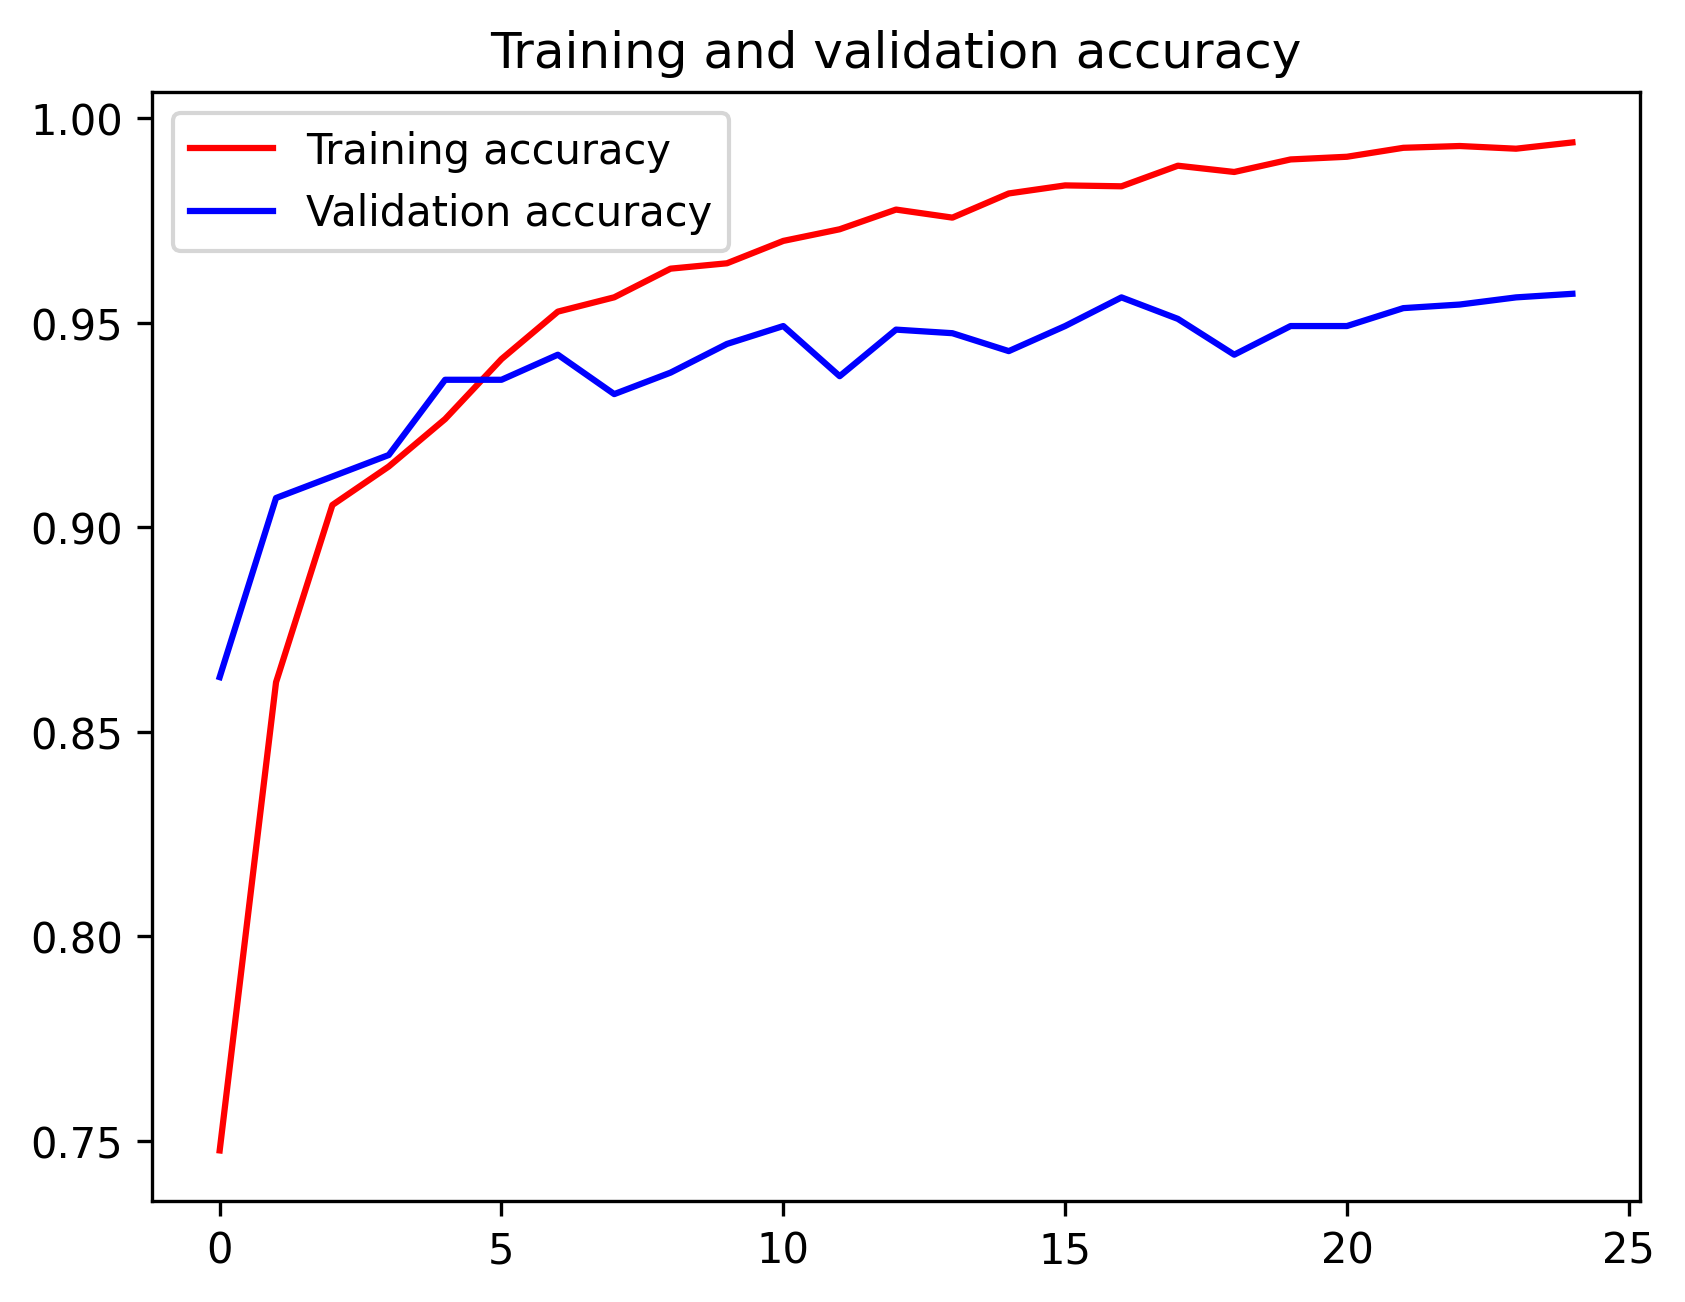

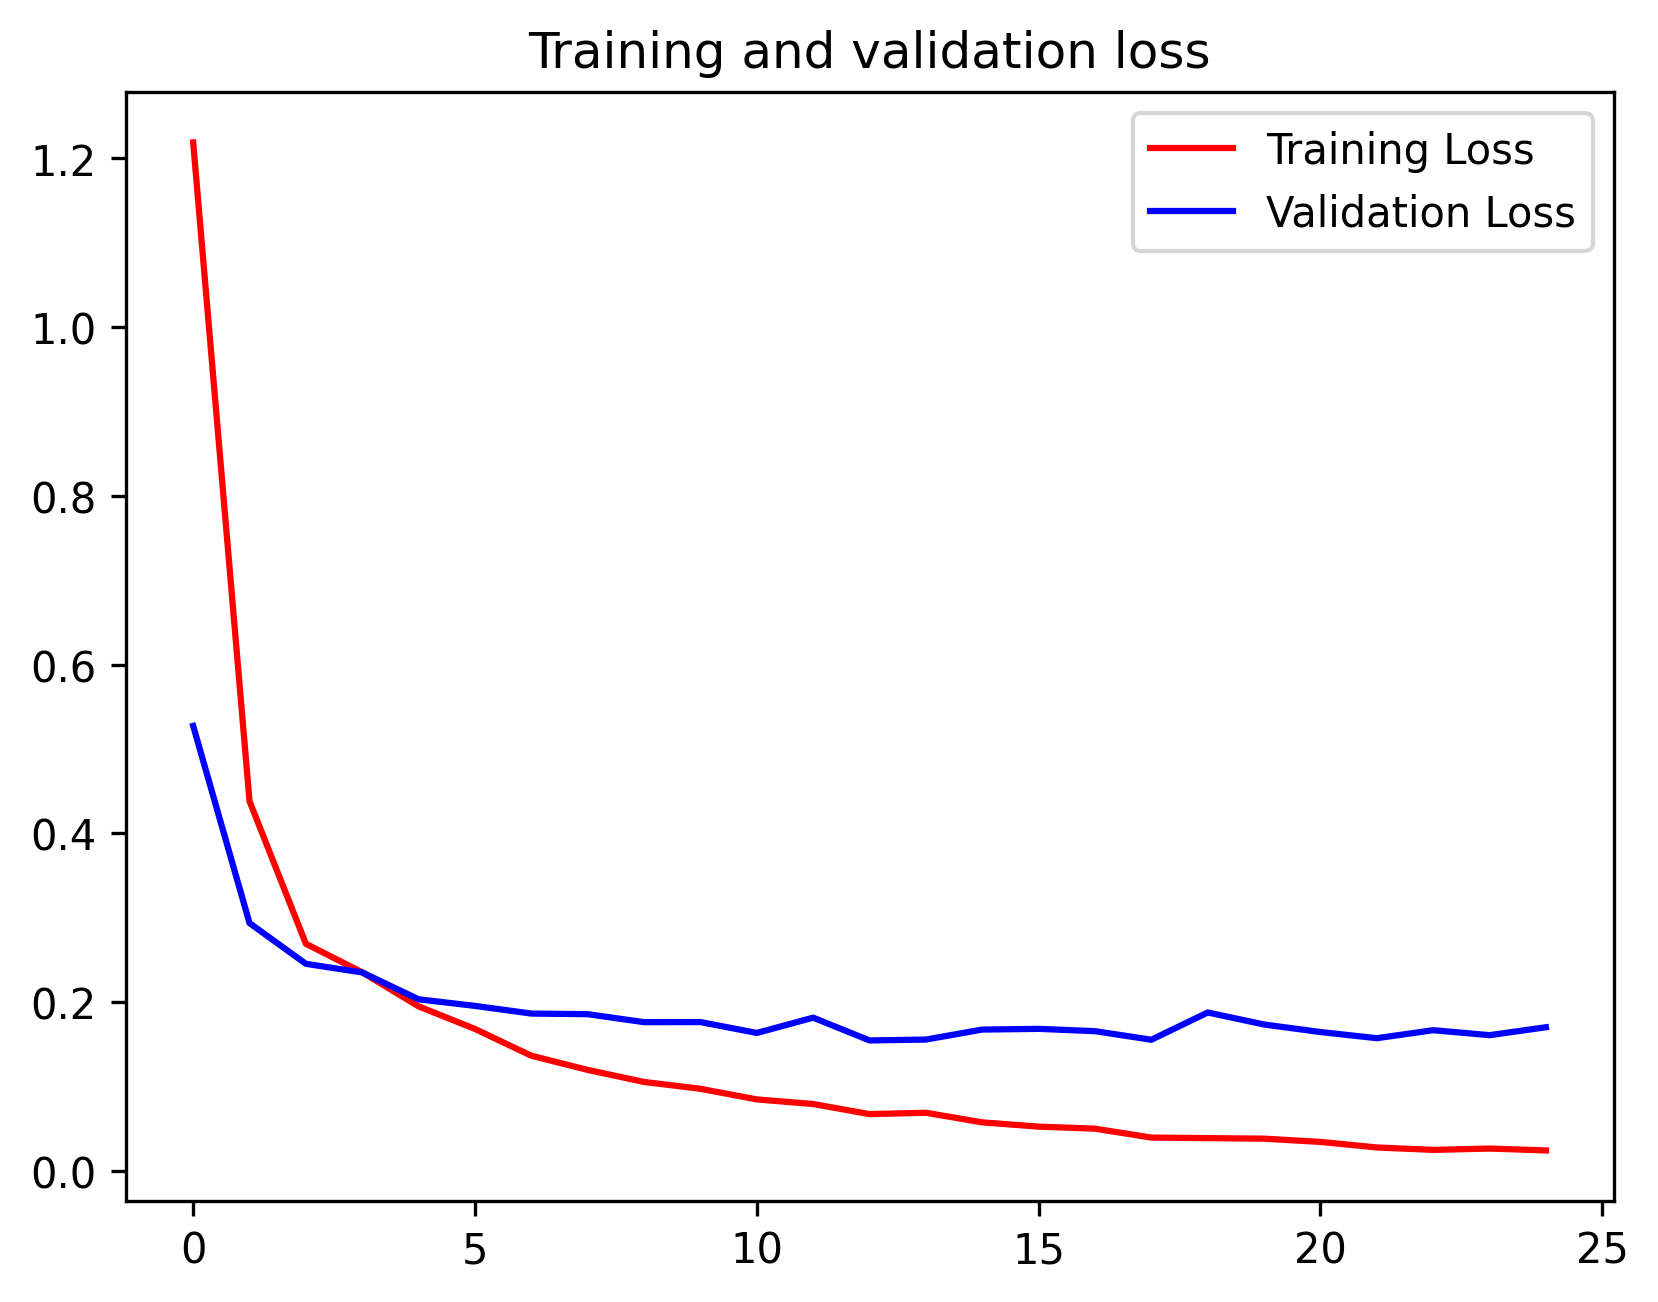

In [32]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 04:38:07.629911: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:38:07.652996: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 11ms/step


2023-08-06 04:38:21.494092: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:38:21.578700: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 7s 7s/step
              precision    recall  f1-score   support

  meningioma       0.95      0.95      0.95       300
      glioma       0.93      0.90      0.91       306
   pituitary       0.98      0.98      0.98       405
     notumor       0.96      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



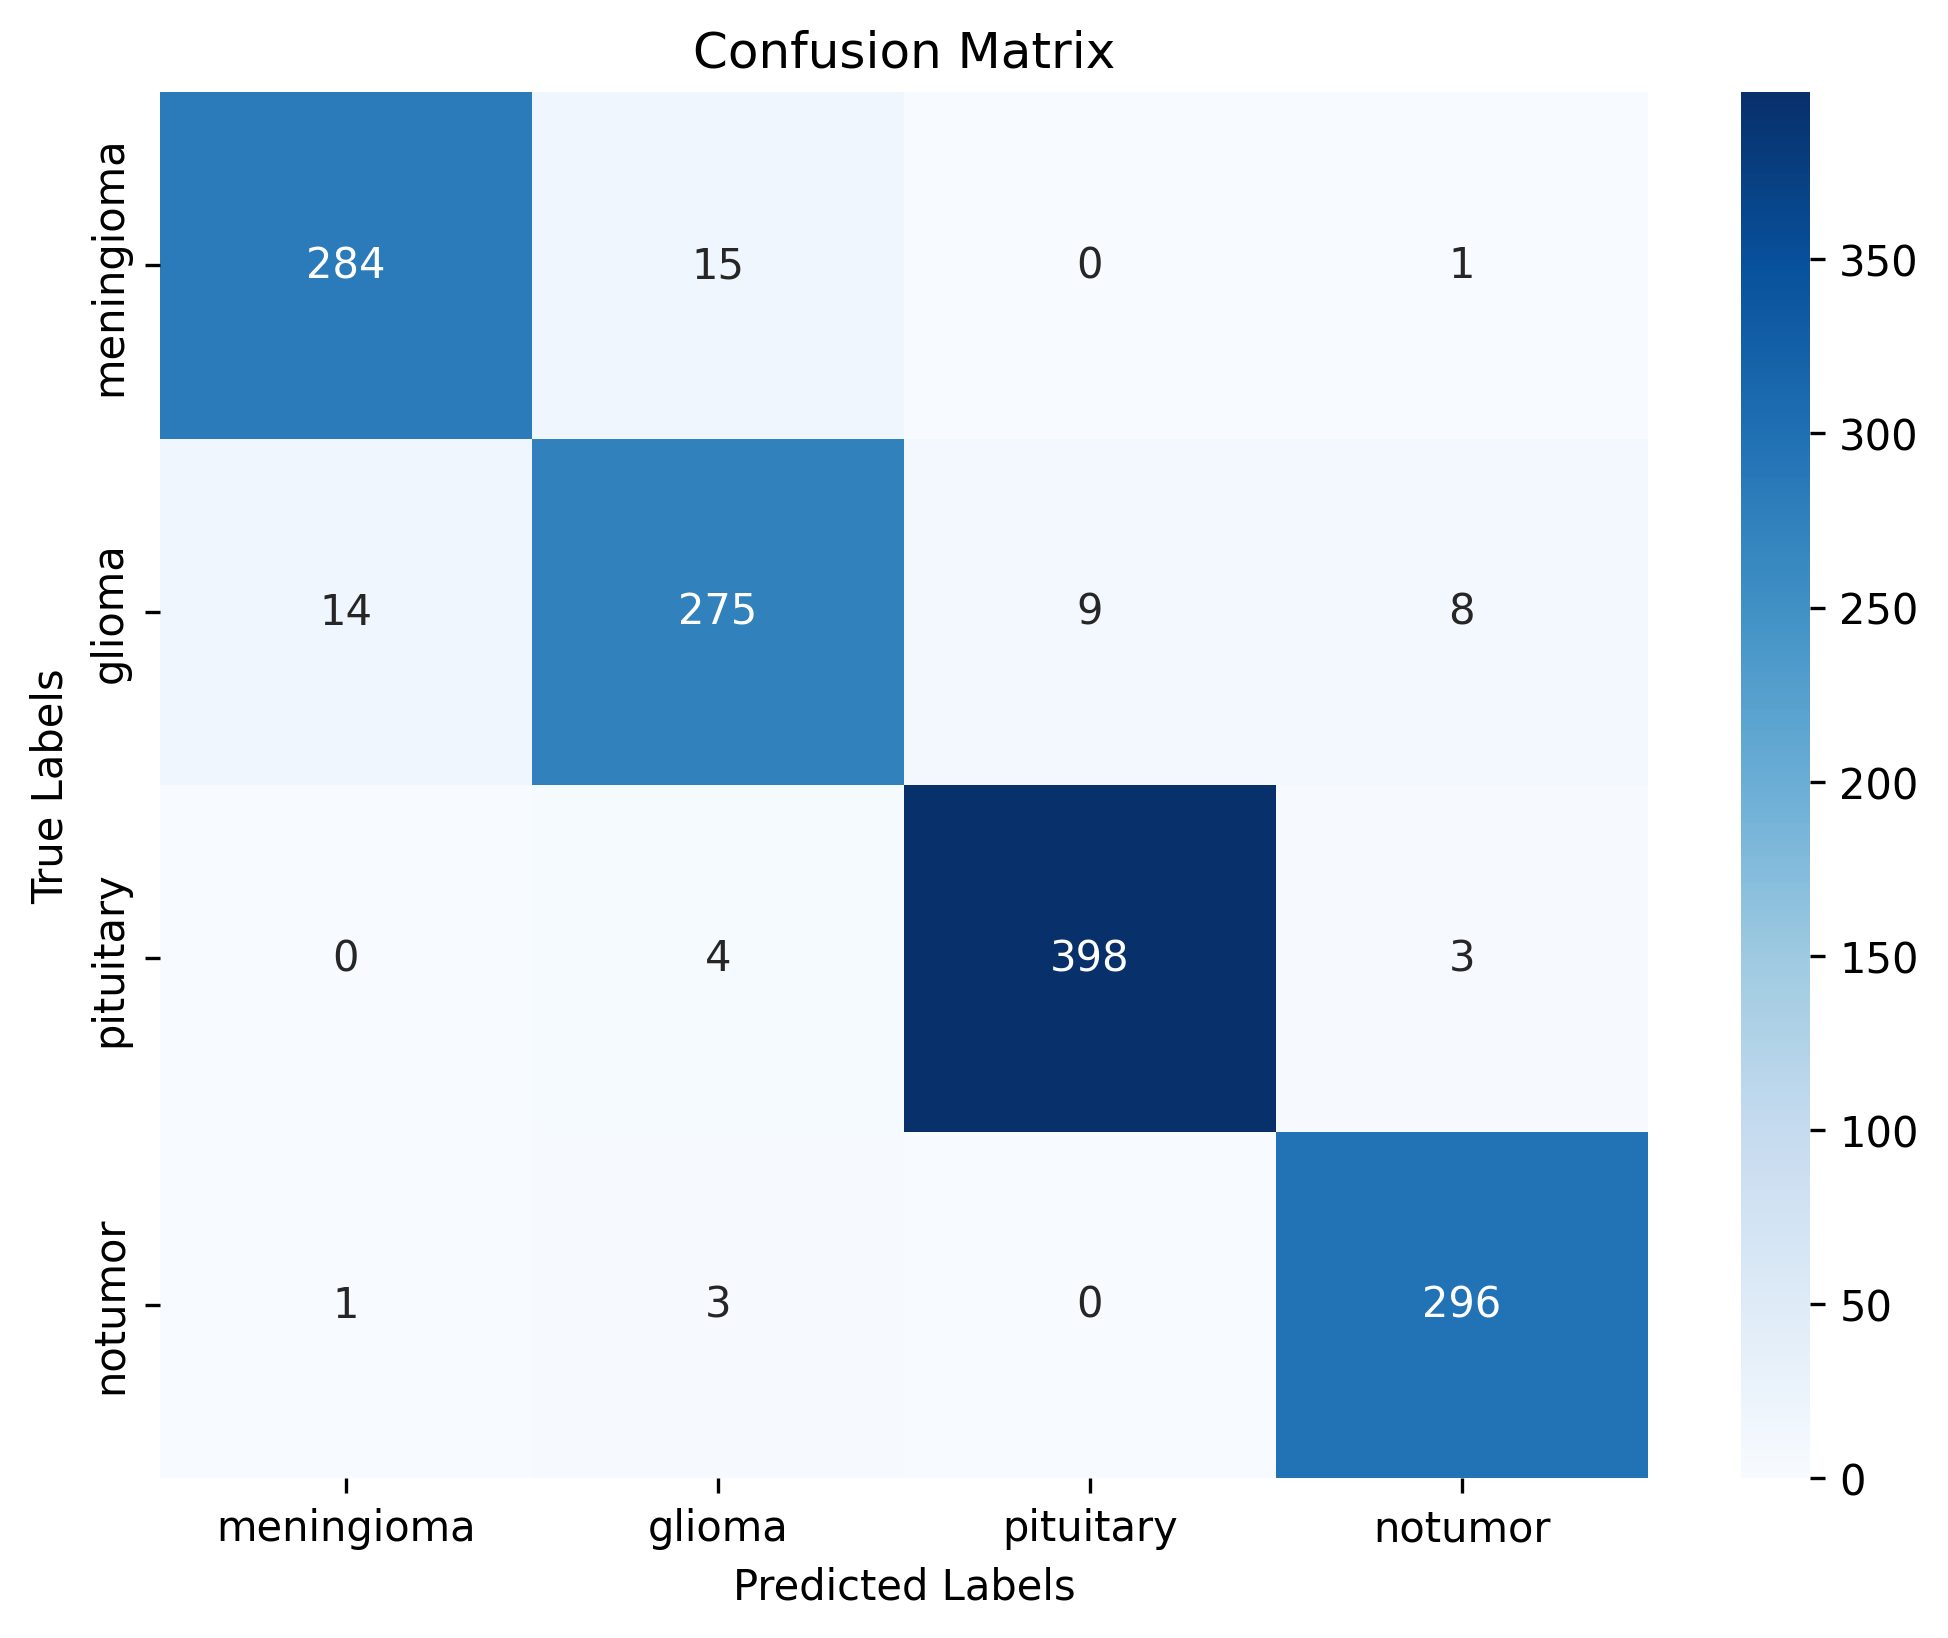

In [33]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model2.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### 3. VGG19

In [34]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D

with tpu_strategy.scope():

    base_model3 = VGG19(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model3.layers[:10]:
        layer.trainable = False
    x = base_model3.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions3 = Dense(4, activation='softmax')(x)
    model3 = Model(inputs=base_model3.inputs, outputs=predictions3)
    model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

80134624/80134624 [==============================] - 0s 0us/step


In [35]:
# model3.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [36]:
history3=model3.fit(
  train_ds,
  validation_data=test_ds,
  epochs=100)

model3.save('model3.h5')

Epoch 1/25


2023-08-06 04:38:35.449626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:38:35.603426: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 3.8638 - accuracy: 0.2816

2023-08-06 04:39:11.107903: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:39:11.217728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 53s 973ms/step - loss: 3.8638 - accuracy: 0.2816 - val_loss: 1.2955 - val_accuracy: 0.2977
Epoch 2/25
36/36 [==============================] - 4s 102ms/step - loss: 1.2754 - accuracy: 0.3838 - val_loss: 1.1685 - val_accuracy: 0.4834
Epoch 3/25
36/36 [==============================] - 4s 101ms/step - loss: 1.0756 - accuracy: 0.5394 - val_loss: 1.0077 - val_accuracy: 0.6173
Epoch 4/25
36/36 [==============================] - 4s 102ms/step - loss: 0.9453 - accuracy: 0.6112 - val_loss: 0.9073 - val_accuracy: 0.6261
Epoch 5/25
36/36 [==============================] - 4s 105ms/step - loss: 0.8438 - accuracy: 0.6514 - val_loss: 0.8409 - val_accuracy: 0.6637
Epoch 6/25
36/36 [==============================] - 4s 101ms/step - loss: 0.7765 - accuracy: 0.6726 - val_loss: 0.7590 - val_accuracy: 0.6594
Epoch 7/25
36/36 [==============================] - 4s 102ms/step - loss: 0.7212 - accuracy: 0.6985 - val_loss: 0.6350 - val_accuracy: 0.7417
Epoch 8/25
36/36

In [37]:
vgg19_evaluation = model3.evaluate(val_ds)
vgg19_evaluation[1]*100

11/11 [==============================] - 8s 736ms/step - loss: 0.4133 - accuracy: 0.8444


84.43936109542847

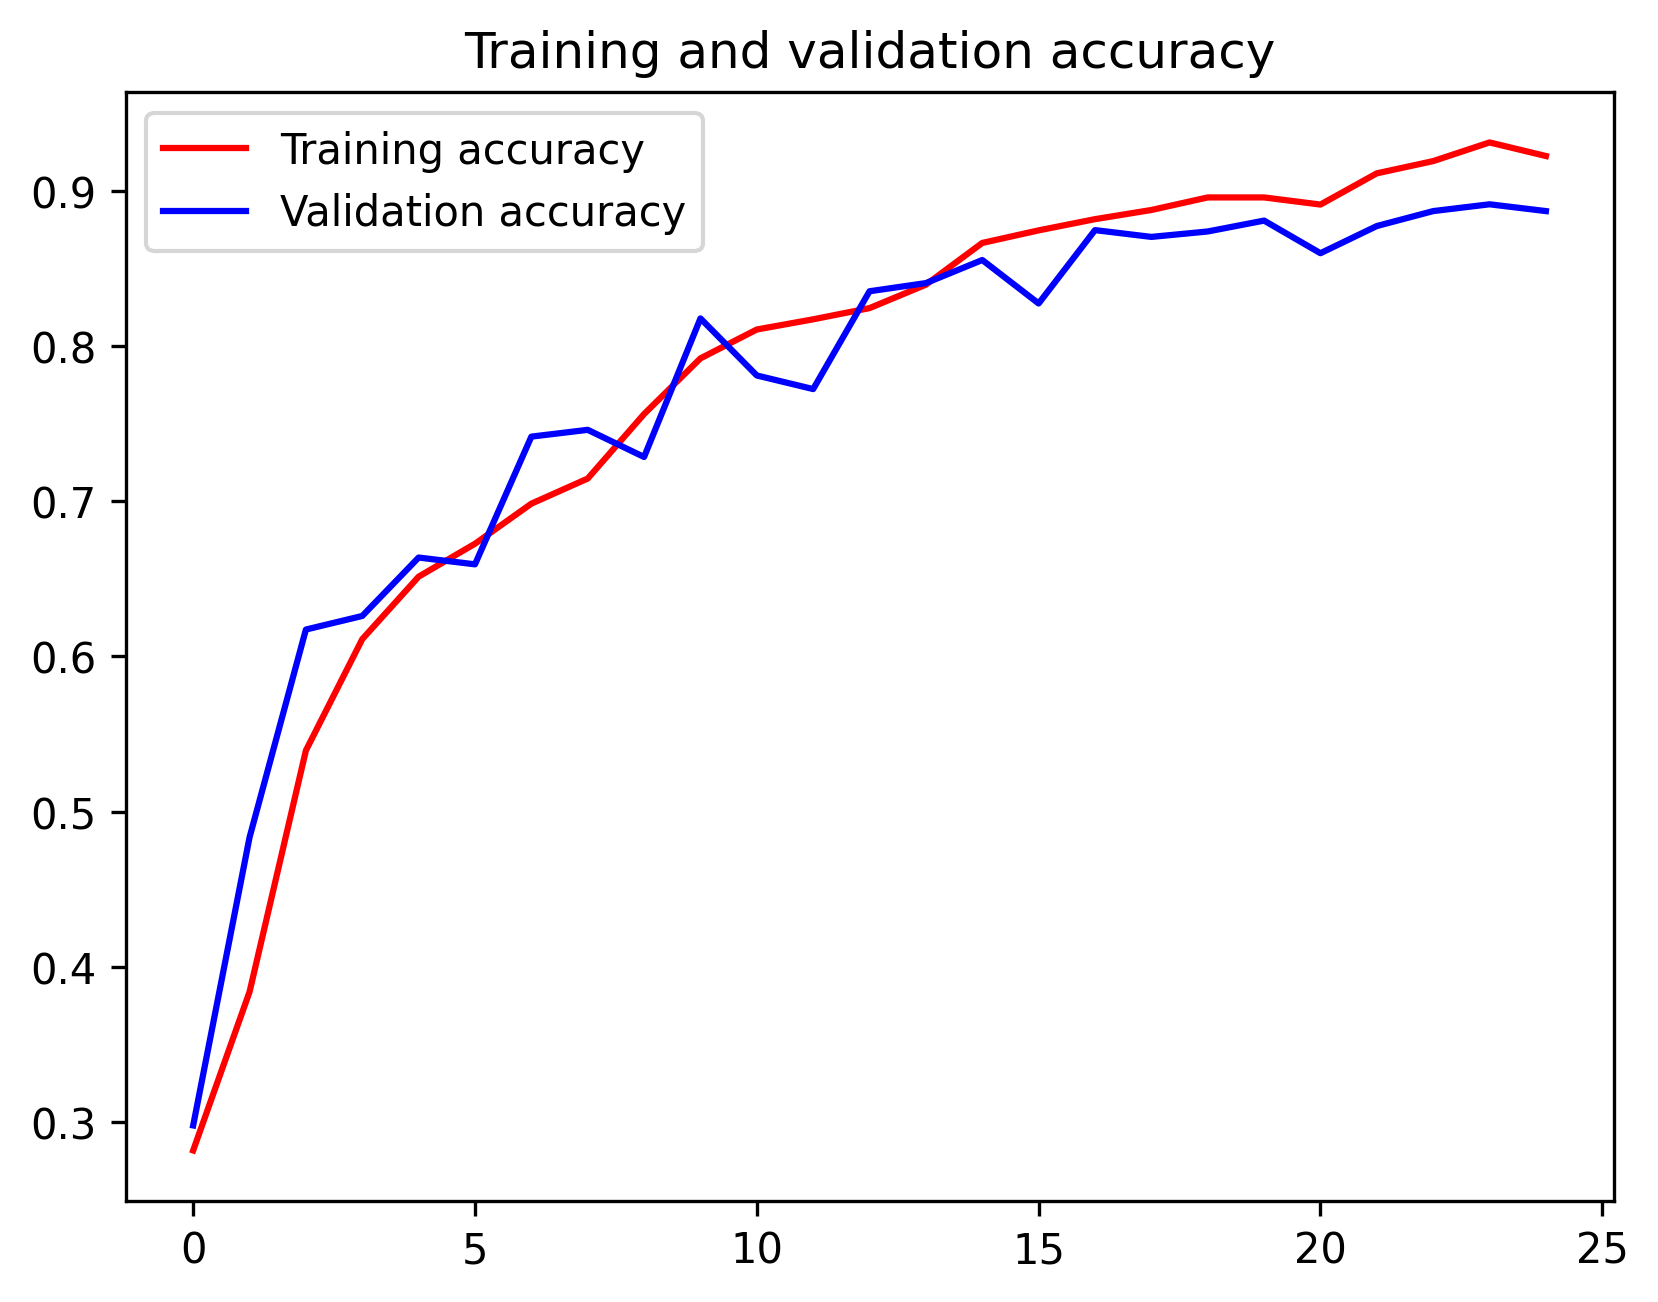

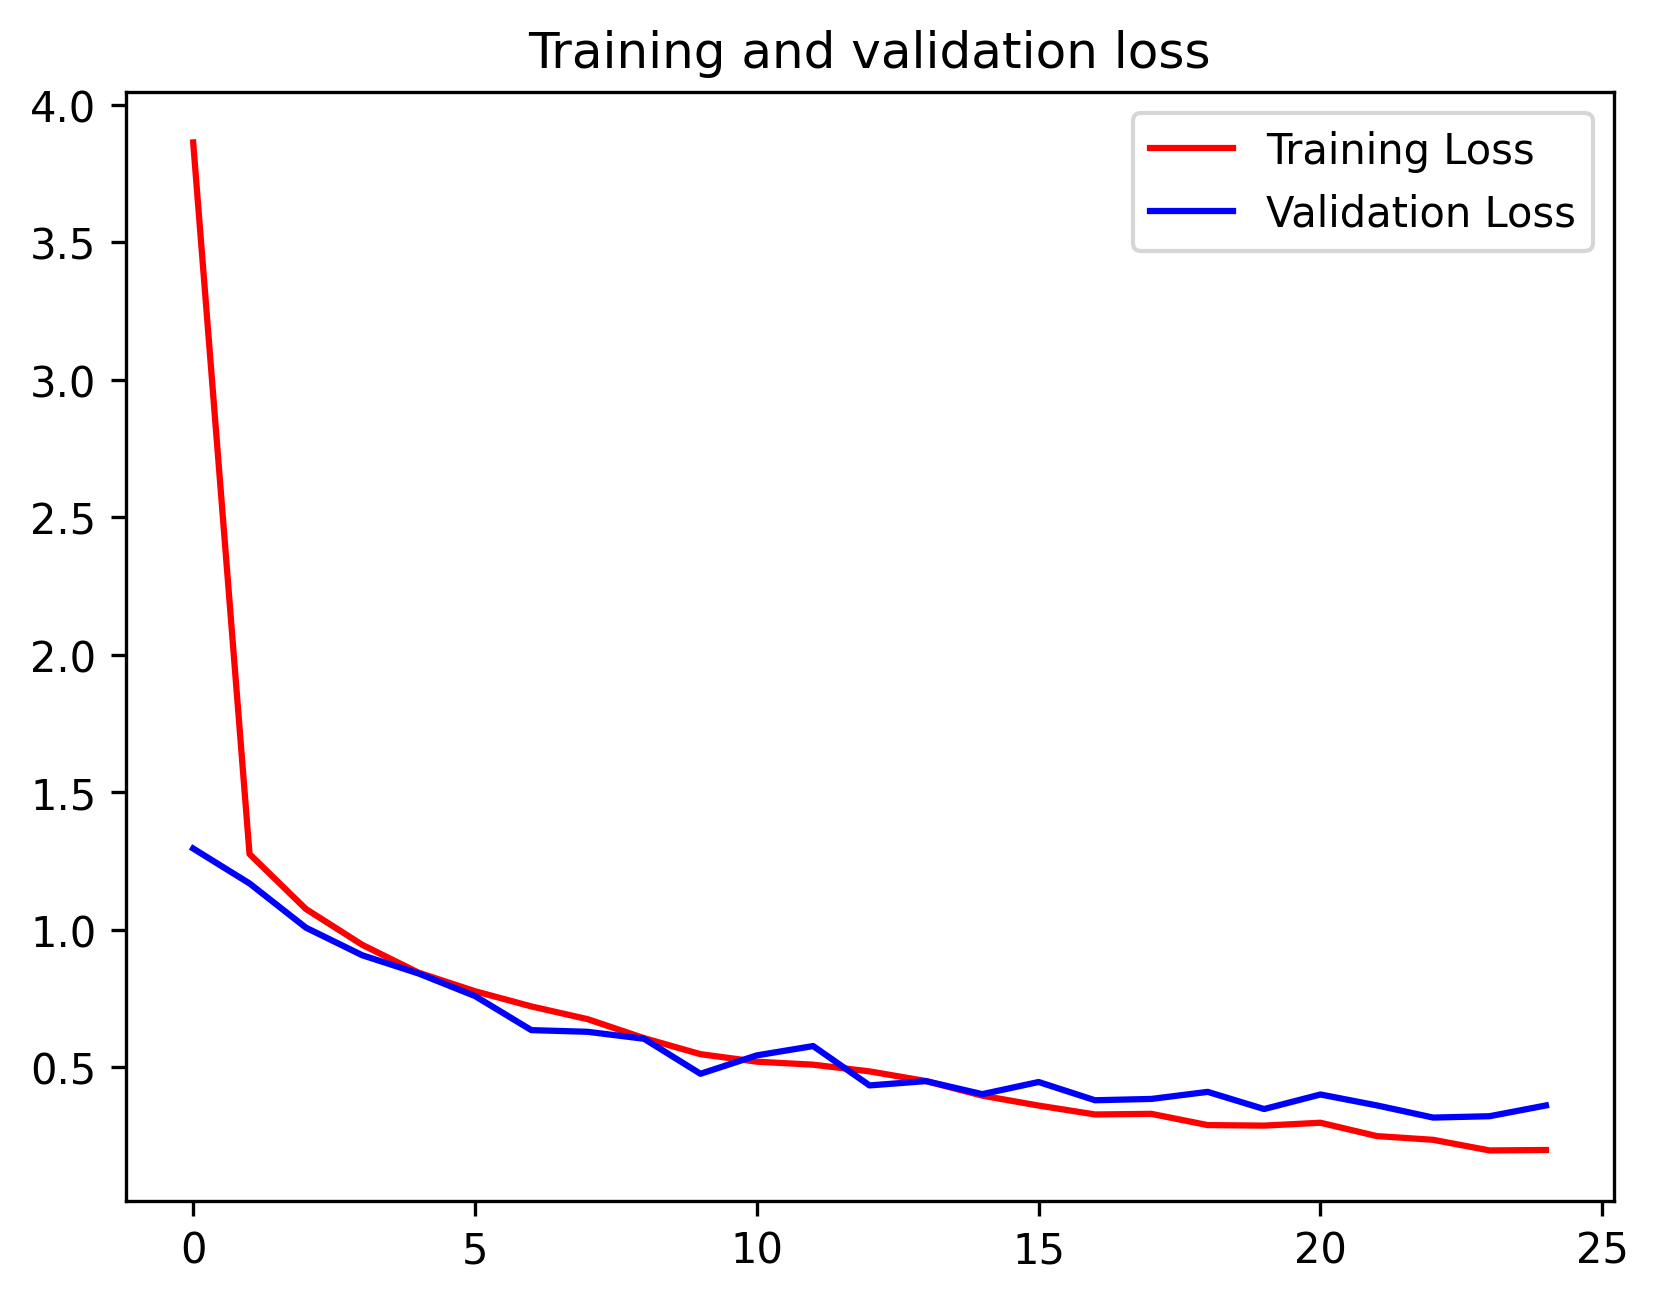

In [38]:
import matplotlib.pyplot as plt
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 04:41:16.038865: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:41:16.061435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 12ms/step


2023-08-06 04:41:31.386240: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:41:31.468850: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 8s 8s/step
              precision    recall  f1-score   support

  meningioma       0.82      0.89      0.85       300
      glioma       0.82      0.50      0.62       306
   pituitary       0.82      1.00      0.90       405
     notumor       0.93      0.94      0.94       300

    accuracy                           0.84      1311
   macro avg       0.85      0.83      0.83      1311
weighted avg       0.84      0.84      0.83      1311



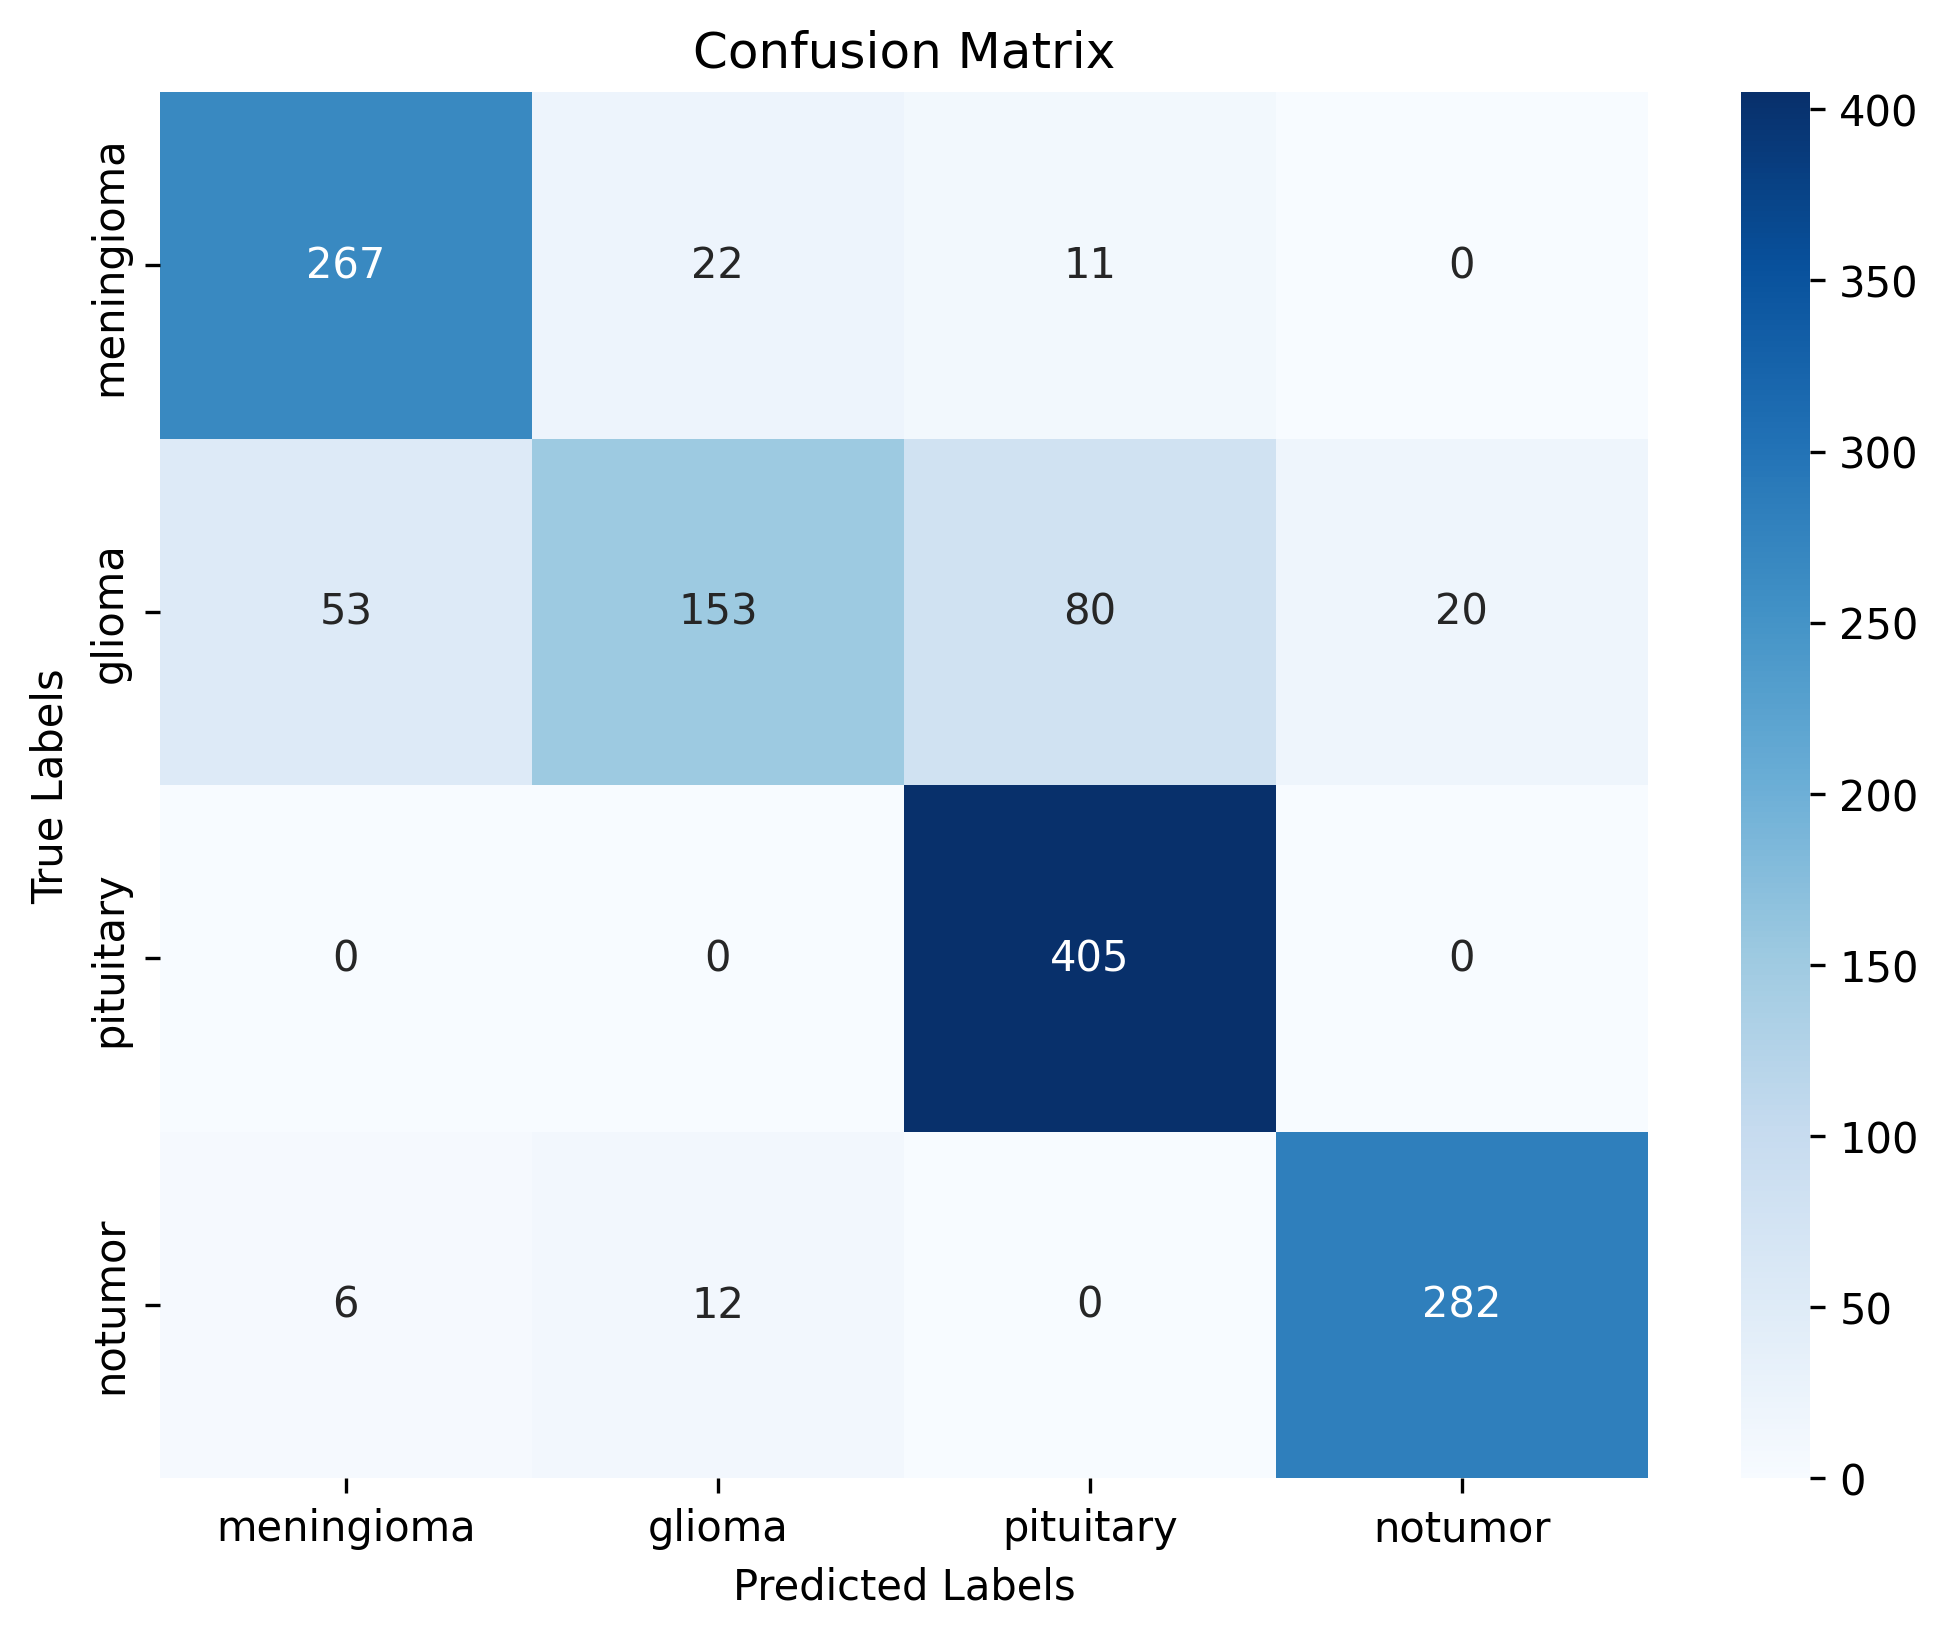

In [39]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model3.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 4. RESNET50

In [40]:
from tensorflow.keras.applications import ResNet50

with tpu_strategy.scope():

    base_model4 = ResNet50(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model4.layers[:10]:
        layer.trainable = False
    x = base_model4.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions4 = Dense(4, activation='softmax')(x)
    model4 = Model(inputs=base_model4.inputs, outputs=predictions4)
    model4.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [41]:
# model4.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [42]:
history4=model4.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model4.save('model4.h5')

Epoch 1/25


2023-08-06 04:42:23.581409: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:42:24.333100: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.8088

2023-08-06 04:43:37.760010: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:43:38.005057: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 116s 2s/step - loss: 0.6396 - accuracy: 0.8088 - val_loss: 140.4485 - val_accuracy: 0.2802
Epoch 2/25
36/36 [==============================] - 4s 119ms/step - loss: 0.2198 - accuracy: 0.9267 - val_loss: 18.8981 - val_accuracy: 0.5061
Epoch 3/25
36/36 [==============================] - 4s 115ms/step - loss: 0.1229 - accuracy: 0.9580 - val_loss: 2.4772 - val_accuracy: 0.7338
Epoch 4/25
36/36 [==============================] - 4s 116ms/step - loss: 0.0492 - accuracy: 0.9845 - val_loss: 6.4339 - val_accuracy: 0.5560
Epoch 5/25
36/36 [==============================] - 4s 121ms/step - loss: 0.0392 - accuracy: 0.9871 - val_loss: 1.1832 - val_accuracy: 0.8205
Epoch 6/25
36/36 [==============================] - 5s 147ms/step - loss: 0.0360 - accuracy: 0.9858 - val_loss: 0.3348 - val_accuracy: 0.9256
Epoch 7/25
36/36 [==============================] - 4s 116ms/step - loss: 0.0386 - accuracy: 0.9860 - val_loss: 0.3879 - val_accuracy: 0.9221
Epoch 8/25
36/3

In [43]:
resnet50_evaluation = model4.evaluate(val_ds)
resnet50_evaluation[1]*100

11/11 [==============================] - 10s 864ms/step - loss: 0.1263 - accuracy: 0.9764


97.63539433479309

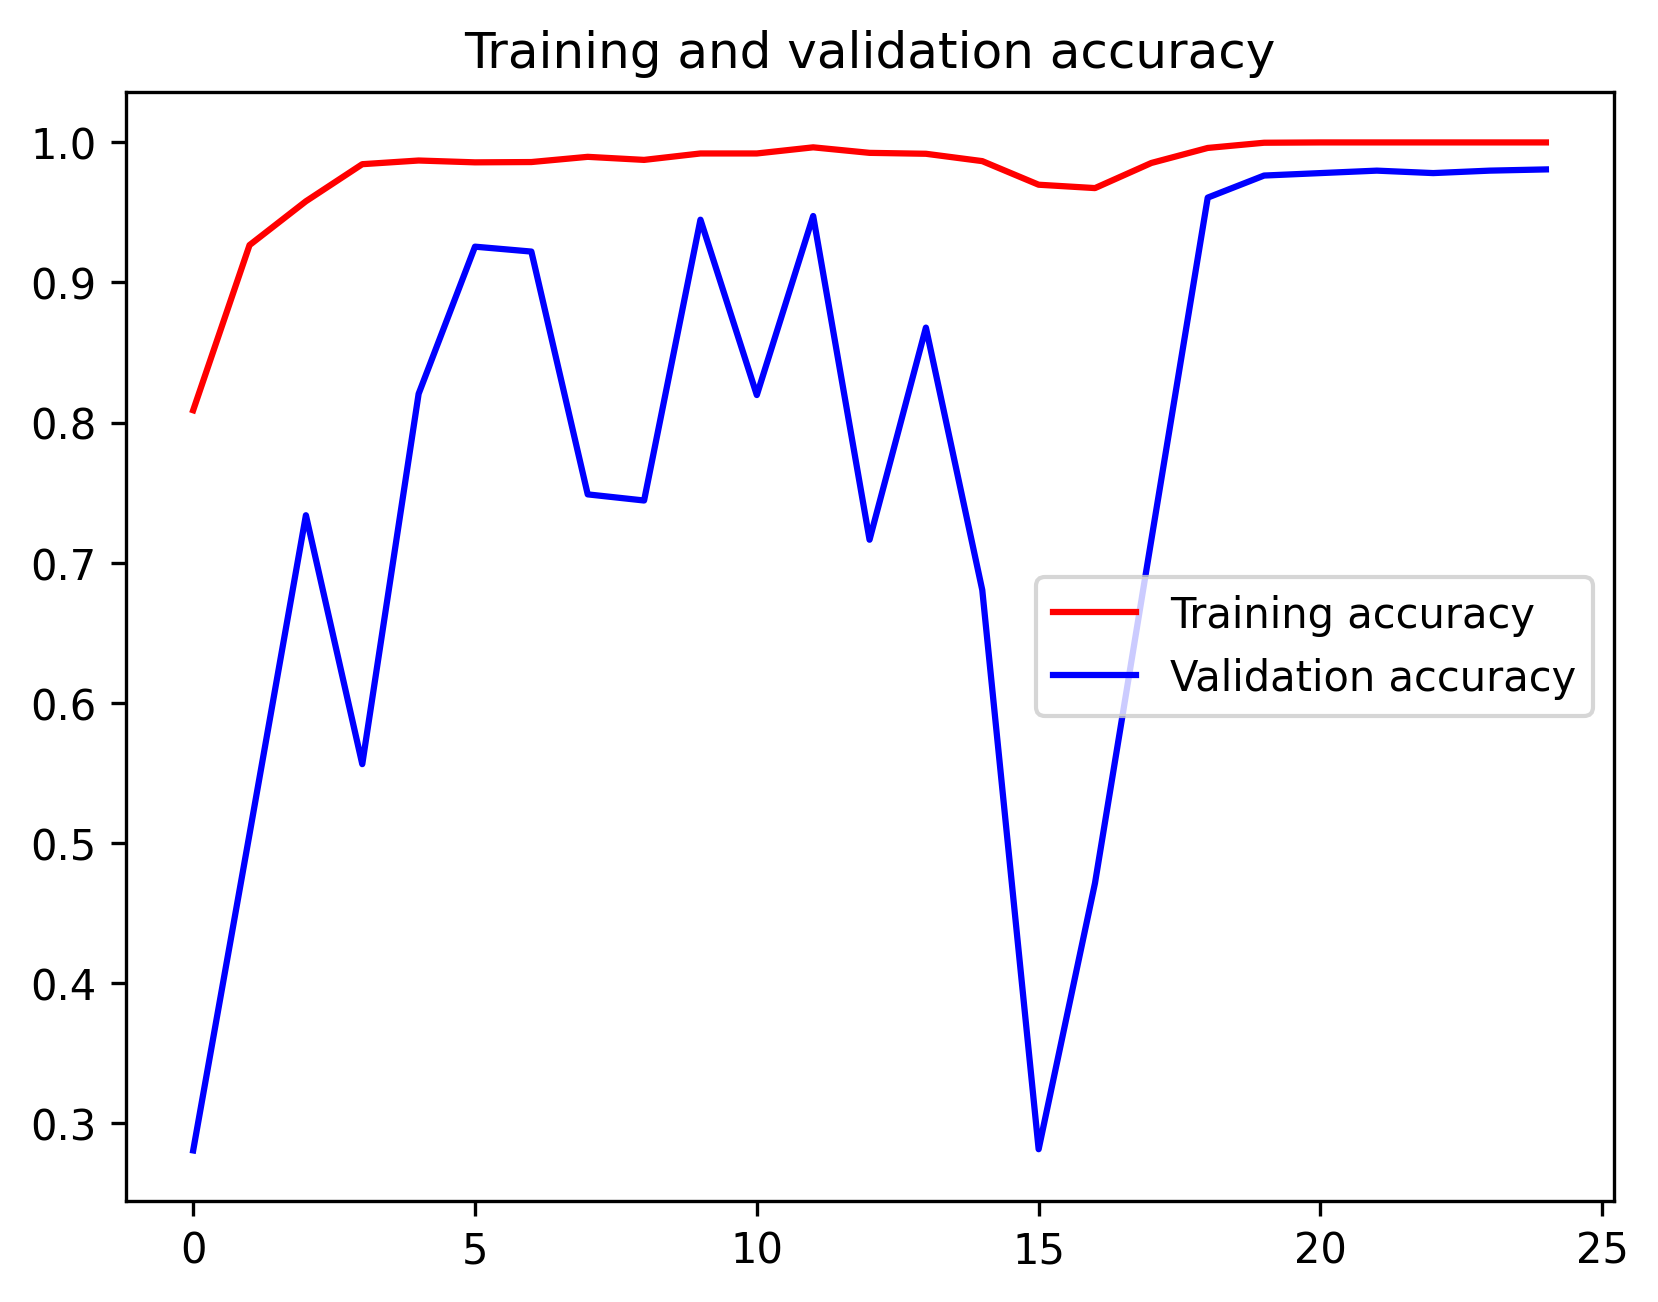

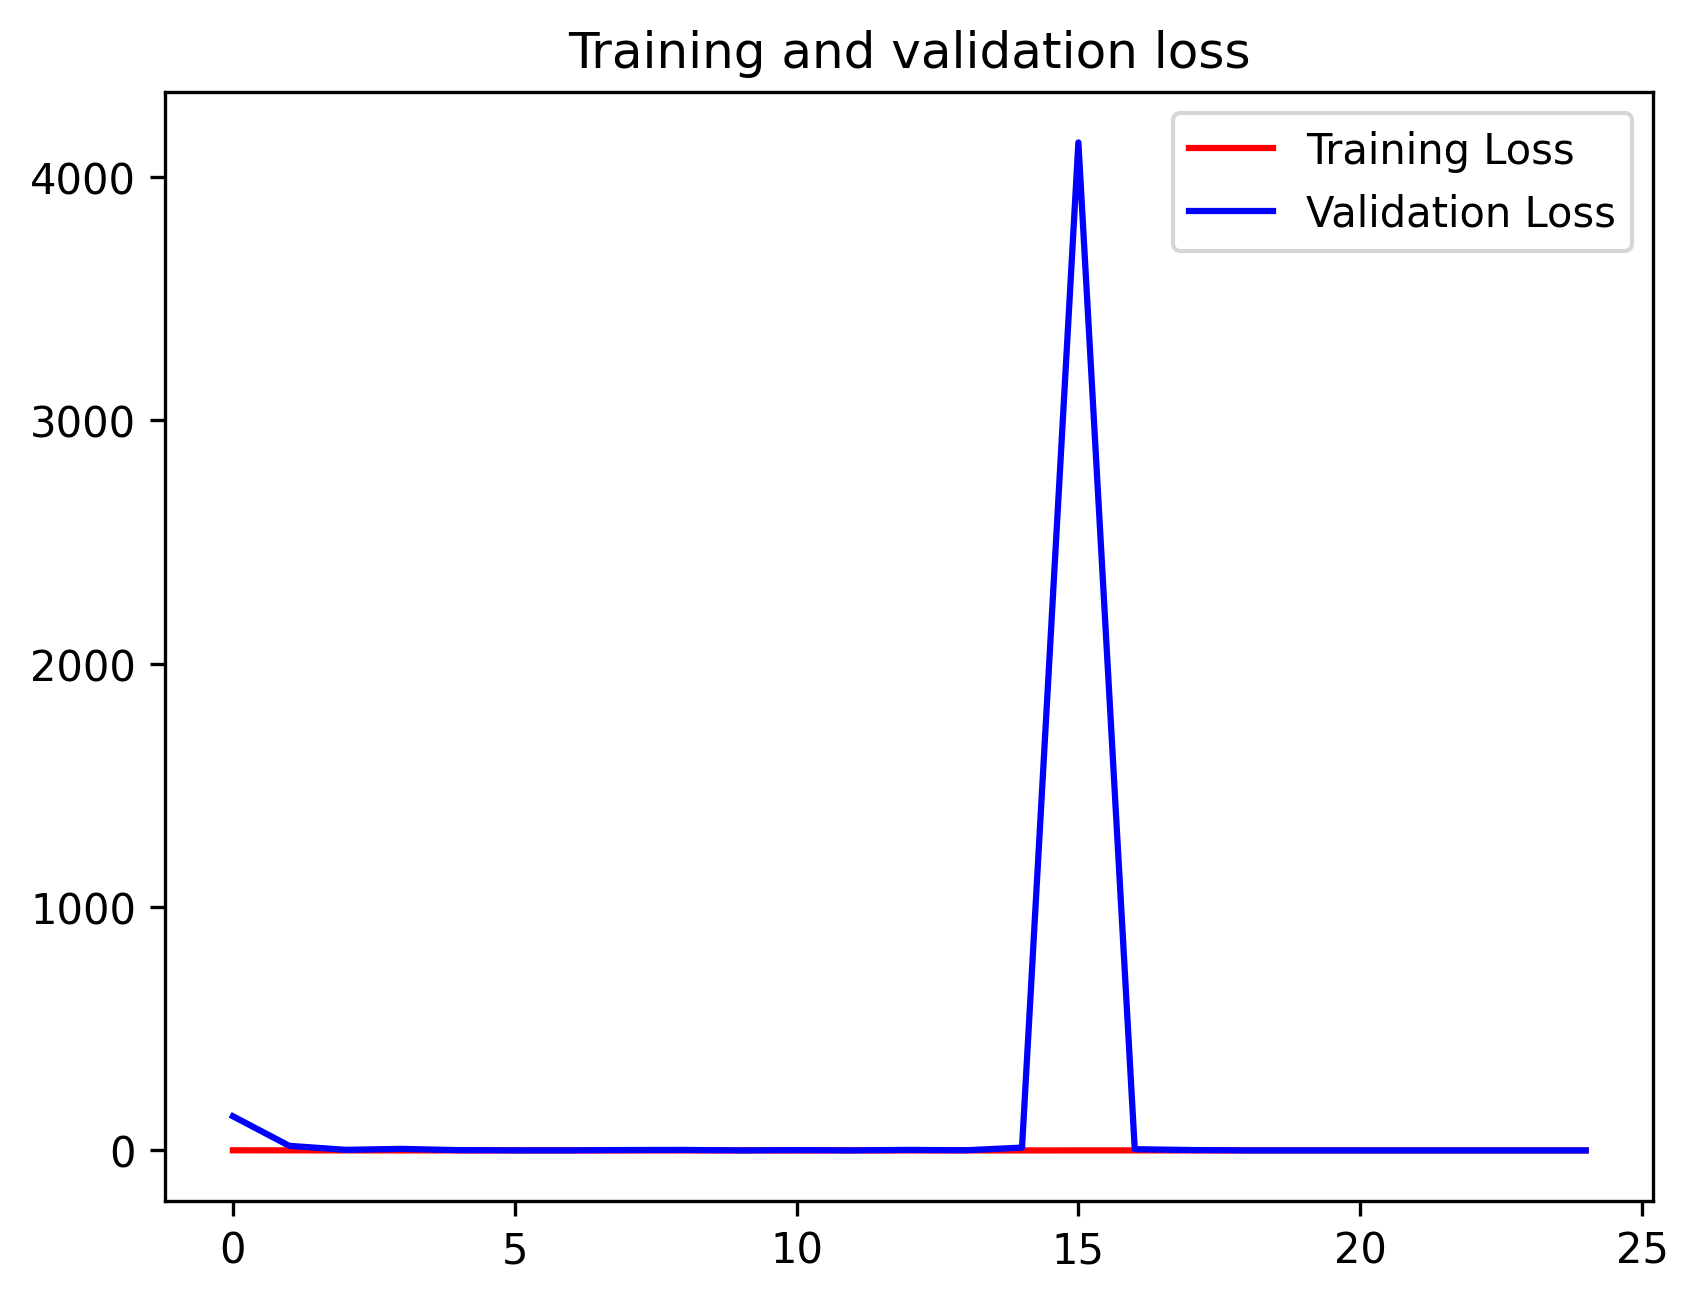

In [44]:
import matplotlib.pyplot as plt
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 04:46:03.420296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:46:03.559875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 15ms/step


2023-08-06 04:46:21.118757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:46:21.314401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 11s 11s/step
              precision    recall  f1-score   support

  meningioma       0.96      0.97      0.97       300
      glioma       0.97      0.95      0.96       306
   pituitary       0.99      1.00      0.99       405
     notumor       0.98      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



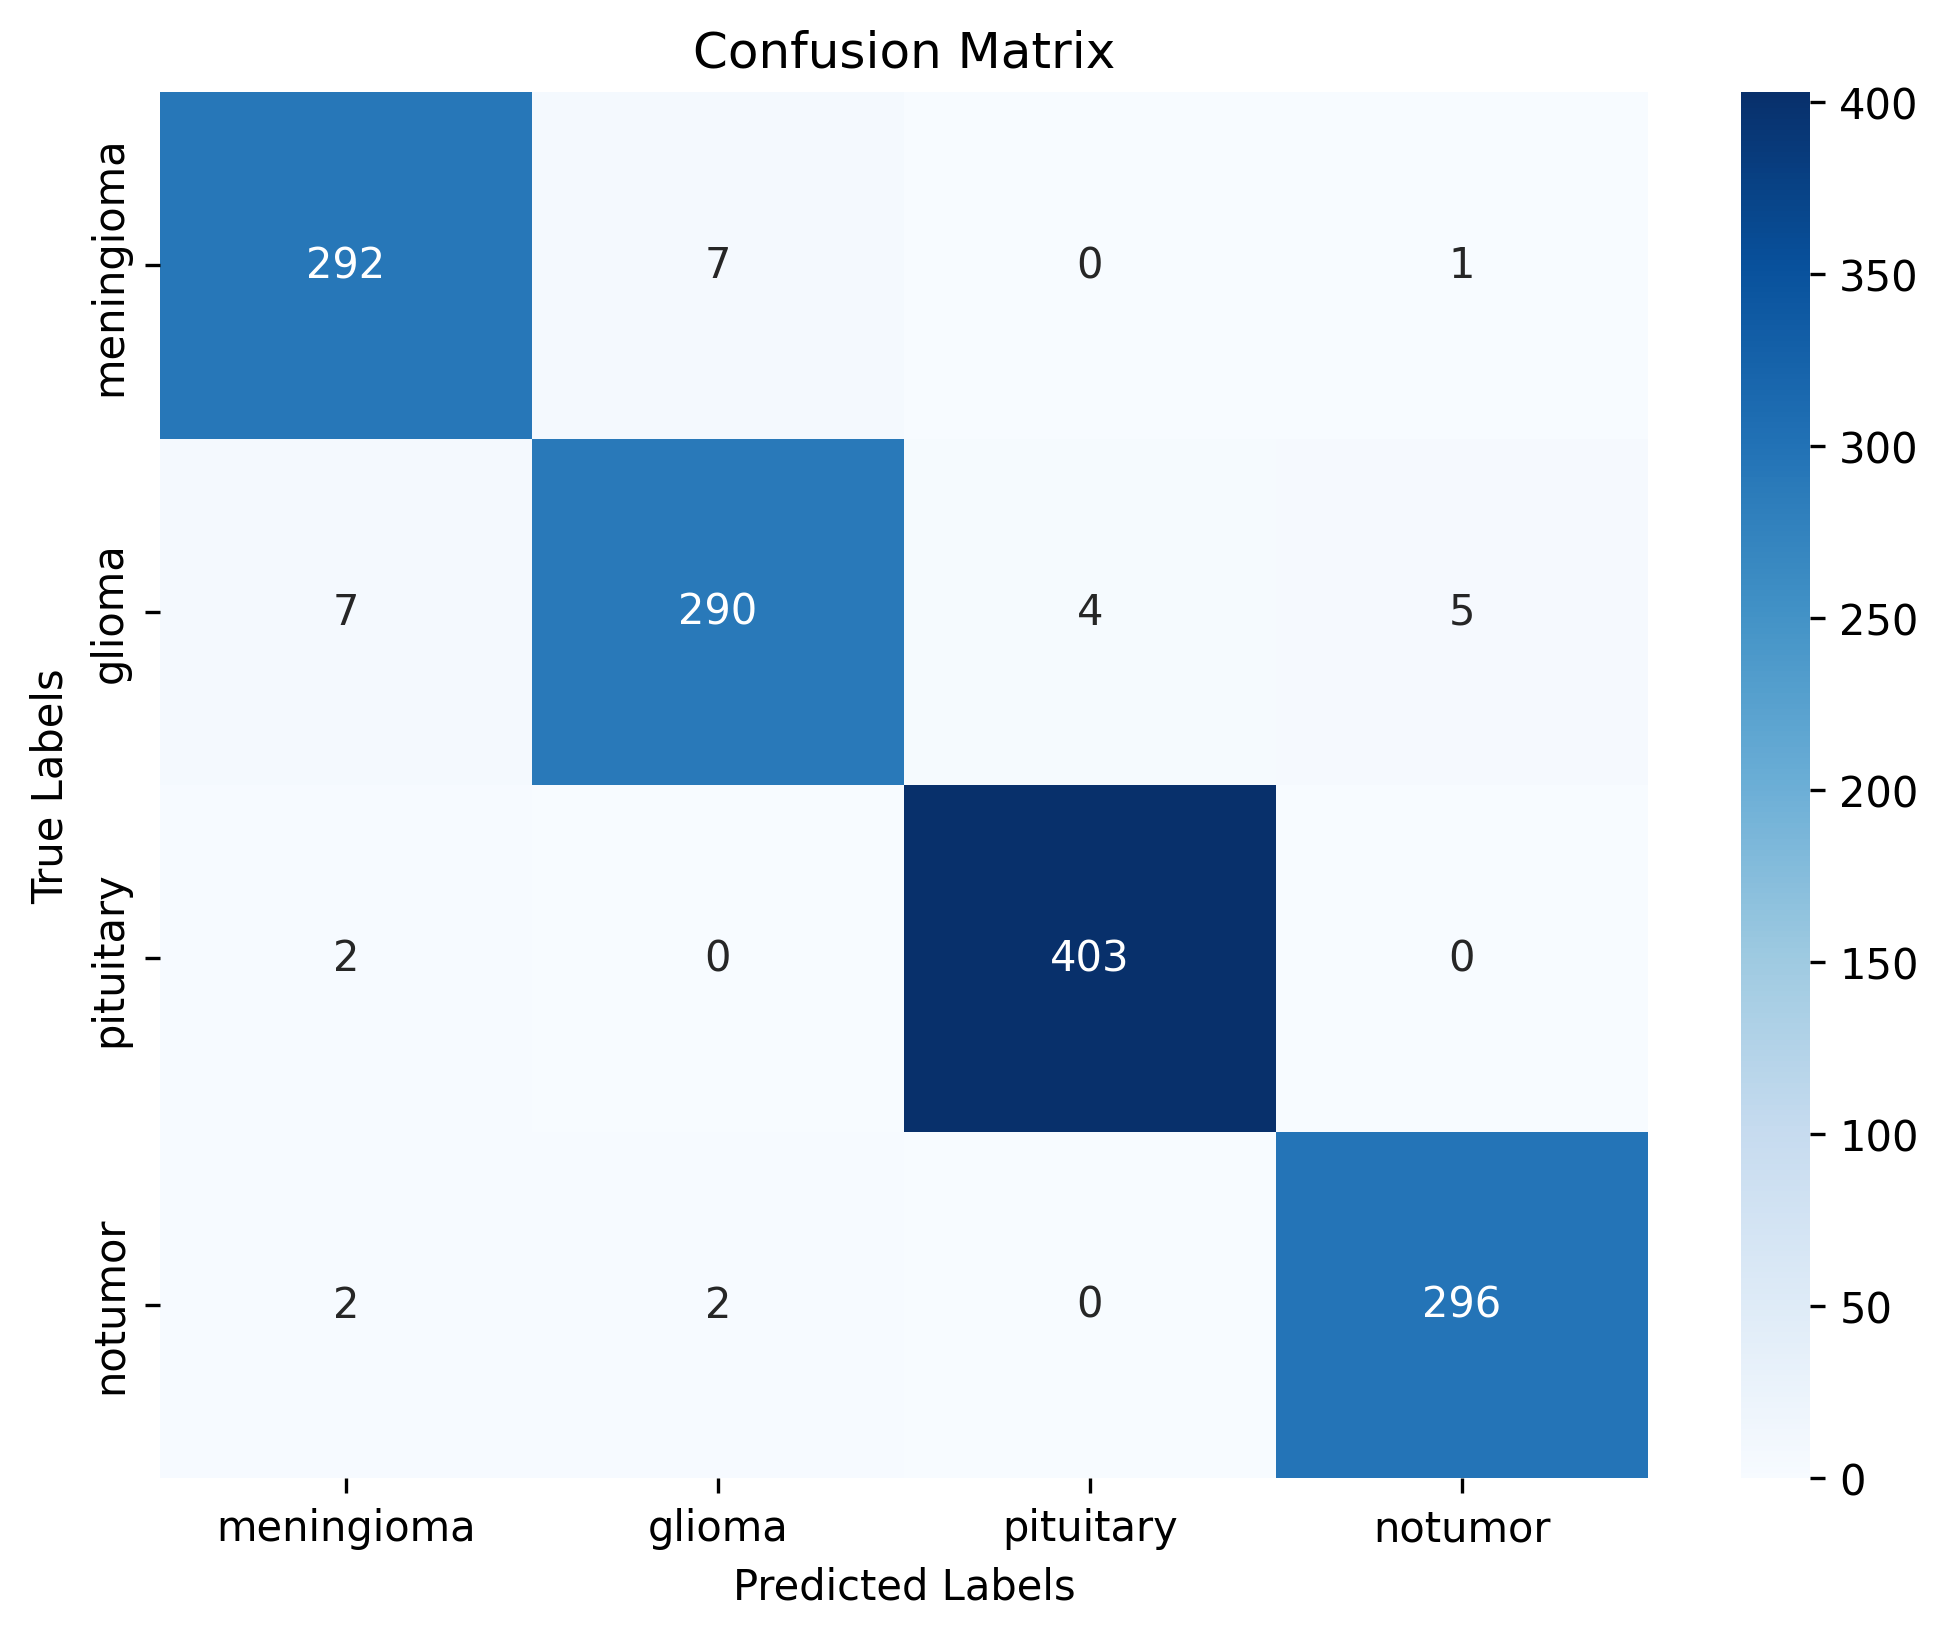

In [45]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model4.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## to write

### 5. Inception-ResNet-v2

In [46]:
with tpu_strategy.scope():

    base_model5 = tf.keras.applications.InceptionResNetV2(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model5.layers[:10]:
        layer.trainable = False
    x = base_model5.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions5 = Dense(4, activation='softmax')(x)
    model5 = Model(inputs=base_model5.inputs, outputs=predictions5)
    model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

219055592/219055592 [==============================] - 1s 0us/step


In [47]:
# model5.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [48]:
history5=model5.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model5.save('model5.h5')

Epoch 1/25


2023-08-06 04:48:27.637088: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:48:30.069359: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8394

2023-08-06 04:51:51.949013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:51:52.480587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 309s 4s/step - loss: 0.4486 - accuracy: 0.8394 - val_loss: 685.1191 - val_accuracy: 0.2601
Epoch 2/25
36/36 [==============================] - 7s 193ms/step - loss: 0.1301 - accuracy: 0.9580 - val_loss: 4.4394 - val_accuracy: 0.3975
Epoch 3/25
36/36 [==============================] - 7s 192ms/step - loss: 0.0799 - accuracy: 0.9735 - val_loss: 24.0414 - val_accuracy: 0.3844
Epoch 4/25
36/36 [==============================] - 8s 232ms/step - loss: 0.0440 - accuracy: 0.9860 - val_loss: 1.2727 - val_accuracy: 0.7338
Epoch 5/25
36/36 [==============================] - 7s 191ms/step - loss: 0.0479 - accuracy: 0.9836 - val_loss: 0.3206 - val_accuracy: 0.9221
Epoch 6/25
36/36 [==============================] - 7s 192ms/step - loss: 0.0393 - accuracy: 0.9849 - val_loss: 0.4290 - val_accuracy: 0.9028
Epoch 7/25
36/36 [==============================] - 7s 198ms/step - loss: 0.0386 - accuracy: 0.9891 - val_loss: 0.4877 - val_accuracy: 0.9089
Epoch 8/25
36/3

In [49]:
inceptionresnetv2_evaluation = model5.evaluate(val_ds)
inceptionresnetv2_evaluation[1]*100

11/11 [==============================] - 15s 1s/step - loss: 3.8478 - accuracy: 0.7857


78.56597900390625

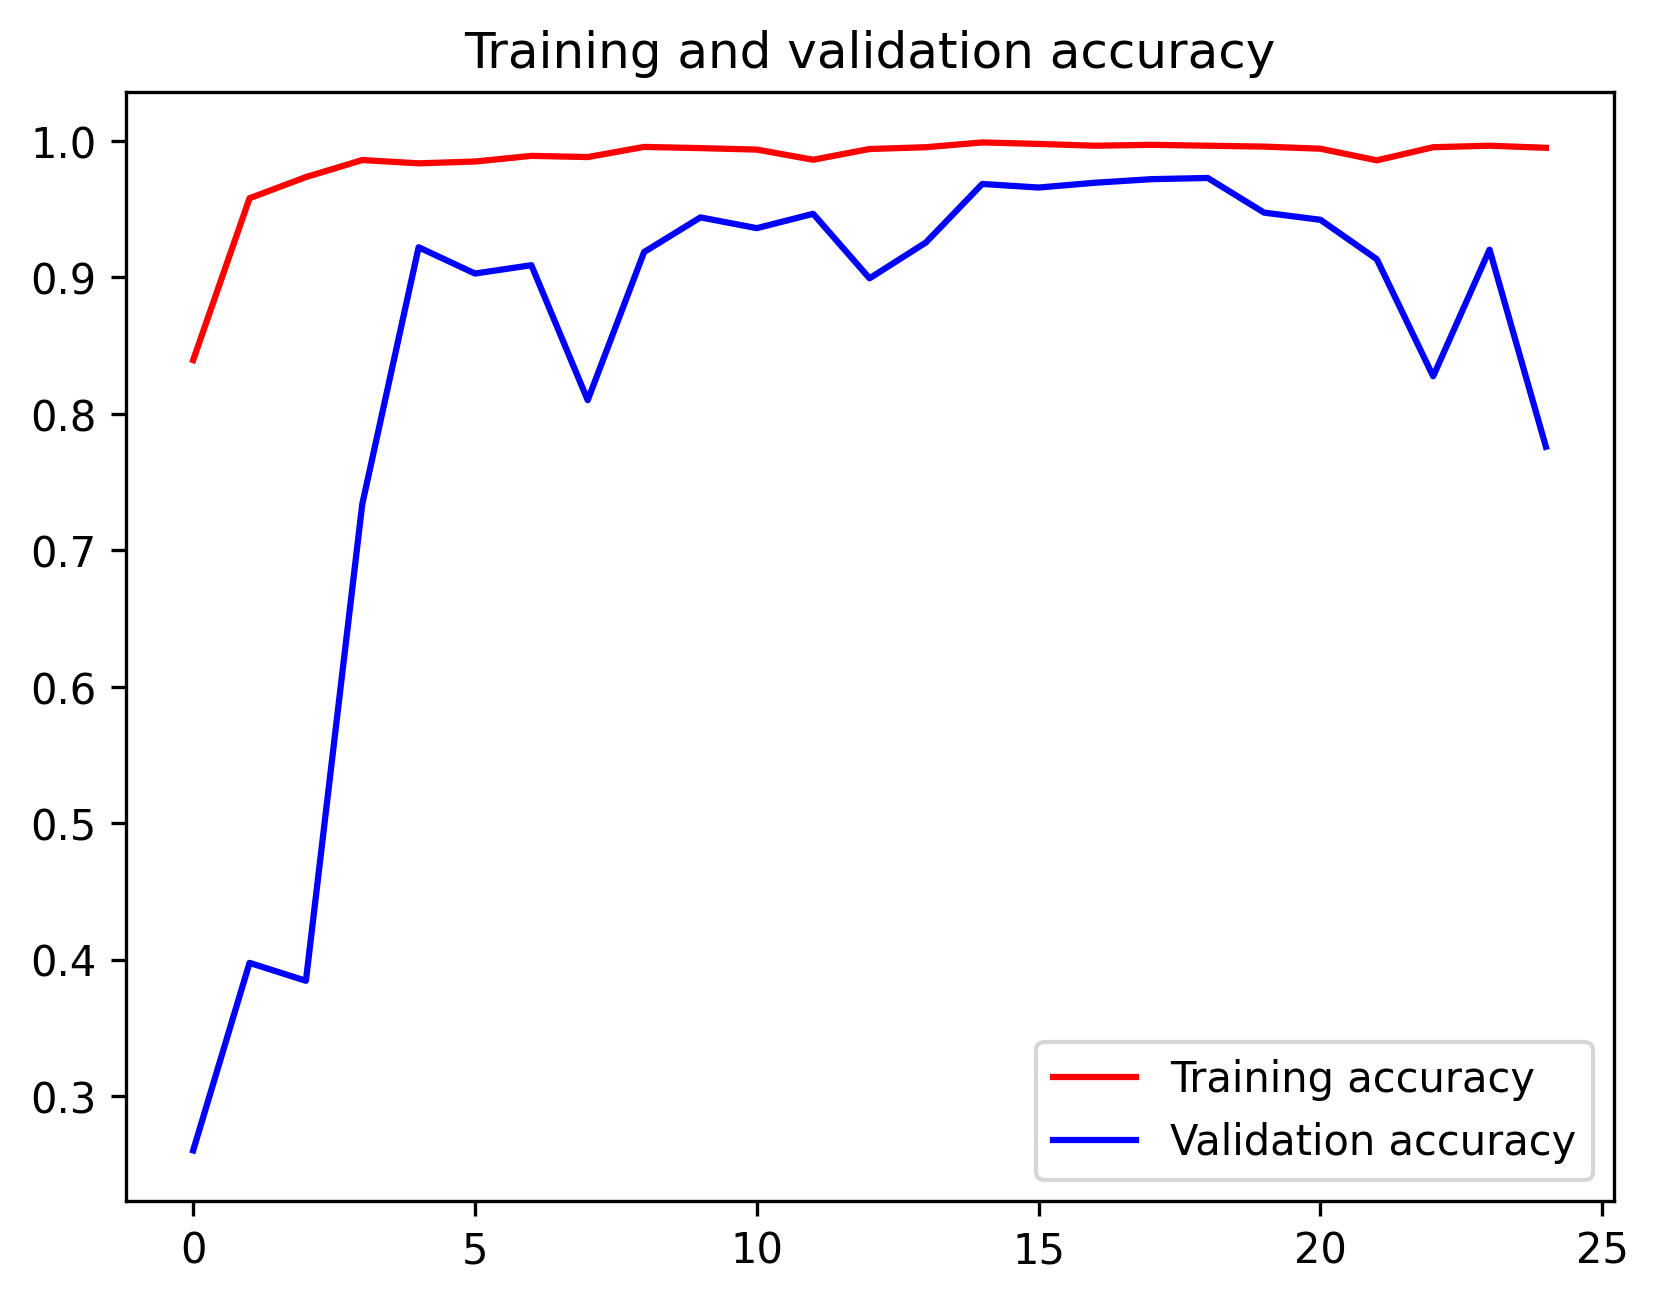

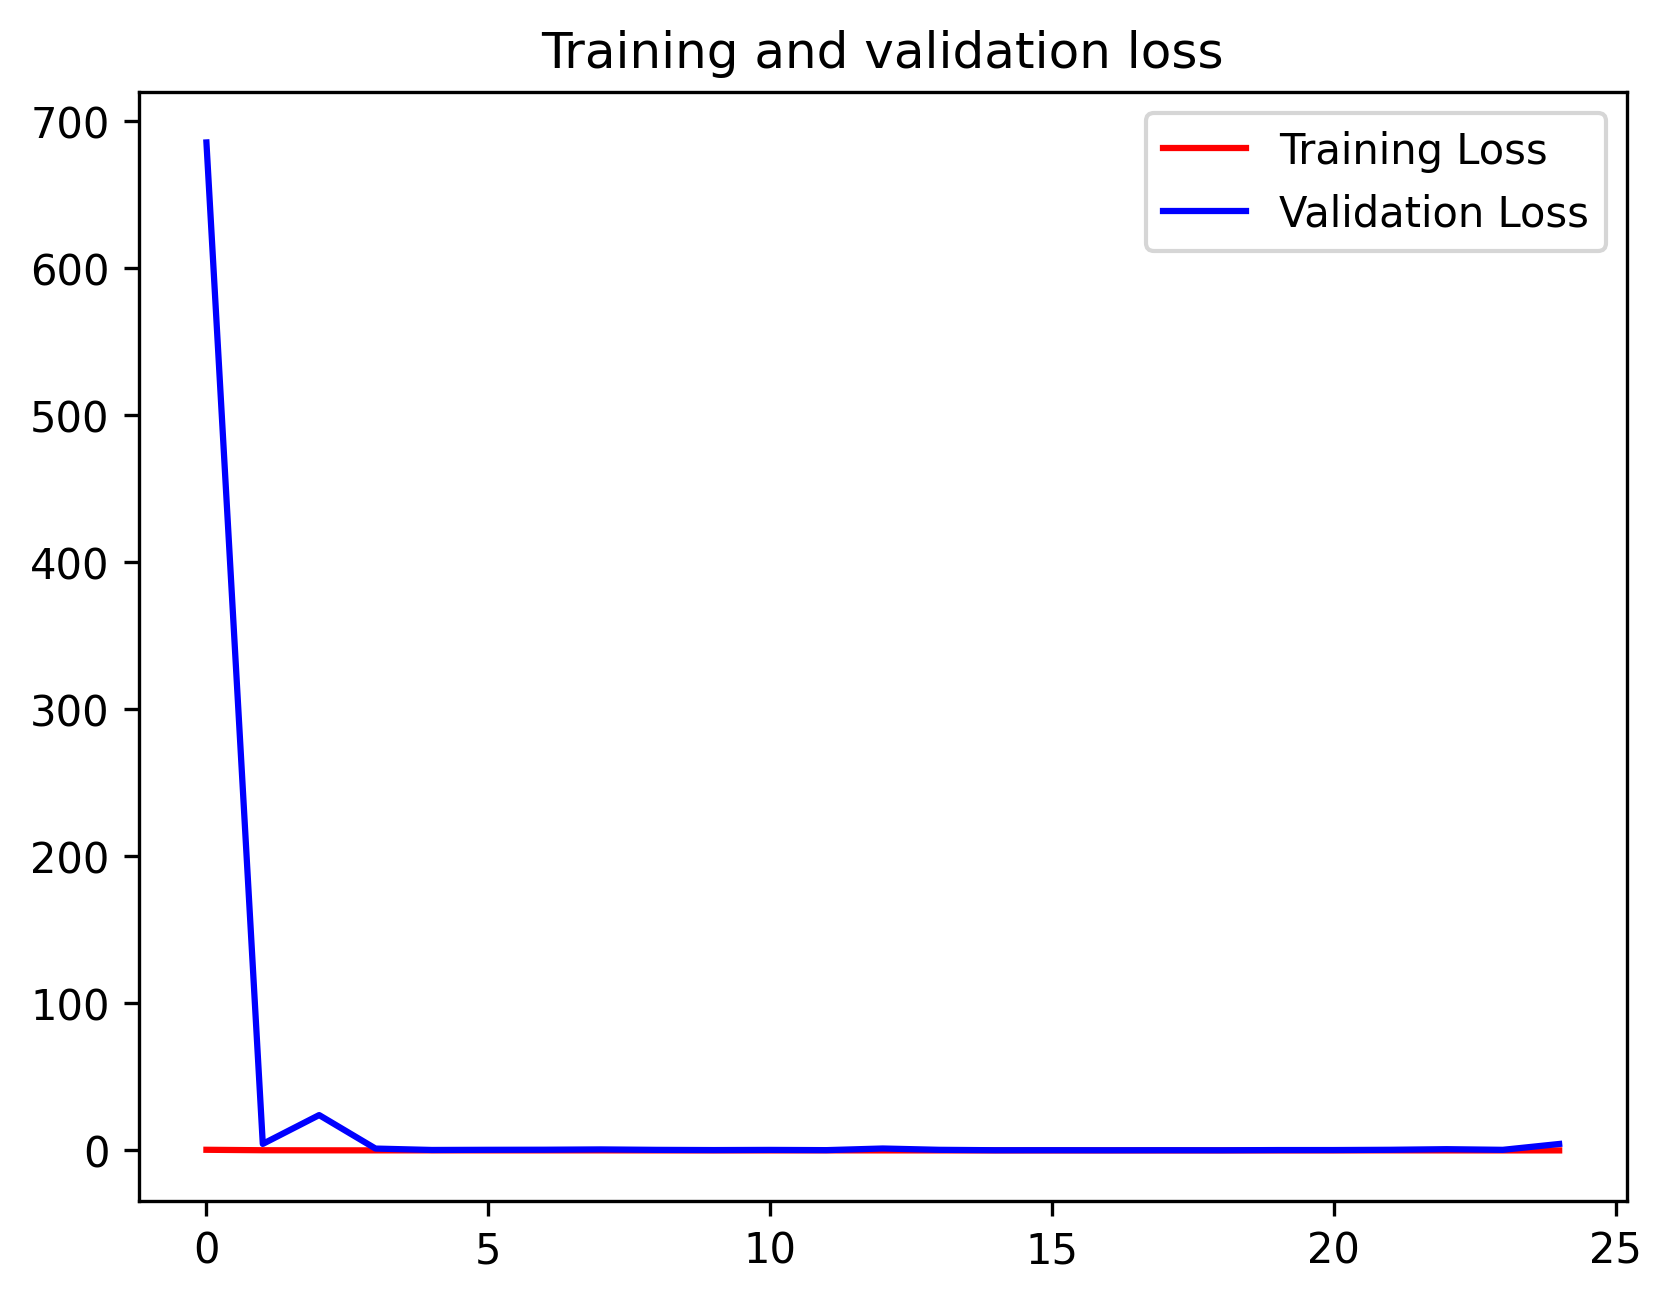

In [50]:
import matplotlib.pyplot as plt
acc = history5.history['accuracy']
val_acc = history5.history['val_accuracy']
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 04:55:54.373252: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:55:54.788199: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 33ms/step


2023-08-06 04:56:25.193150: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:56:25.757044: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 24s 24s/step
              precision    recall  f1-score   support

  meningioma       1.00      0.71      0.83       300
      glioma       0.99      0.67      0.80       306
   pituitary       0.90      0.76      0.82       405
     notumor       0.55      1.00      0.71       300

    accuracy                           0.78      1311
   macro avg       0.86      0.78      0.79      1311
weighted avg       0.86      0.78      0.79      1311



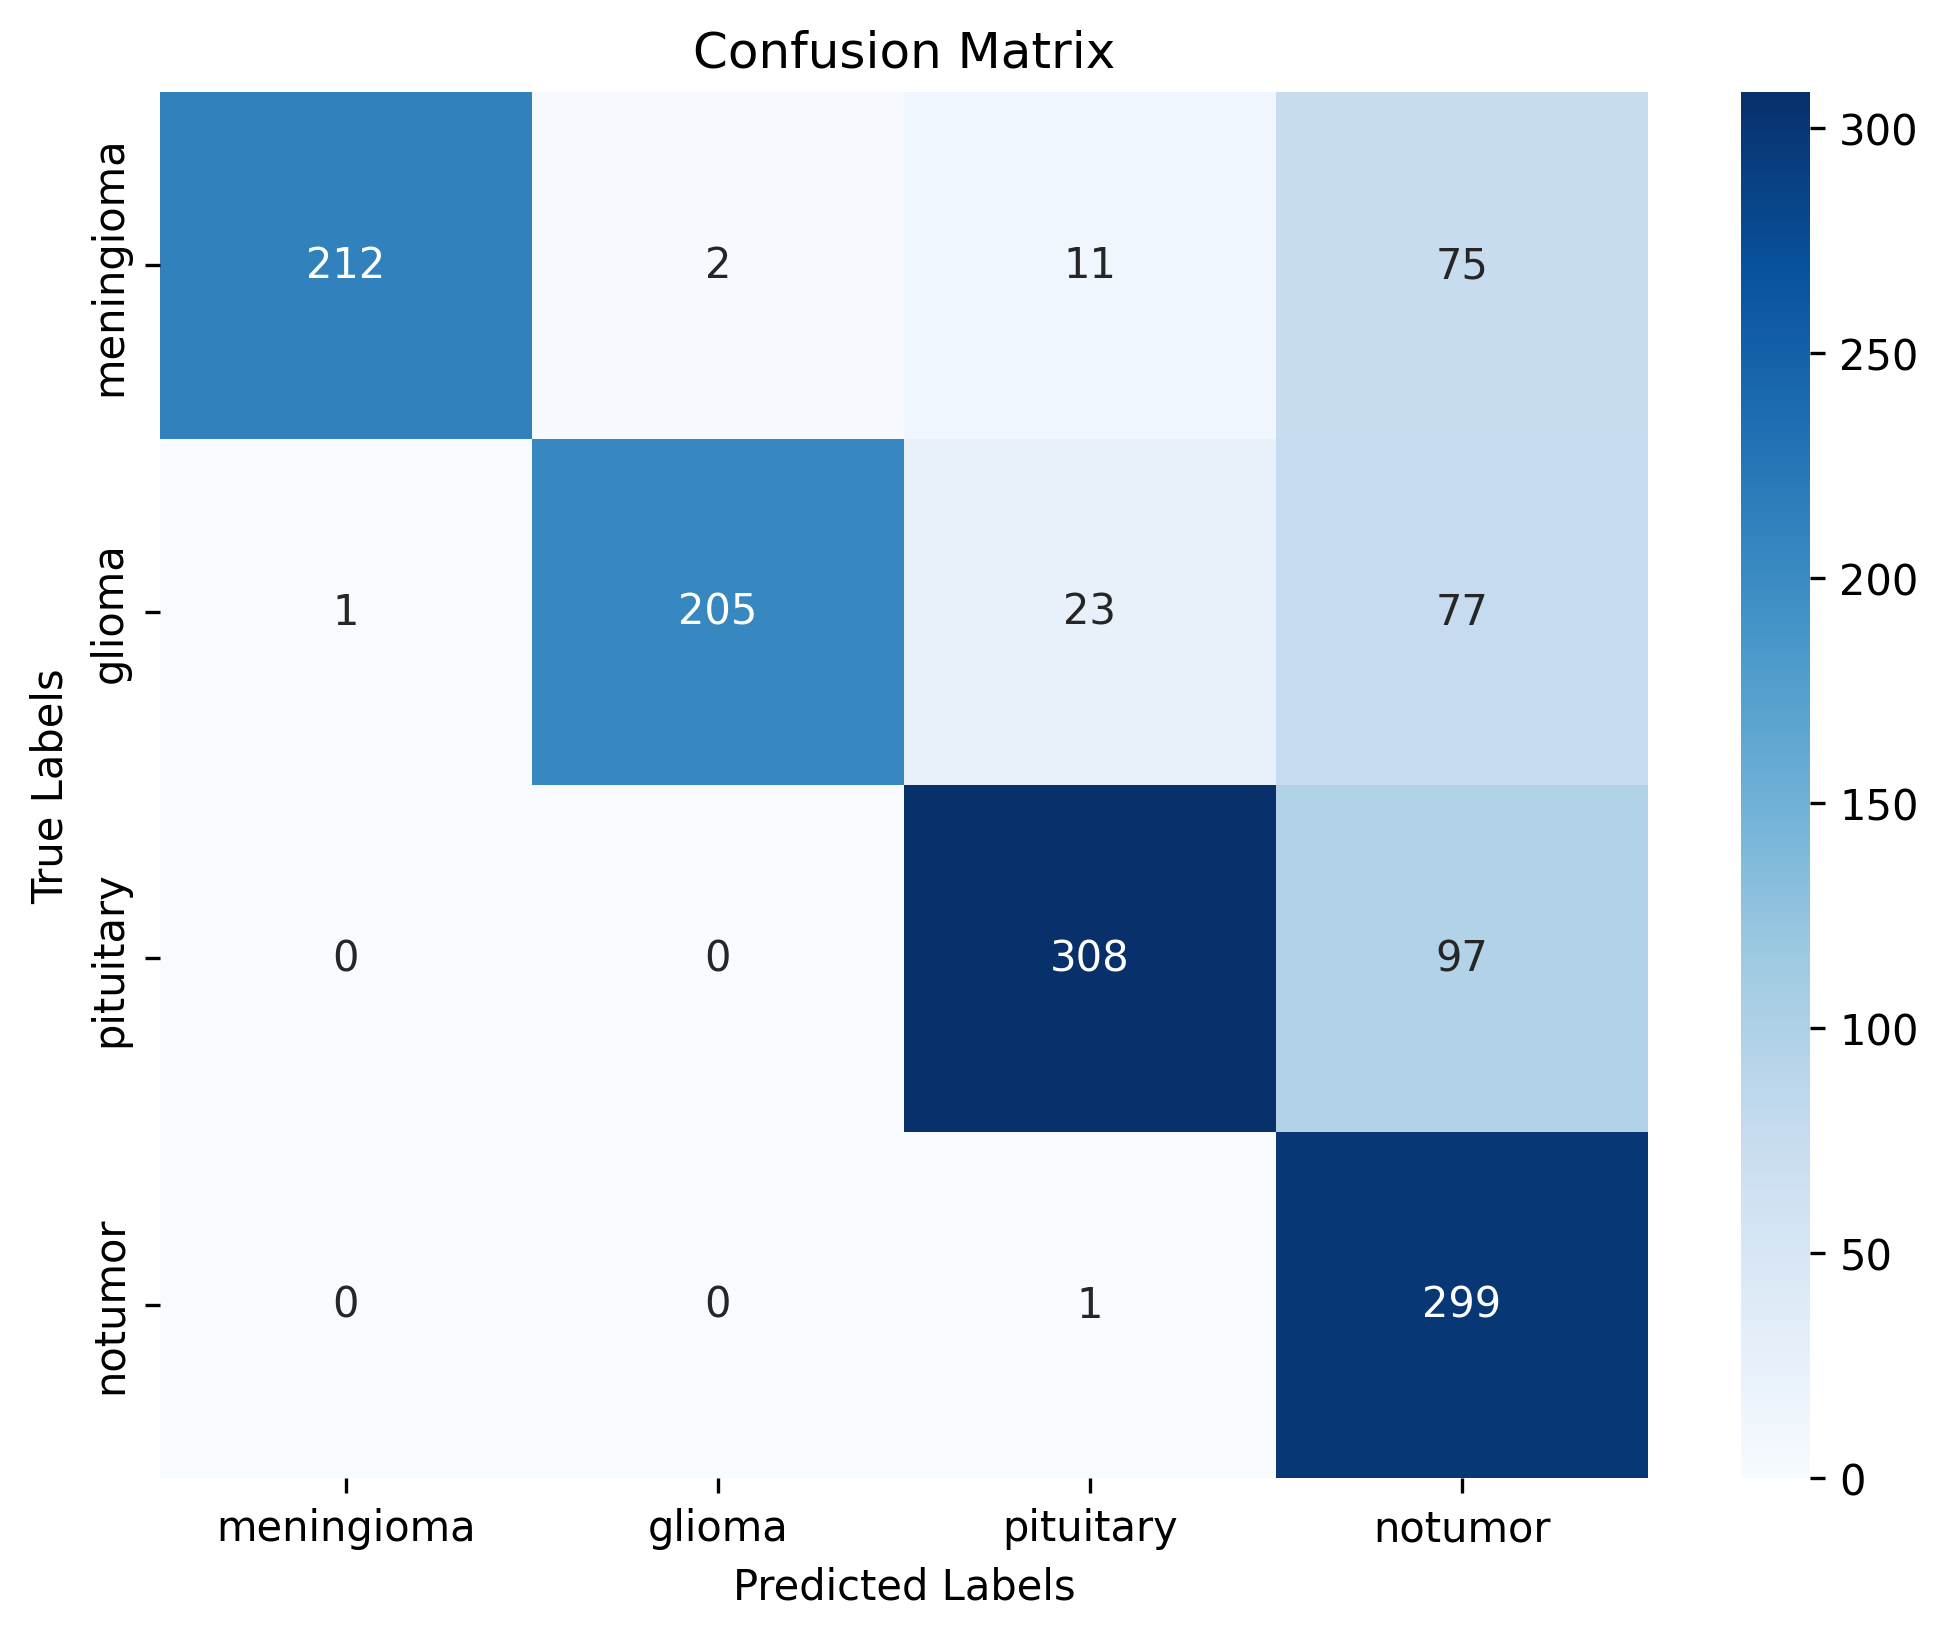

In [51]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model5.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### 6. DenseNet-201

In [52]:
with tpu_strategy.scope():

    base_model6 = tf.keras.applications.DenseNet201(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model6.layers[:10]:
        layer.trainable = False
    x = base_model6.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions6 = Dense(4, activation='softmax')(x)
    model6 = Model(inputs=base_model6.inputs, outputs=predictions6)
    model6.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

74836368/74836368 [==============================] - 0s 0us/step


In [53]:
# model6.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [54]:
history6=model6.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model6.save('model6.h5')

Epoch 1/25


2023-08-06 04:59:02.075194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 04:59:04.772477: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.4686 - accuracy: 0.8418

2023-08-06 05:02:57.715453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:02:58.354782: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 365s 5s/step - loss: 0.4686 - accuracy: 0.8418 - val_loss: 23.3833 - val_accuracy: 0.2688
Epoch 2/25
36/36 [==============================] - 8s 218ms/step - loss: 0.1659 - accuracy: 0.9416 - val_loss: 7.8633 - val_accuracy: 0.4781
Epoch 3/25
36/36 [==============================] - 8s 221ms/step - loss: 0.0766 - accuracy: 0.9768 - val_loss: 0.8072 - val_accuracy: 0.8573
Epoch 4/25
36/36 [==============================] - 8s 223ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 1.1899 - val_accuracy: 0.8494
Epoch 5/25
36/36 [==============================] - 8s 223ms/step - loss: 0.0850 - accuracy: 0.9713 - val_loss: 12.9895 - val_accuracy: 0.3389
Epoch 6/25
36/36 [==============================] - 8s 226ms/step - loss: 0.0505 - accuracy: 0.9851 - val_loss: 0.7764 - val_accuracy: 0.8818
Epoch 7/25
36/36 [==============================] - 8s 227ms/step - loss: 0.0346 - accuracy: 0.9886 - val_loss: 0.3816 - val_accuracy: 0.9317
Epoch 8/25
36/36

In [55]:
densenet201_evaluation = model6.evaluate(val_ds)
densenet201_evaluation[1]*100

11/11 [==============================] - 30s 3s/step - loss: 0.0456 - accuracy: 0.9908


99.08466935157776

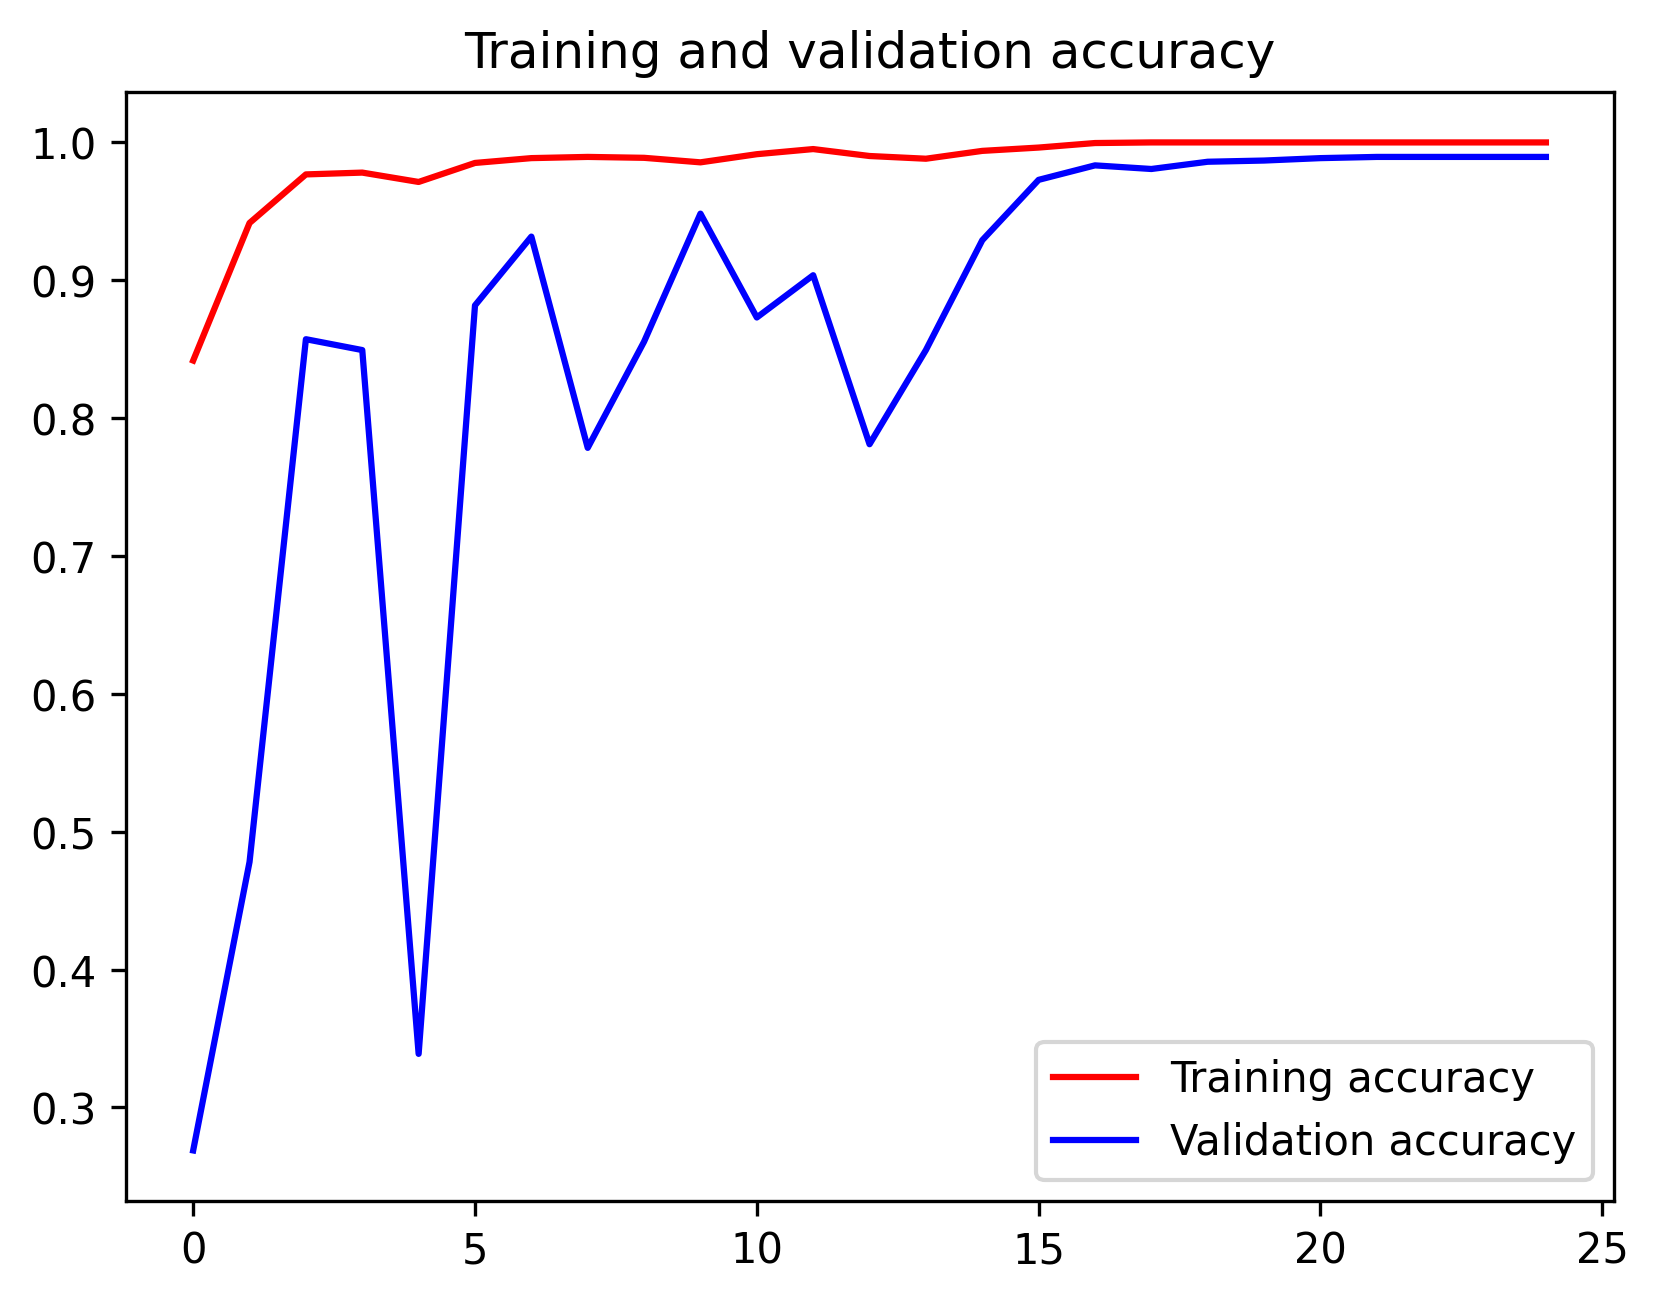

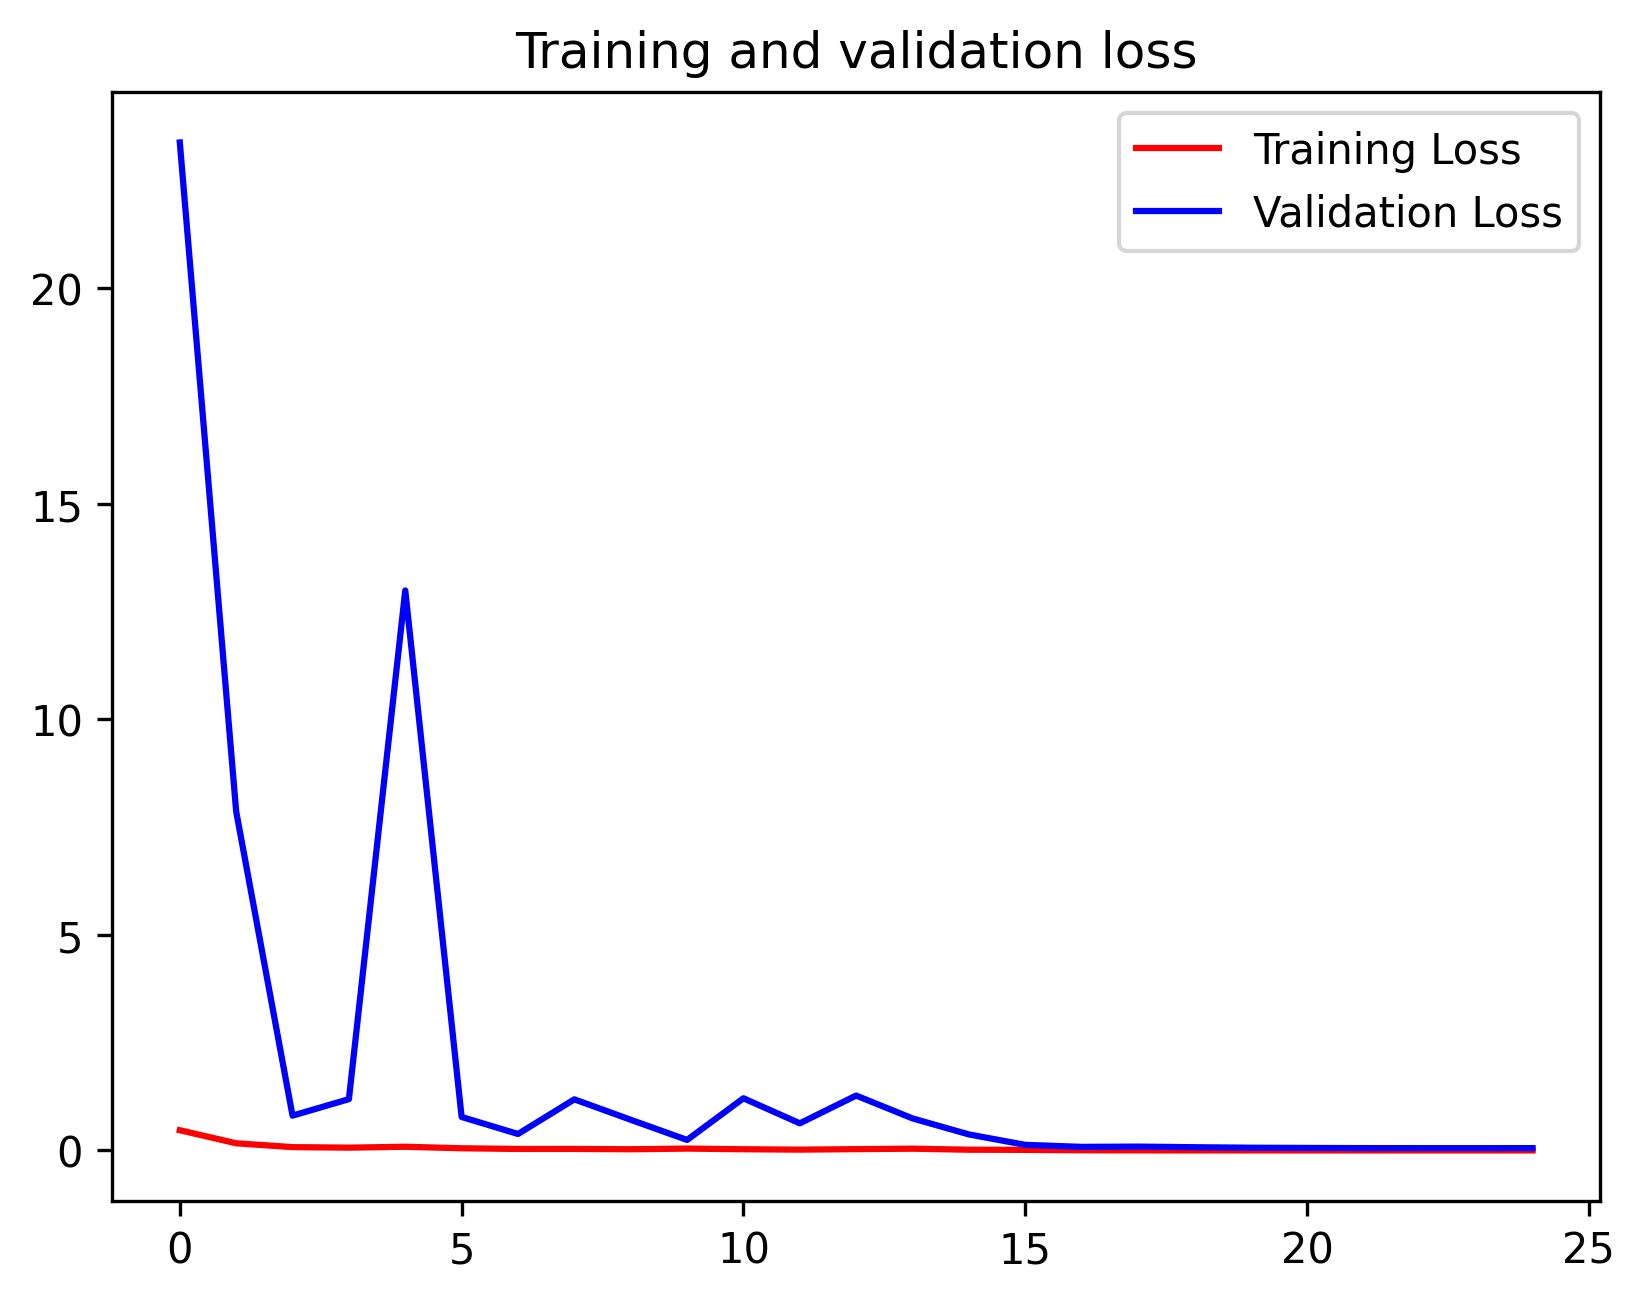

In [56]:
import matplotlib.pyplot as plt
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']
loss = history6.history['loss']
val_loss = history6.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 05:07:58.176773: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:07:58.608453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 37ms/step


2023-08-06 05:08:36.895640: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:08:37.413002: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 43s 43s/step
              precision    recall  f1-score   support

  meningioma       1.00      0.99      0.99       300
      glioma       0.98      0.99      0.99       306
   pituitary       1.00      1.00      1.00       405
     notumor       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



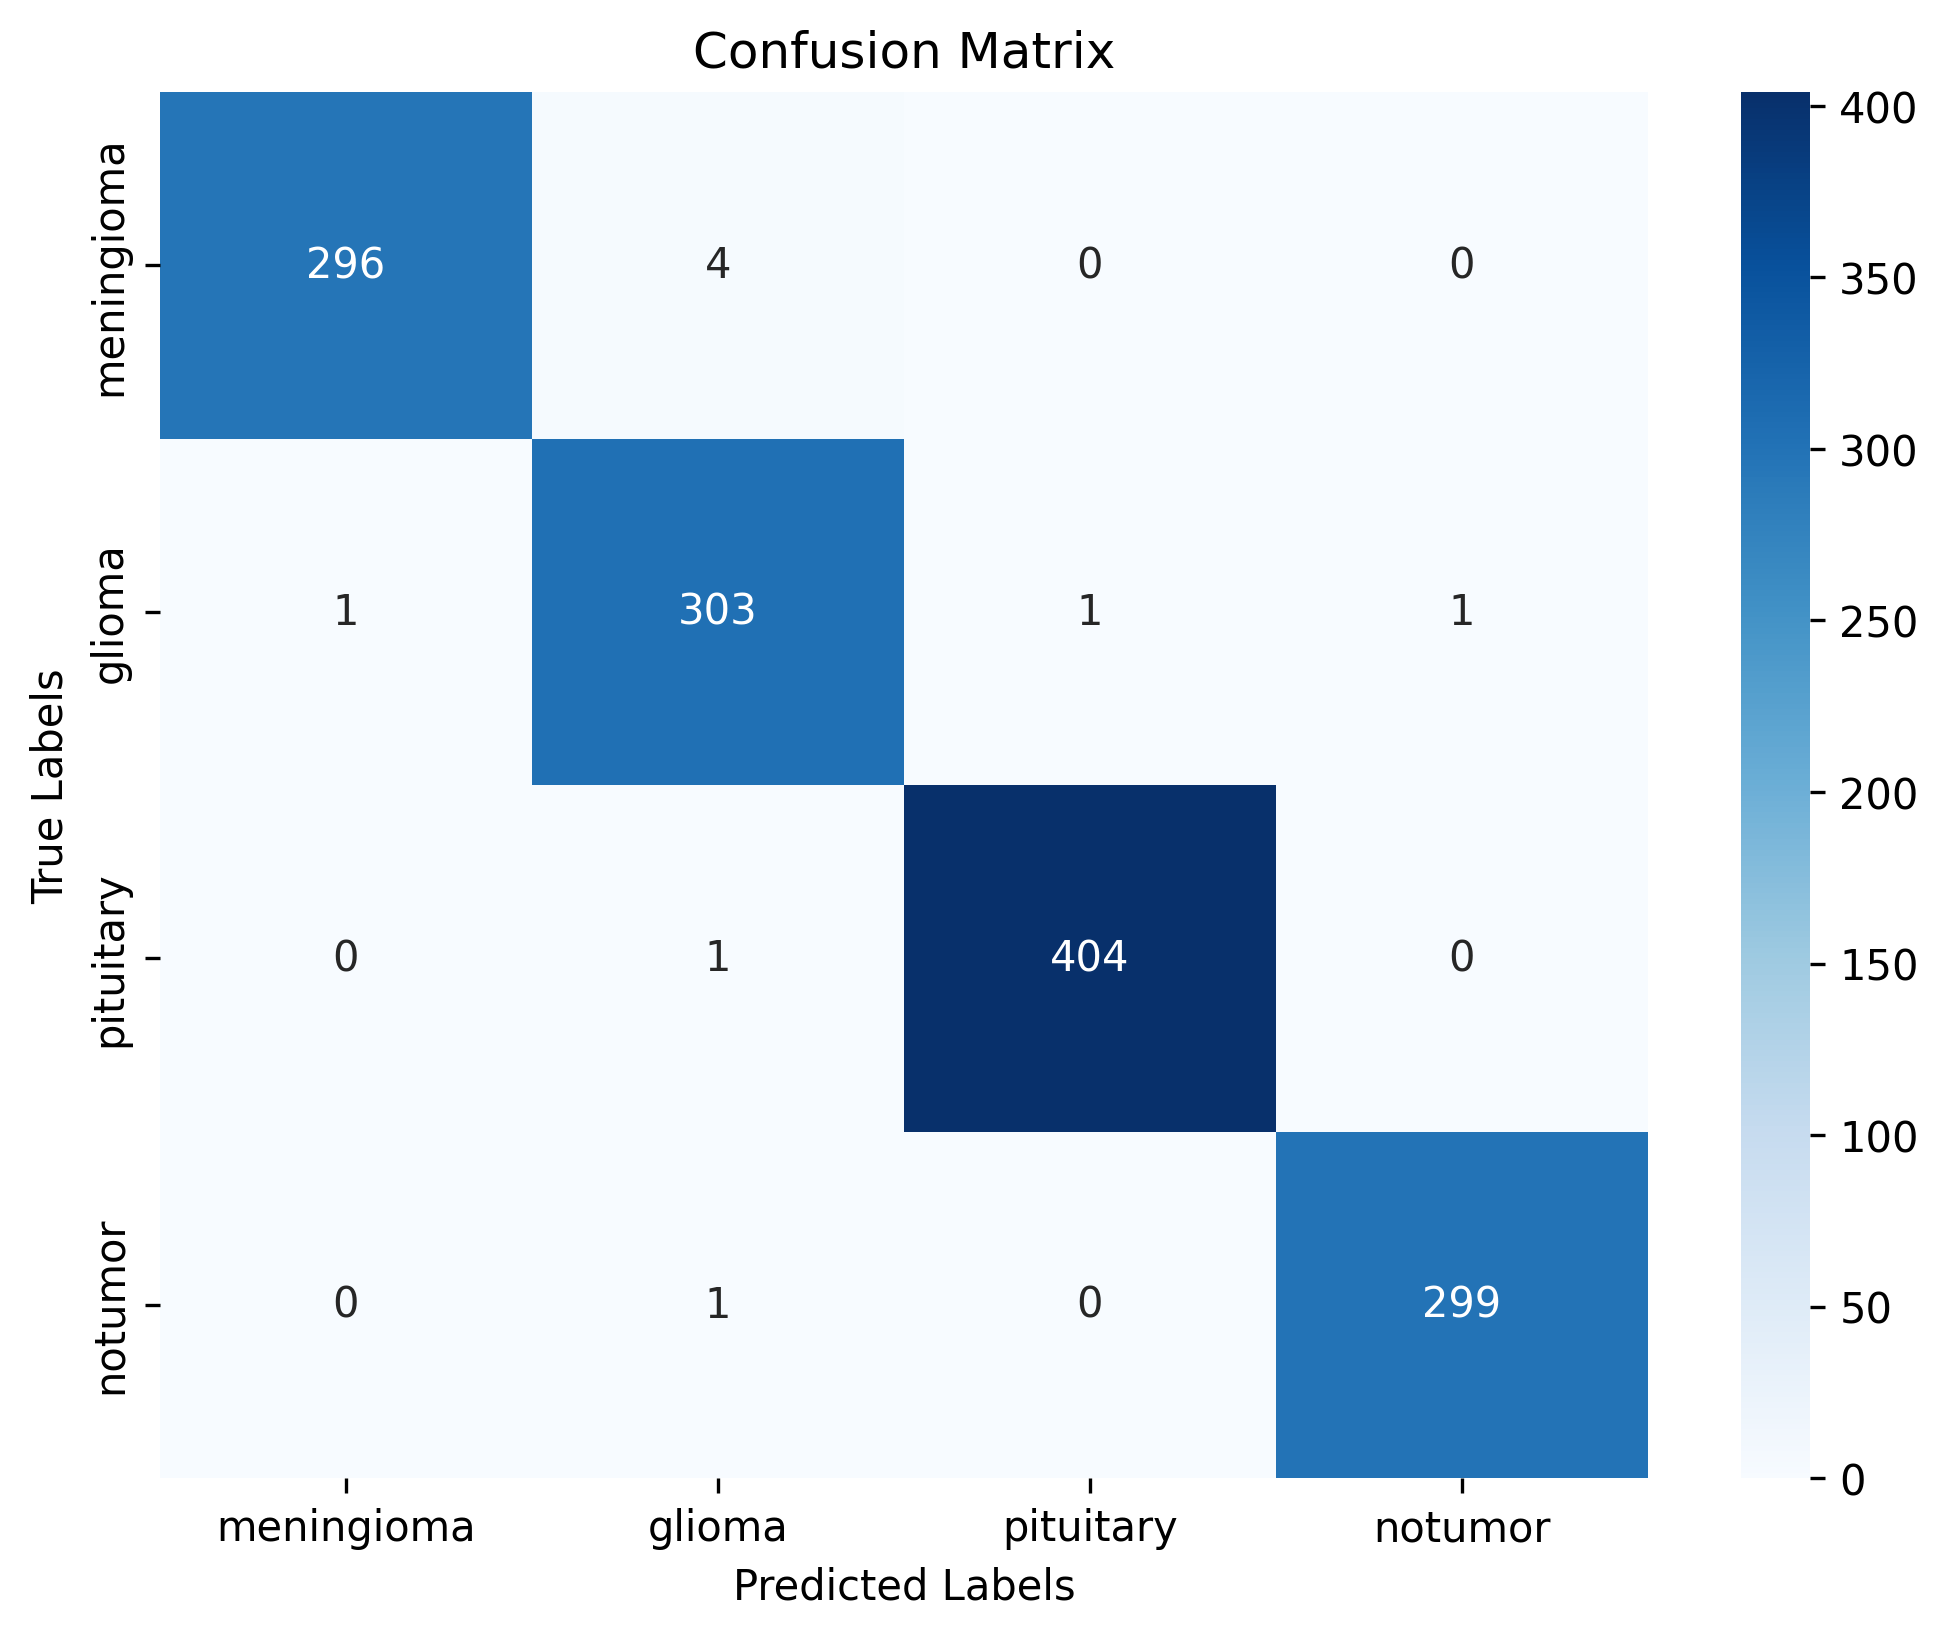

In [57]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model6.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### AlexNet

### 7. ResNet-101

In [58]:
with tpu_strategy.scope():

    base_model7 = tf.keras.applications.ResNet101(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model7.layers[:10]:
        layer.trainable = False
    x = base_model7.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions7 = Dense(4, activation='softmax')(x)
    model7 = Model(inputs=base_model7.inputs, outputs=predictions7)
    model7.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

171446536/171446536 [==============================] - 1s 0us/step


In [59]:
# model7.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [60]:
history7=model7.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model7.save('model7.h5')

Epoch 1/25


2023-08-06 05:10:32.986312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:10:34.612591: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7943

2023-08-06 05:12:45.961341: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:12:46.313848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 206s 3s/step - loss: 0.6179 - accuracy: 0.7943 - val_loss: 7917091.0000 - val_accuracy: 0.2811
Epoch 2/25
36/36 [==============================] - 6s 160ms/step - loss: 0.2128 - accuracy: 0.9276 - val_loss: 108486.3125 - val_accuracy: 0.2601
Epoch 3/25
36/36 [==============================] - 6s 160ms/step - loss: 0.1134 - accuracy: 0.9586 - val_loss: 9405.9883 - val_accuracy: 0.2828
Epoch 4/25
36/36 [==============================] - 6s 159ms/step - loss: 0.0817 - accuracy: 0.9735 - val_loss: 4323.9648 - val_accuracy: 0.2785
Epoch 5/25
36/36 [==============================] - 6s 165ms/step - loss: 0.0657 - accuracy: 0.9790 - val_loss: 237.6746 - val_accuracy: 0.2776
Epoch 6/25
36/36 [==============================] - 6s 161ms/step - loss: 0.0672 - accuracy: 0.9777 - val_loss: 173.1393 - val_accuracy: 0.2863
Epoch 7/25
36/36 [==============================] - 6s 161ms/step - loss: 0.0435 - accuracy: 0.9858 - val_loss: 3.0327 - val_accuracy: 0.60

In [61]:
resnet101_evaluation = model7.evaluate(val_ds)
resnet101_evaluation[1]*100

11/11 [==============================] - 12s 1s/step - loss: 17.2953 - accuracy: 0.6163


61.632341146469116

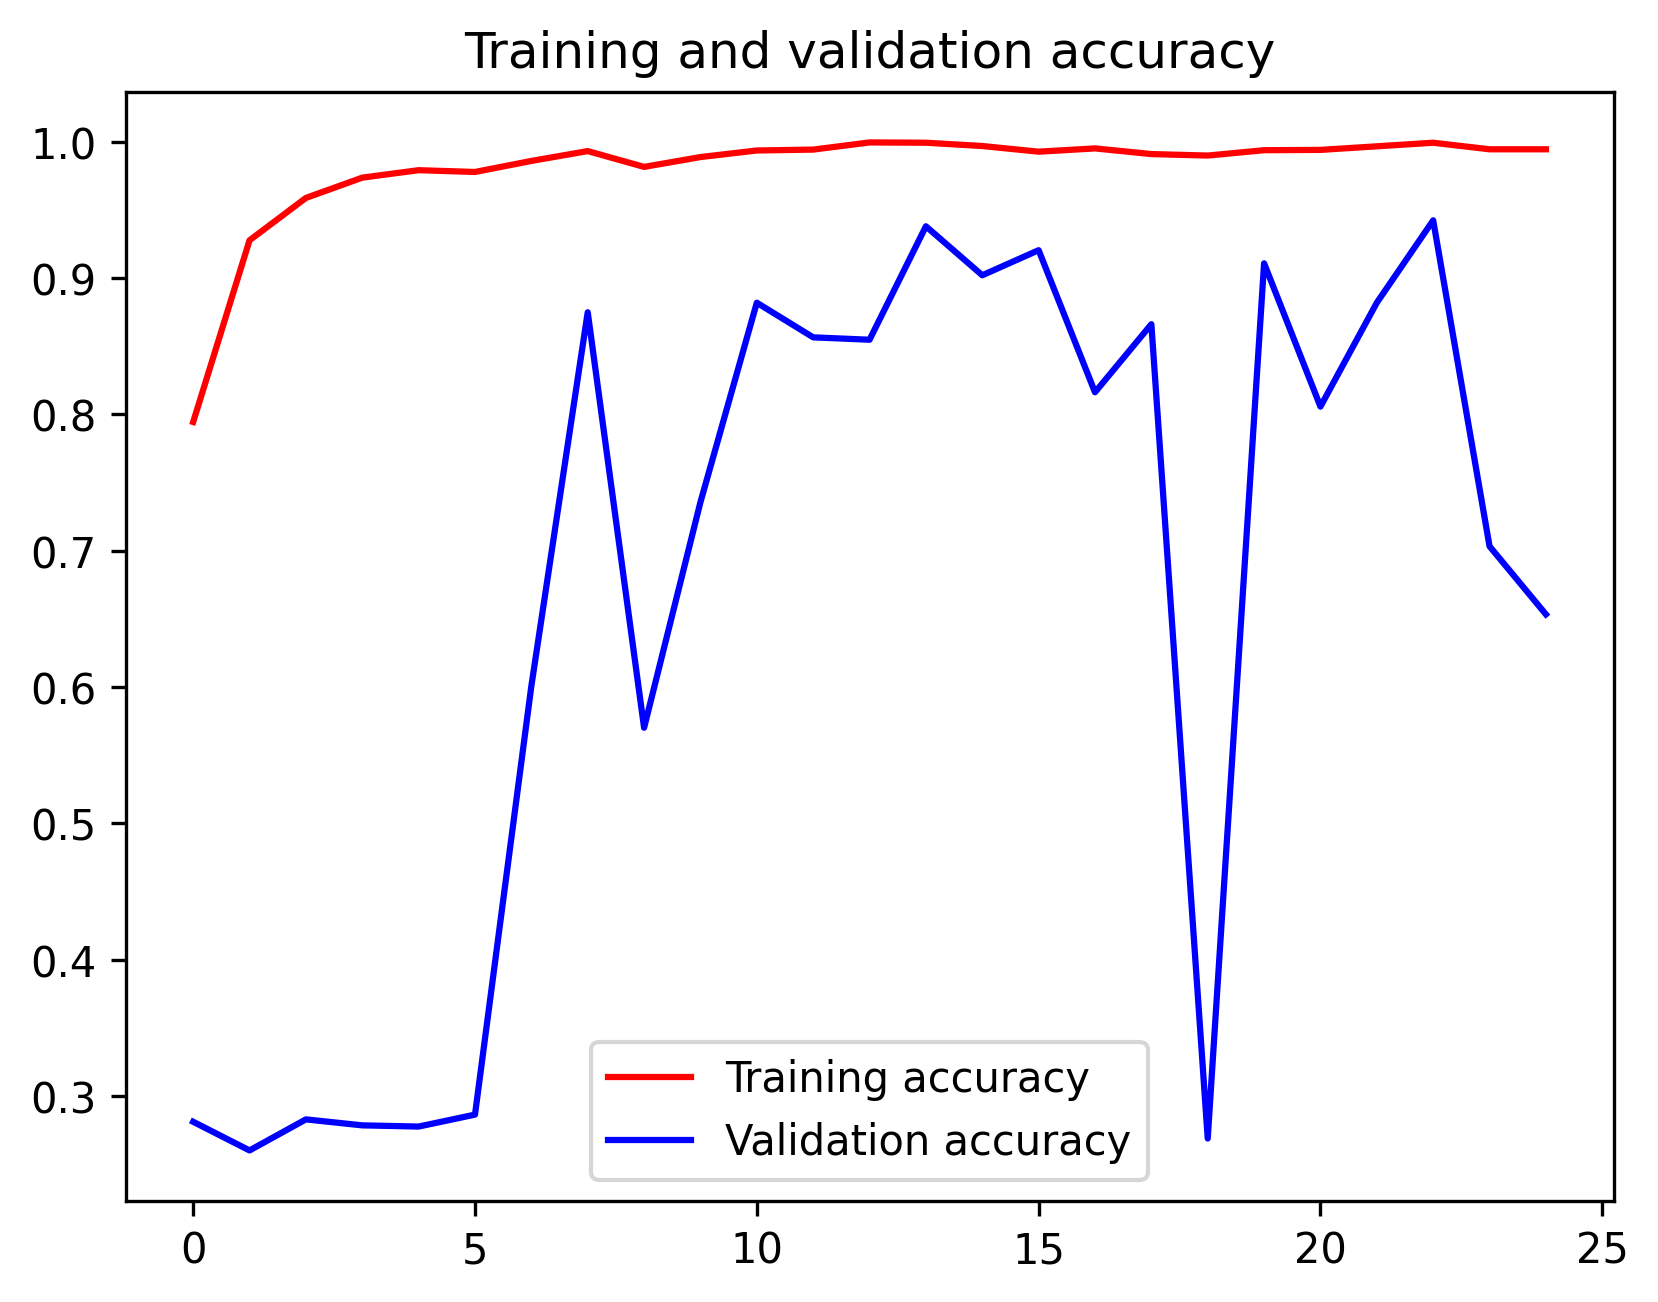

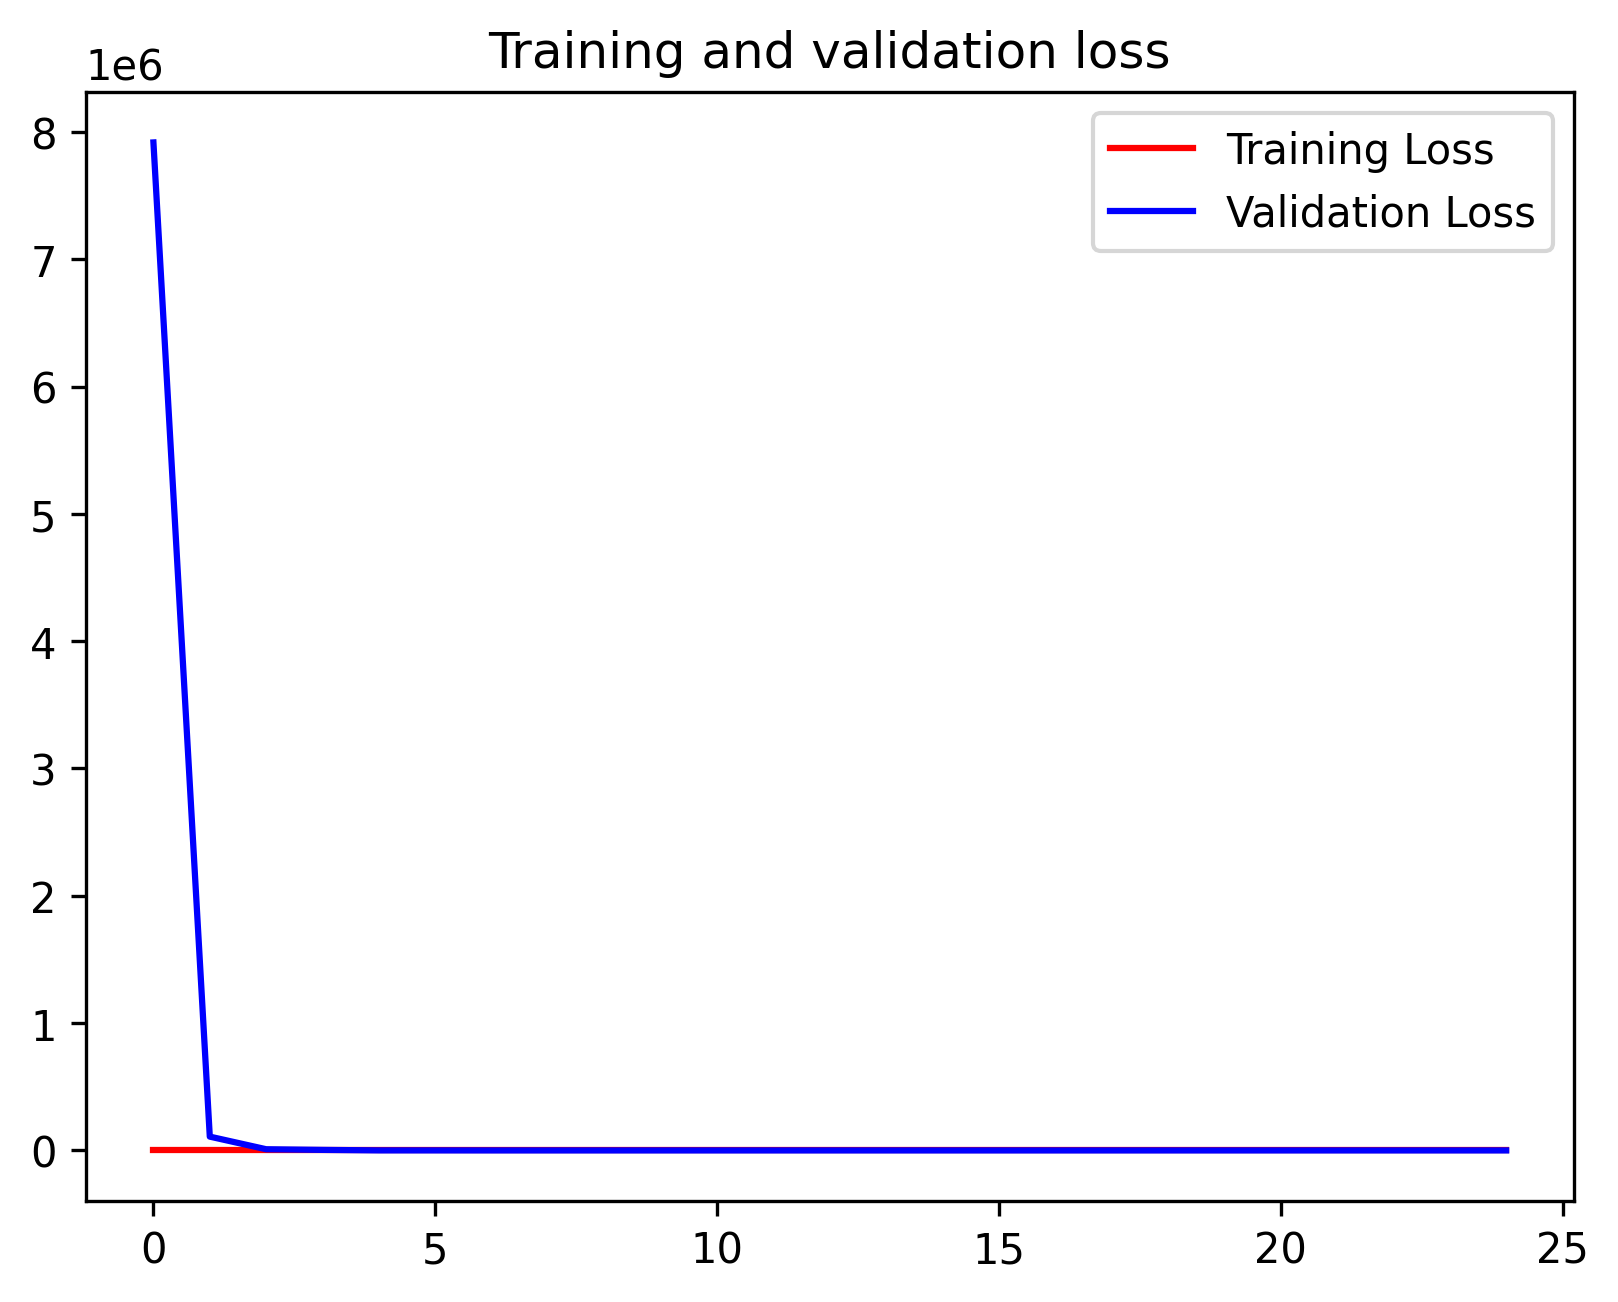

In [62]:
import matplotlib.pyplot as plt
acc = history7.history['accuracy']
val_acc = history7.history['val_accuracy']
loss = history7.history['loss']
val_loss = history7.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 05:15:58.534258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:15:58.785258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 1s 24ms/step


2023-08-06 05:16:24.921034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:16:25.301721: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 15s 15s/step
              precision    recall  f1-score   support

  meningioma       0.40      0.84      0.54       300
      glioma       0.64      0.77      0.70       306
   pituitary       0.97      0.31      0.47       405
     notumor       1.00      0.61      0.76       300

    accuracy                           0.61      1311
   macro avg       0.75      0.63      0.62      1311
weighted avg       0.77      0.61      0.61      1311



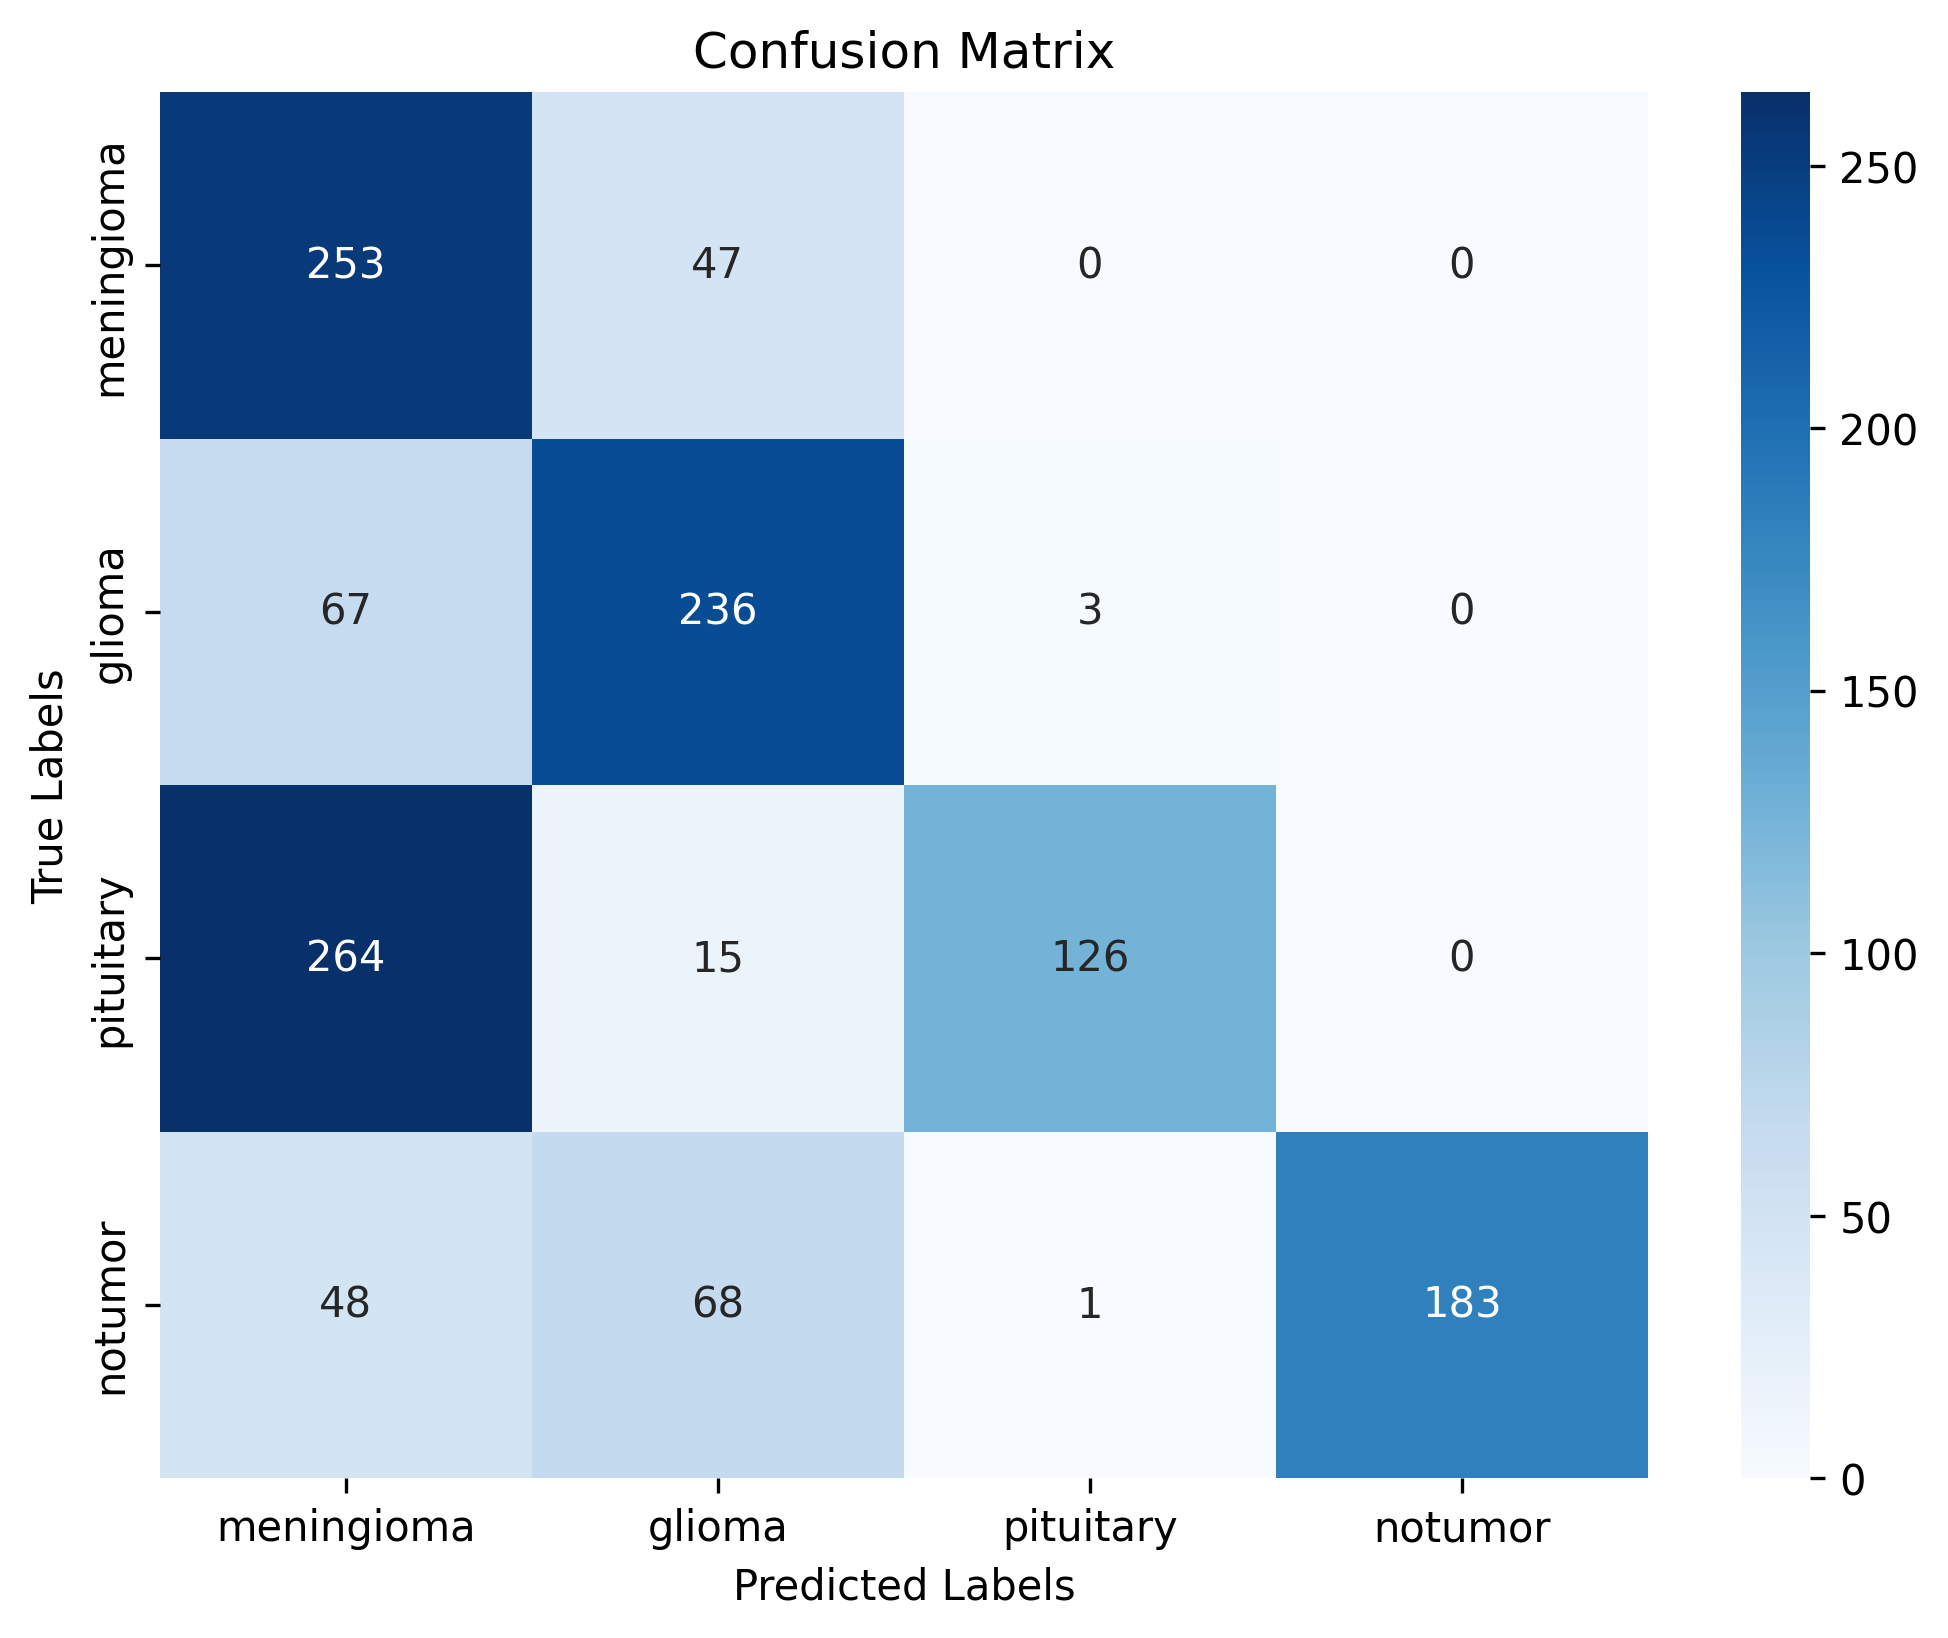

In [63]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model7.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Mask R-CNN

### 8. MobileNet

In [64]:
with tpu_strategy.scope():

    base_model8 = tf.keras.applications.MobileNet(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model8.layers[:10]:
        layer.trainable = False
    x = base_model8.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions8 = Dense(4, activation='softmax')(x)
    model8 = Model(inputs=base_model8.inputs, outputs=predictions8)
    model8.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

17225924/17225924 [==============================] - 0s 0us/step


In [65]:
# model8.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [66]:
history8=model8.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model8.save('model8.h5')

Epoch 1/25


2023-08-06 05:16:56.409504: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:16:56.745345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


35/36 [============================>.] - ETA: 0s - loss: 0.5627 - accuracy: 0.8208

2023-08-06 05:17:30.471828: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:17:30.623488: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 54s 812ms/step - loss: 0.5550 - accuracy: 0.8228 - val_loss: 7.9917 - val_accuracy: 0.2811
Epoch 2/25
36/36 [==============================] - 3s 79ms/step - loss: 0.1618 - accuracy: 0.9446 - val_loss: 1.9764 - val_accuracy: 0.5972
Epoch 3/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0589 - accuracy: 0.9801 - val_loss: 0.4648 - val_accuracy: 0.8835
Epoch 4/25
36/36 [==============================] - 3s 77ms/step - loss: 0.0537 - accuracy: 0.9812 - val_loss: 0.7626 - val_accuracy: 0.8511
Epoch 5/25
36/36 [==============================] - 3s 75ms/step - loss: 0.0604 - accuracy: 0.9790 - val_loss: 0.9282 - val_accuracy: 0.7758
Epoch 6/25
36/36 [==============================] - 3s 80ms/step - loss: 0.0480 - accuracy: 0.9823 - val_loss: 0.5782 - val_accuracy: 0.8319
Epoch 7/25
36/36 [==============================] - 3s 76ms/step - loss: 0.0381 - accuracy: 0.9867 - val_loss: 0.3552 - val_accuracy: 0.9046
Epoch 8/25
36/36 [====

In [67]:
mobilenet_evaluation = model8.evaluate(val_ds)
mobilenet_evaluation[1]*100

11/11 [==============================] - 6s 470ms/step - loss: 0.2365 - accuracy: 0.9596


95.95728516578674

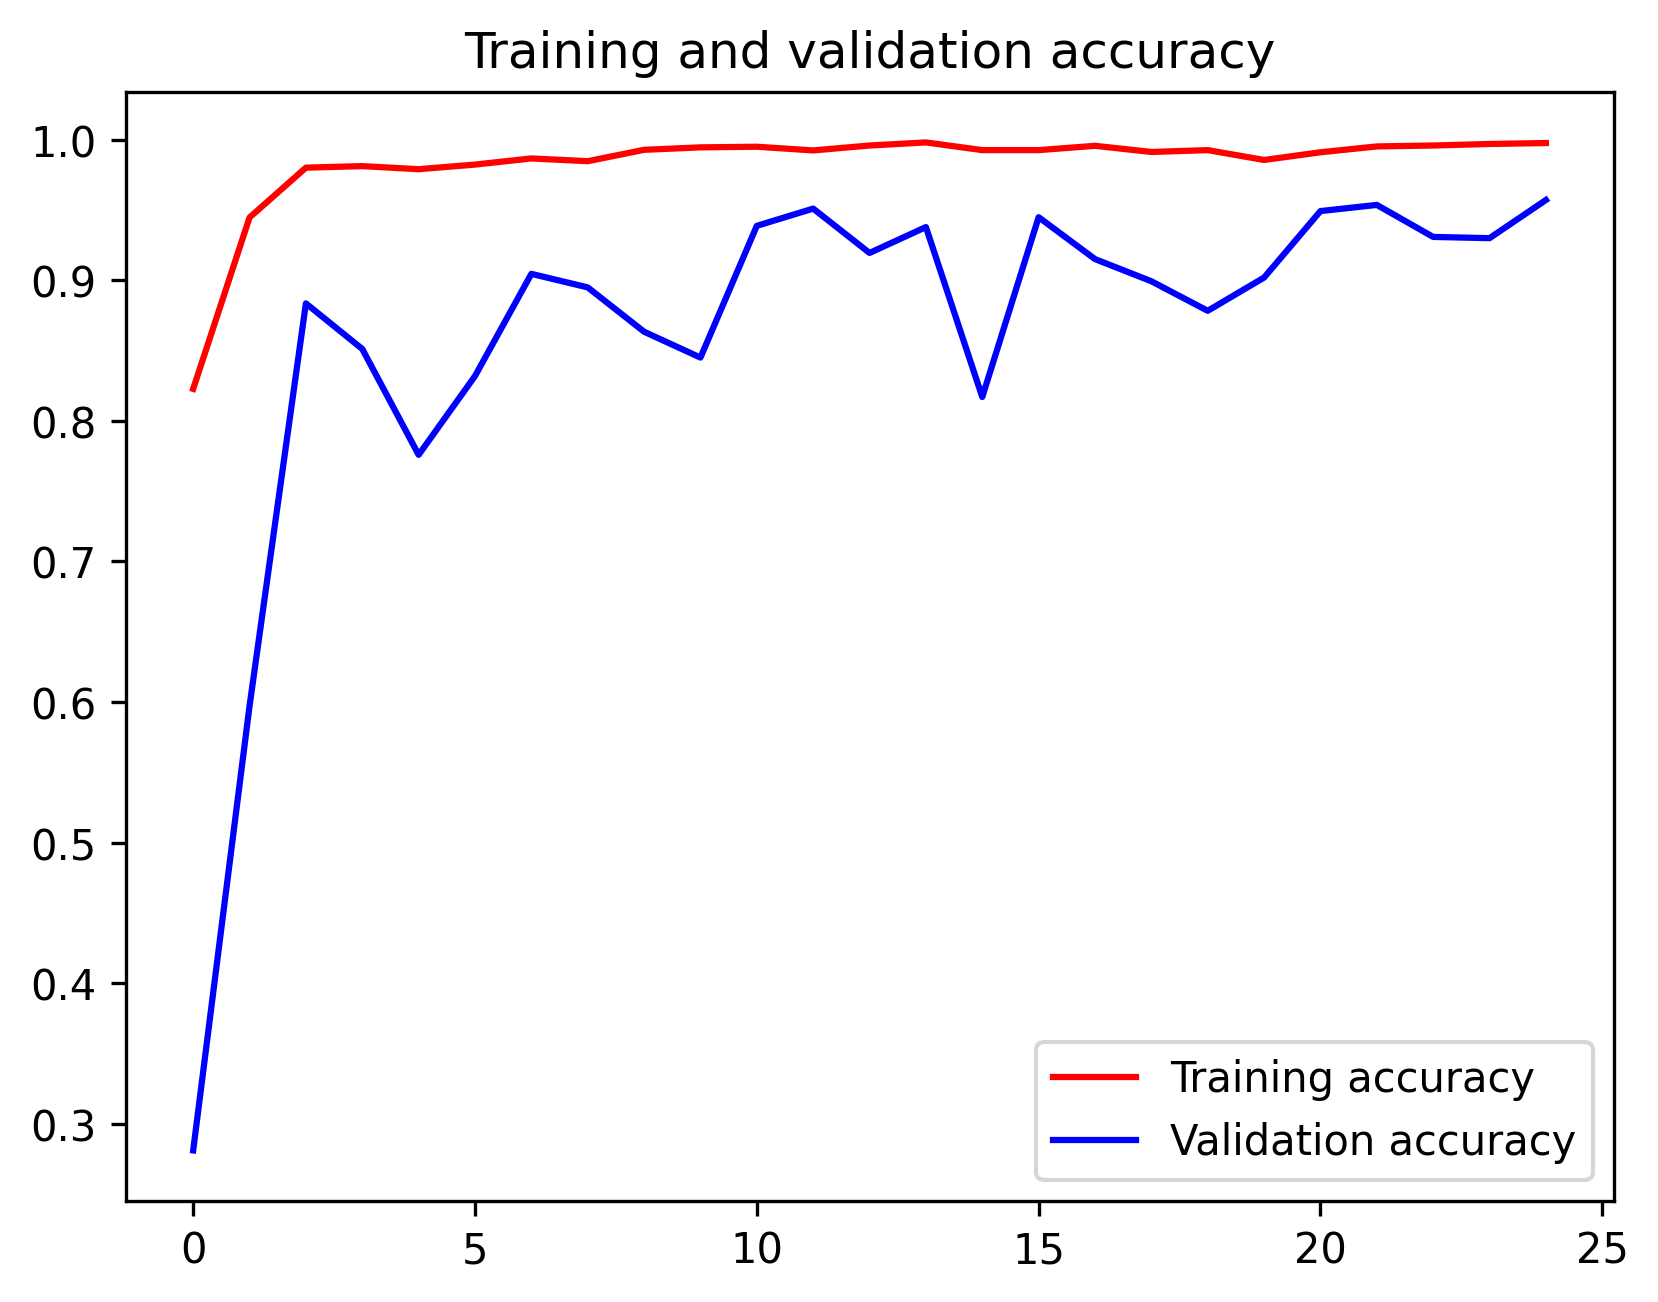

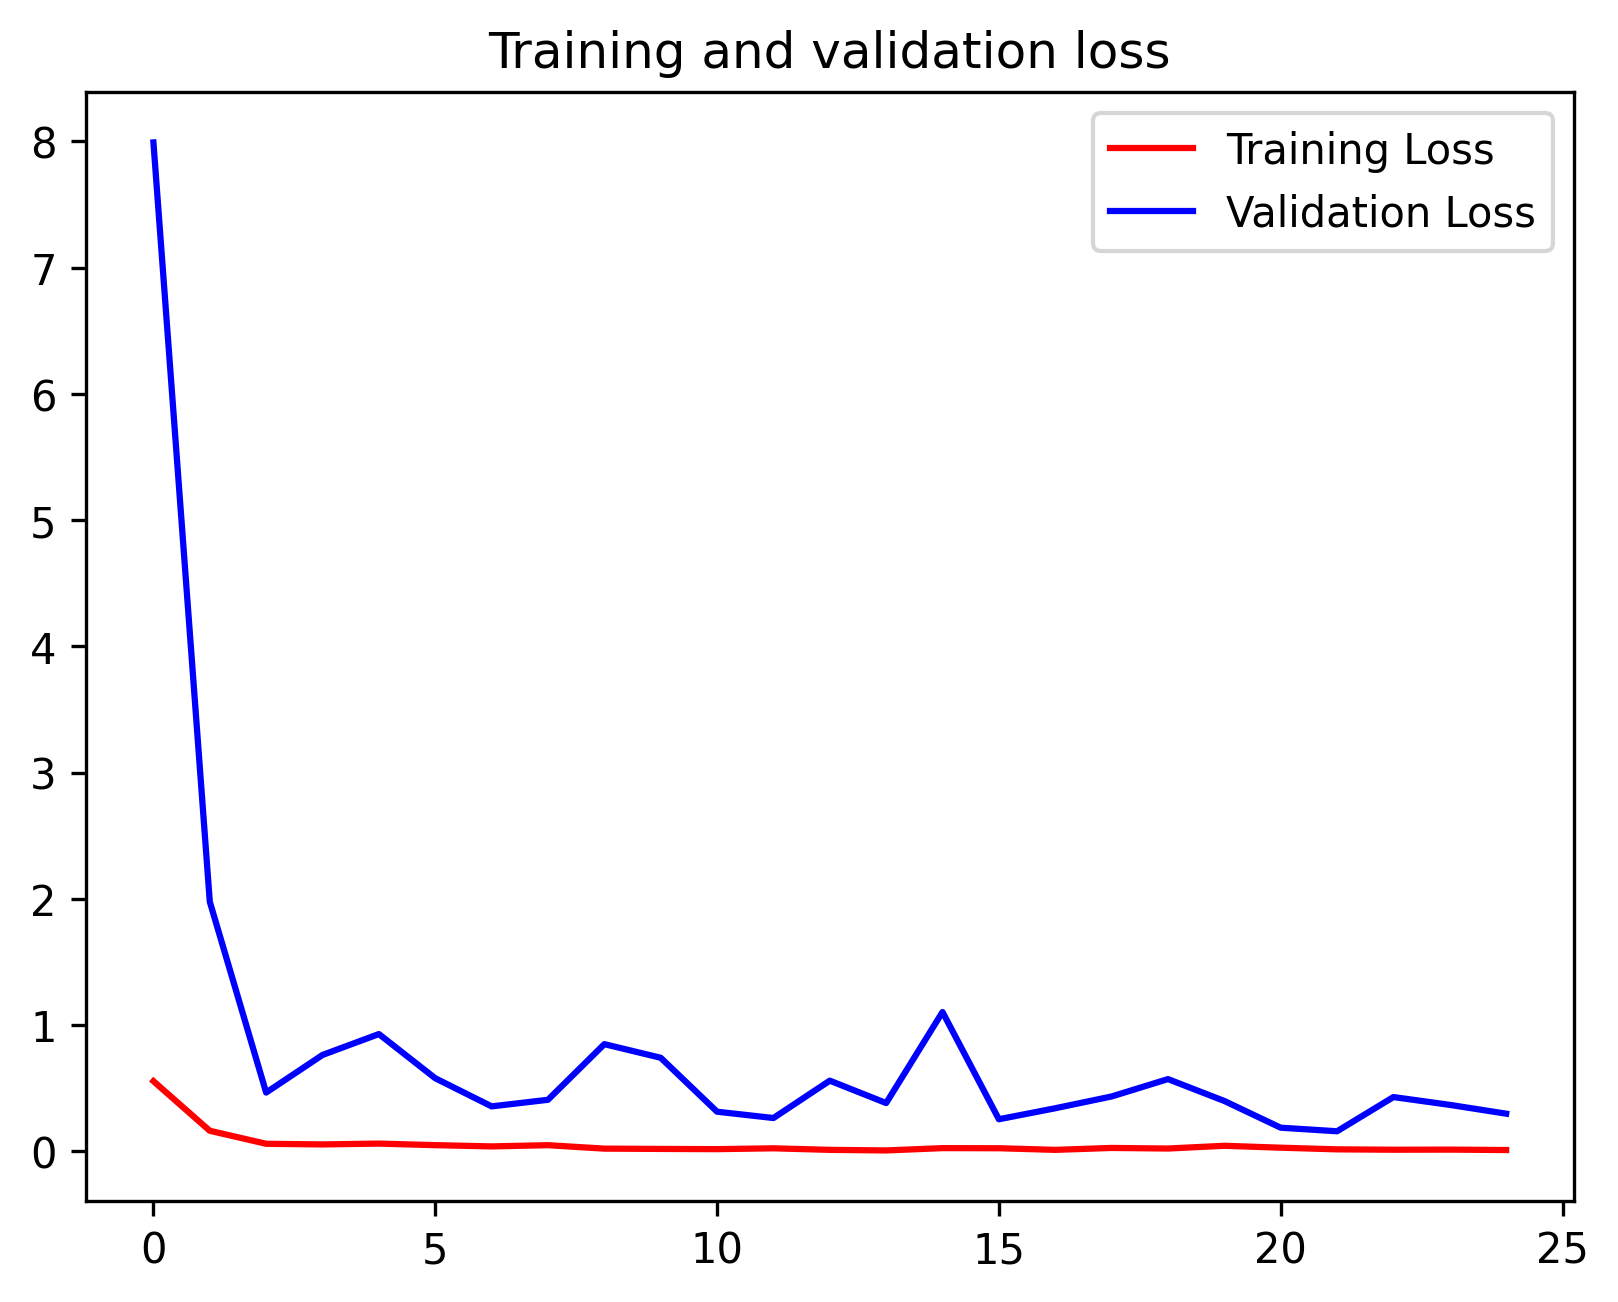

In [68]:
import matplotlib.pyplot as plt
acc = history8.history['accuracy']
val_acc = history8.history['val_accuracy']
loss = history8.history['loss']
val_loss = history8.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 05:19:08.121966: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:19:08.184933: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 11ms/step


2023-08-06 05:19:20.203727: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:19:20.325965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 6s 6s/step
              precision    recall  f1-score   support

  meningioma       0.92      0.99      0.95       300
      glioma       0.98      0.84      0.90       306
   pituitary       0.95      1.00      0.98       405
     notumor       0.99      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



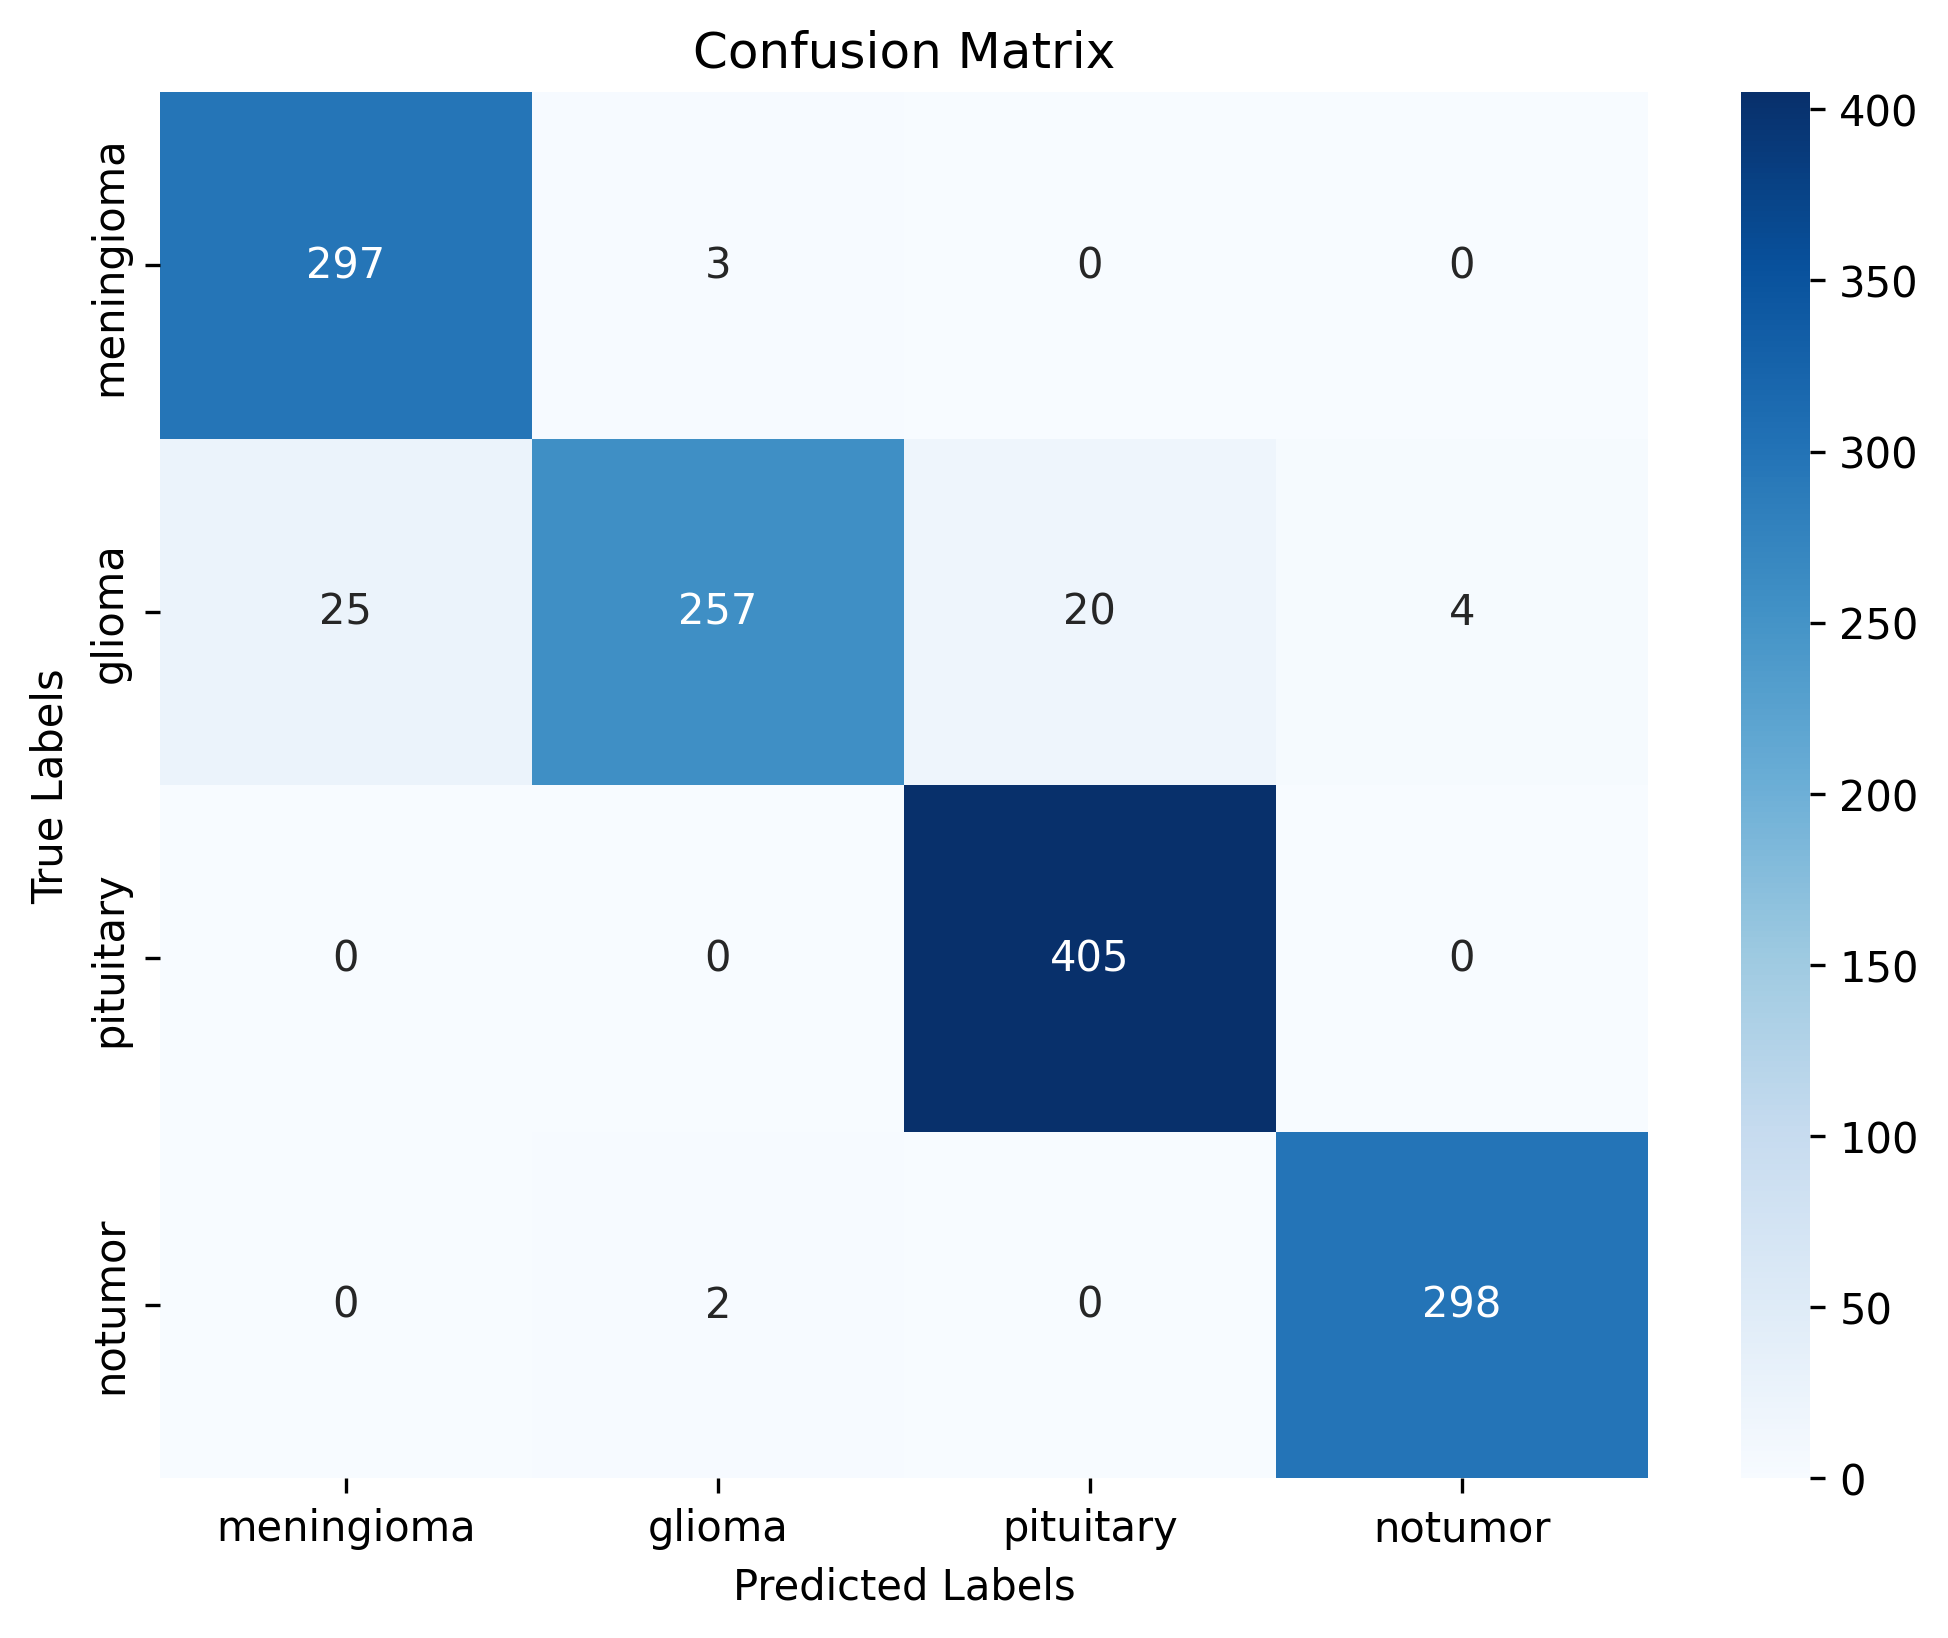

In [69]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model8.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### LSTM

### GoogLeNet

### 9. Xception

In [70]:
with tpu_strategy.scope():
    base_model9 = tf.keras.applications.Xception(
                        input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)
    # Freeze the first 10 layers
    for layer in base_model9.layers[:10]:
        layer.trainable = False
    x = base_model9.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    predictions9 = Dense(4, activation='softmax')(x)
    model9 = Model(inputs=base_model9.inputs, outputs=predictions9)
    model9.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

83683744/83683744 [==============================] - 1s 0us/step


In [71]:
# model9.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [72]:
history9=model9.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

model9.save('model9.h5')

Epoch 1/25


2023-08-06 05:20:02.713225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:20:03.341705: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.5144 - accuracy: 0.8042

2023-08-06 05:21:07.994431: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:21:08.209890: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 108s 2s/step - loss: 0.5144 - accuracy: 0.8042 - val_loss: 17.1897 - val_accuracy: 0.3363
Epoch 2/25
36/36 [==============================] - 4s 111ms/step - loss: 0.1775 - accuracy: 0.9470 - val_loss: 5.4190 - val_accuracy: 0.5166
Epoch 3/25
36/36 [==============================] - 4s 114ms/step - loss: 0.0725 - accuracy: 0.9751 - val_loss: 0.5783 - val_accuracy: 0.9037
Epoch 4/25
36/36 [==============================] - 4s 113ms/step - loss: 0.0375 - accuracy: 0.9871 - val_loss: 1.4702 - val_accuracy: 0.7933
Epoch 5/25
36/36 [==============================] - 4s 111ms/step - loss: 0.0588 - accuracy: 0.9816 - val_loss: 2.6868 - val_accuracy: 0.6874
Epoch 6/25
36/36 [==============================] - 4s 114ms/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.3771 - val_accuracy: 0.9378
Epoch 7/25
36/36 [==============================] - 4s 109ms/step - loss: 0.0357 - accuracy: 0.9875 - val_loss: 0.3279 - val_accuracy: 0.9370
Epoch 8/25
36/36 

In [73]:
xception_evaluation = model9.evaluate(val_ds)
xception_evaluation[1]*100

11/11 [==============================] - 8s 682ms/step - loss: 0.0676 - accuracy: 0.9908


99.08466935157776

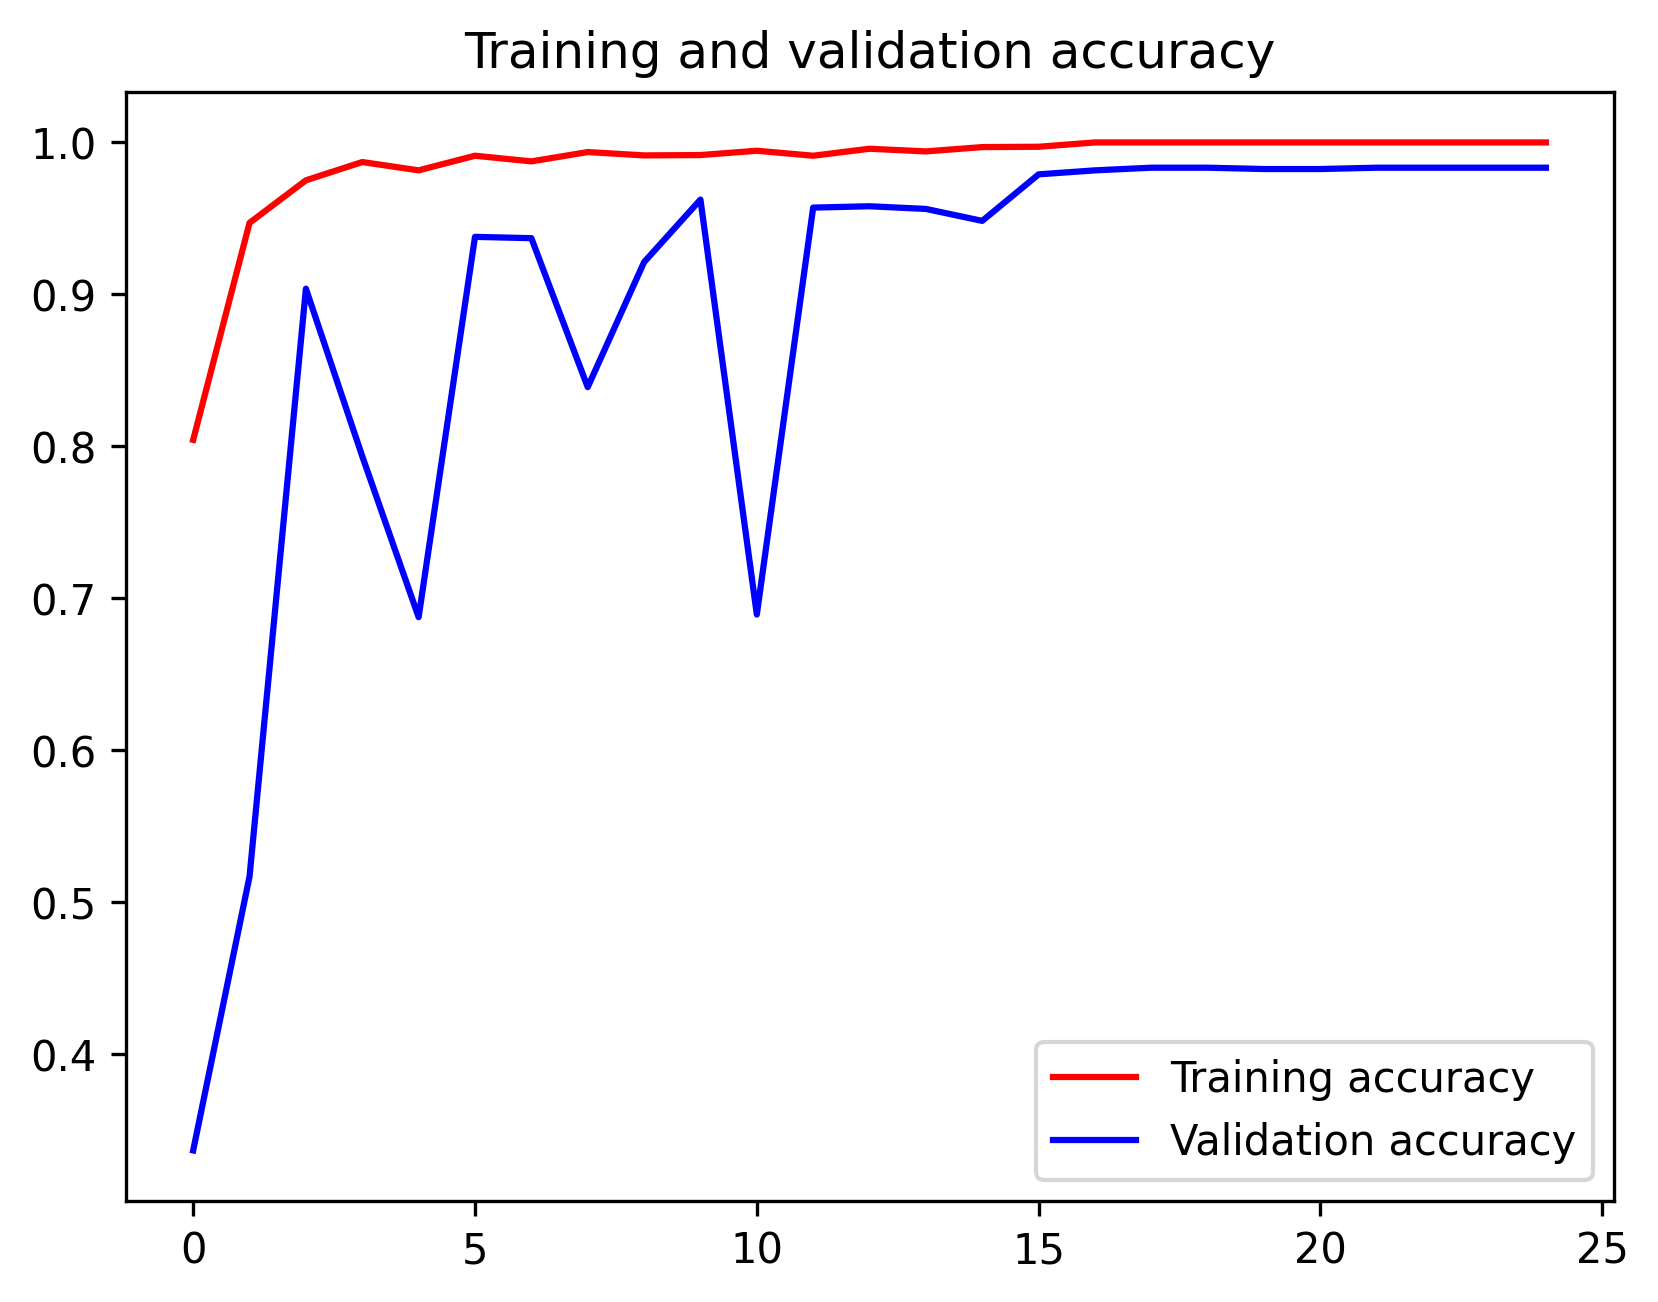

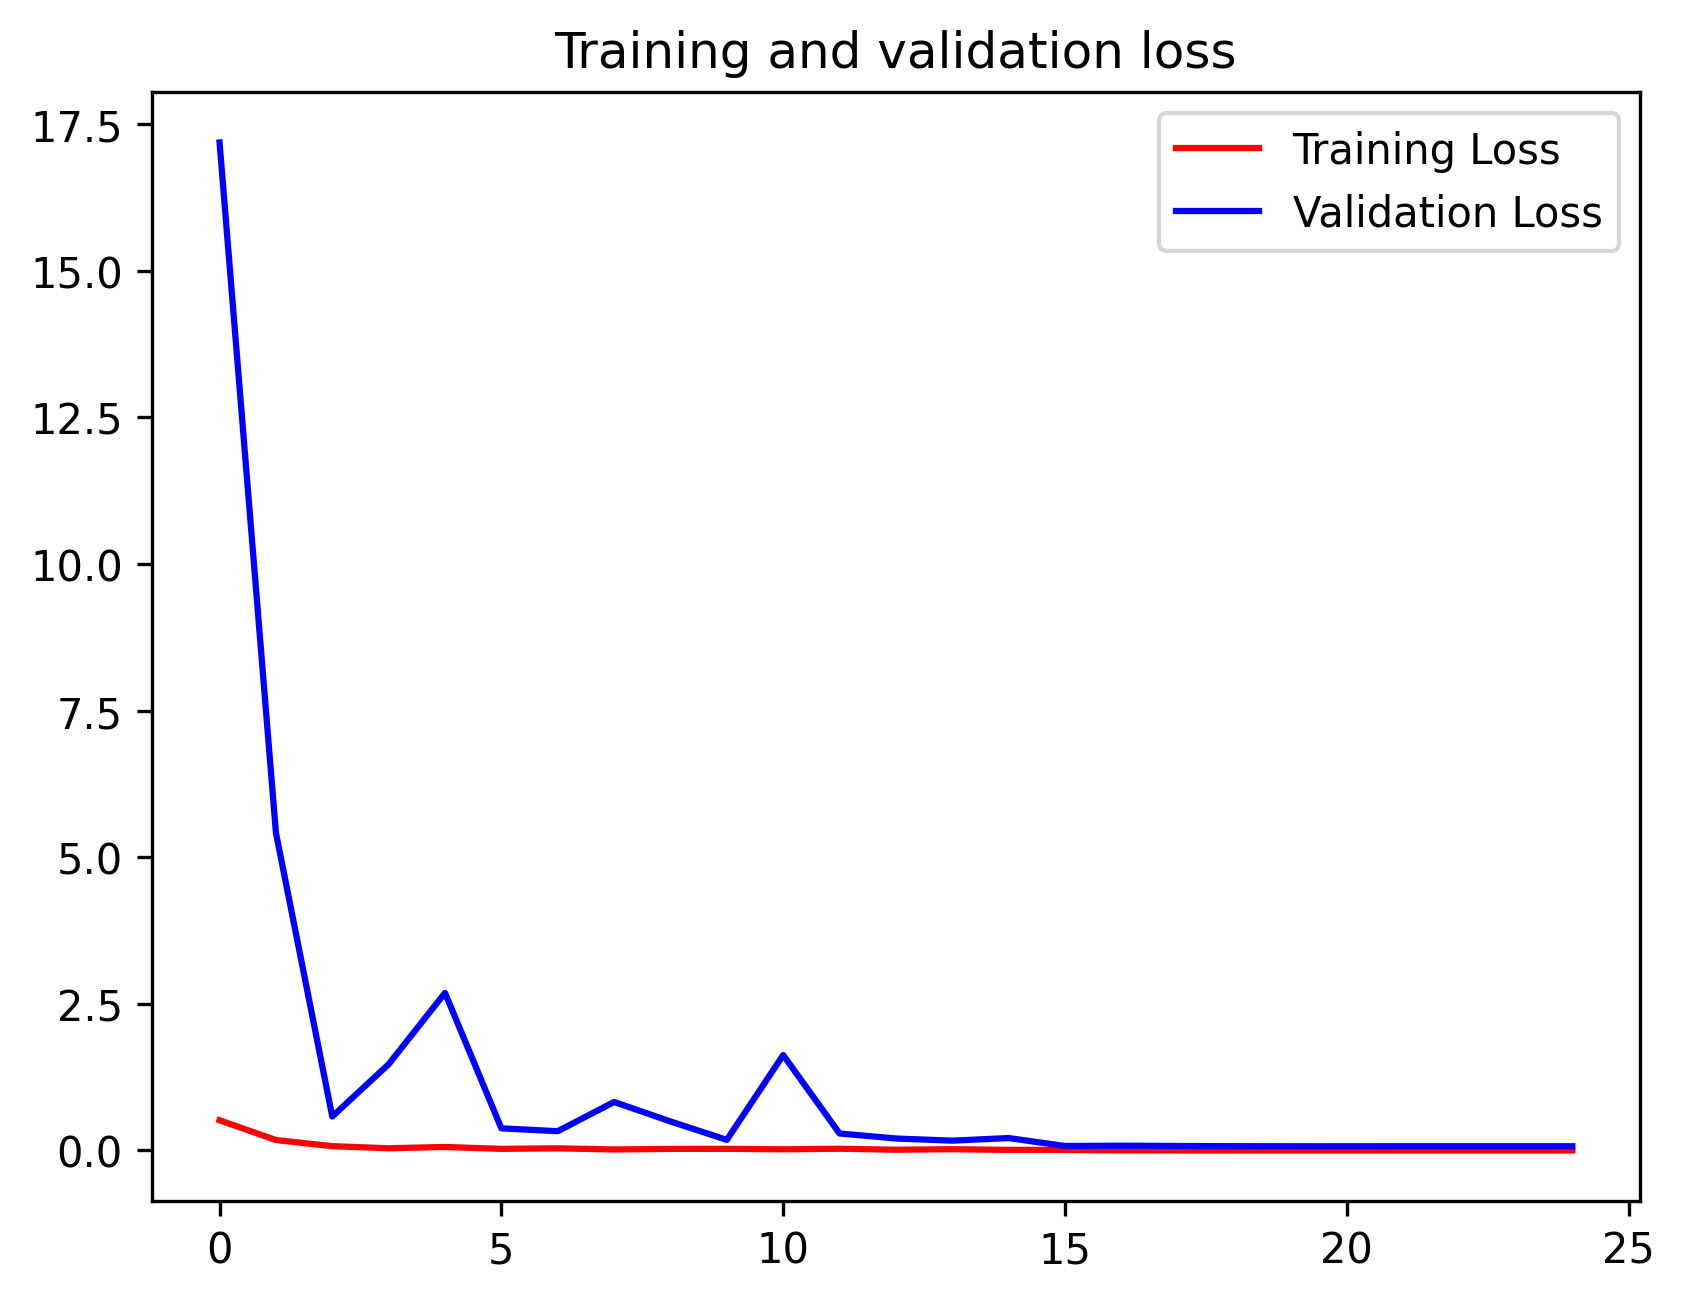

In [74]:
import matplotlib.pyplot as plt
acc = history9.history['accuracy']
val_acc = history9.history['val_accuracy']
loss = history9.history['loss']
val_loss = history9.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

2023-08-06 05:23:26.563730: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:23:26.666197: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 0s 15ms/step


2023-08-06 05:23:40.957563: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:23:41.145958: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 8s 8s/step
              precision    recall  f1-score   support

  meningioma       1.00      0.98      0.99       300
      glioma       0.97      0.99      0.98       306
   pituitary       1.00      1.00      1.00       405
     notumor       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



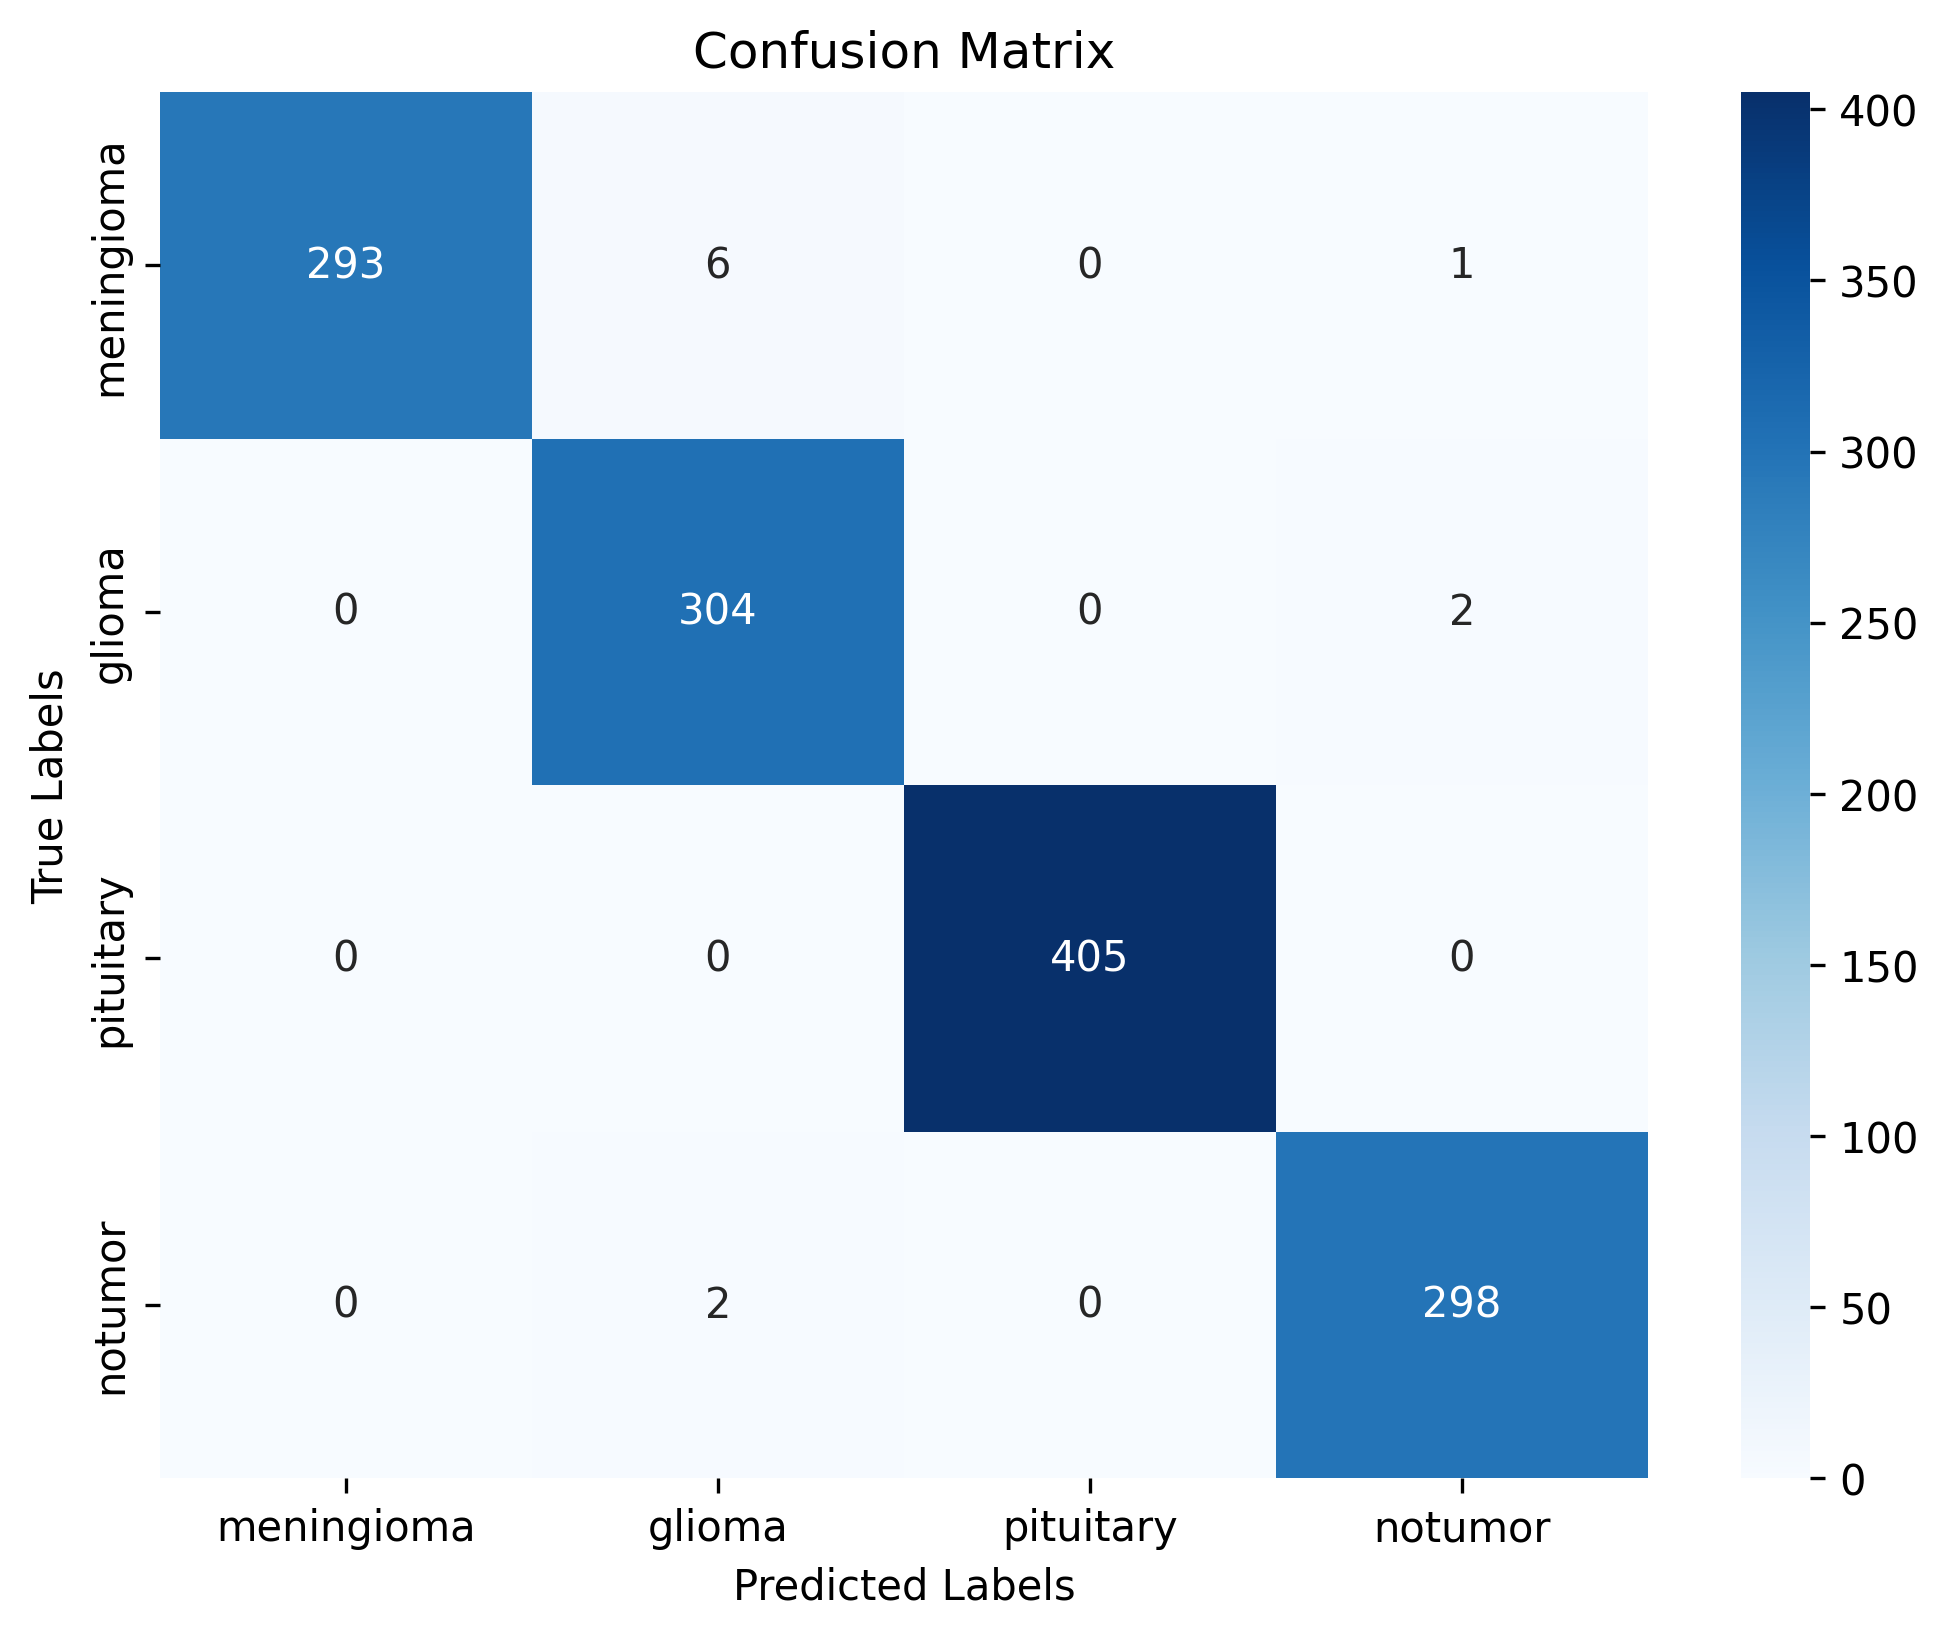

In [75]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have the 'val_ds' data set and 'model' loaded

# Create lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over 'val_ds' and make predictions
for images, labels in val_ds:
    true_labels.extend(labels)  # Use one-hot encoded labels directly
    predicted_labels.extend(np.argmax(model9.predict(images), axis=1))

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Generate the classification report
class_names = ['meningioma', 'glioma', 'pituitary', 'notumor']  # Update with your class names
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Generate the confusion matrix
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### MLP

#### Model Checkpoint

In [82]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Checkpoint to save best model per epoch

model_filepath = "/kaggle/working-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

### Building Ensemble Model

In [83]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
with tpu_strategy.scope():
    model_1 = load_model('/kaggle/working/model1.h5')
    model_1 = Model(inputs=model_1.inputs,
                    outputs=model_1.outputs,
                    name='name_of_model_1')

    model_2 = load_model('/kaggle/working/model2.h5')
    model_2 = Model(inputs=model_2.inputs,
                    outputs=model_2.outputs,
                    name='name_of_model_2')

#     model_3 = load_model('/kaggle/working/model3.h5')
#     model_3 = Model(inputs=model_3.inputs,
#                     outputs=model_3.outputs,
#                     name='name_of_model_3')


    model_4 = load_model('/kaggle/working/model4.h5')
    model_4 = Model(inputs=model_4.inputs,
                    outputs=model_4.outputs,
                    name='name_of_model_4')
    
    model_6 = load_model('/kaggle/working/model6.h5')
    model_6 = Model(inputs=model_6.inputs,
                    outputs=model_6.outputs,
                    name='name_of_model_6')
    
    model_8 = load_model('/kaggle/working/model8.h5')
    model_8 = Model(inputs=model_8.inputs,
                    outputs=model_8.outputs,
                    name='name_of_model_8')
    
    model_9 = load_model('/kaggle/working/model9.h5')
    model_9 = Model(inputs=model_9.inputs,
                    outputs=model_9.outputs,
                    name='name_of_model_9')
    
    

    models = [model_1, model_2, model_4,model_6,model_8,model_9]
    model_input = Input(shape=(224, 224, 3))
    model_outputs = [model(model_input) for model in models]
    ensemble_output = Average()(model_outputs)
    ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')
    ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [84]:
# ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])


In [85]:
history=ensemble_model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=25)

Epoch 1/25


2023-08-06 05:37:57.357406: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:38:01.897294: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9963

2023-08-06 05:44:11.880598: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:44:12.816690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


36/36 [==============================] - 557s 7s/step - loss: 0.0883 - accuracy: 0.9963 - val_loss: 0.4507 - val_accuracy: 0.7925
Epoch 2/25
36/36 [==============================] - 13s 374ms/step - loss: 0.1457 - accuracy: 0.9958 - val_loss: 0.6582 - val_accuracy: 0.8327
Epoch 3/25
36/36 [==============================] - 13s 377ms/step - loss: 0.2075 - accuracy: 0.9926 - val_loss: 0.8244 - val_accuracy: 0.7715
Epoch 4/25
36/36 [==============================] - 13s 374ms/step - loss: 0.2364 - accuracy: 0.9947 - val_loss: 0.5520 - val_accuracy: 0.9413
Epoch 5/25
36/36 [==============================] - 13s 371ms/step - loss: 0.2328 - accuracy: 0.9954 - val_loss: 0.5641 - val_accuracy: 0.9545
Epoch 6/25
36/36 [==============================] - 13s 369ms/step - loss: 0.2439 - accuracy: 0.9930 - val_loss: 0.6468 - val_accuracy: 0.6970
Epoch 7/25
36/36 [==============================] - 13s 374ms/step - loss: 0.2663 - accuracy: 0.9834 - val_loss: 0.9419 - val_accuracy: 0.4571
Epoch 8/25
3

In [86]:
ensemble_evaluation = ensemble_model.evaluate(val_ds)
ensemble_evaluation[1]*100

11/11 [==============================] - 26s 3s/step - loss: 0.2739 - accuracy: 0.9718


97.17772603034973

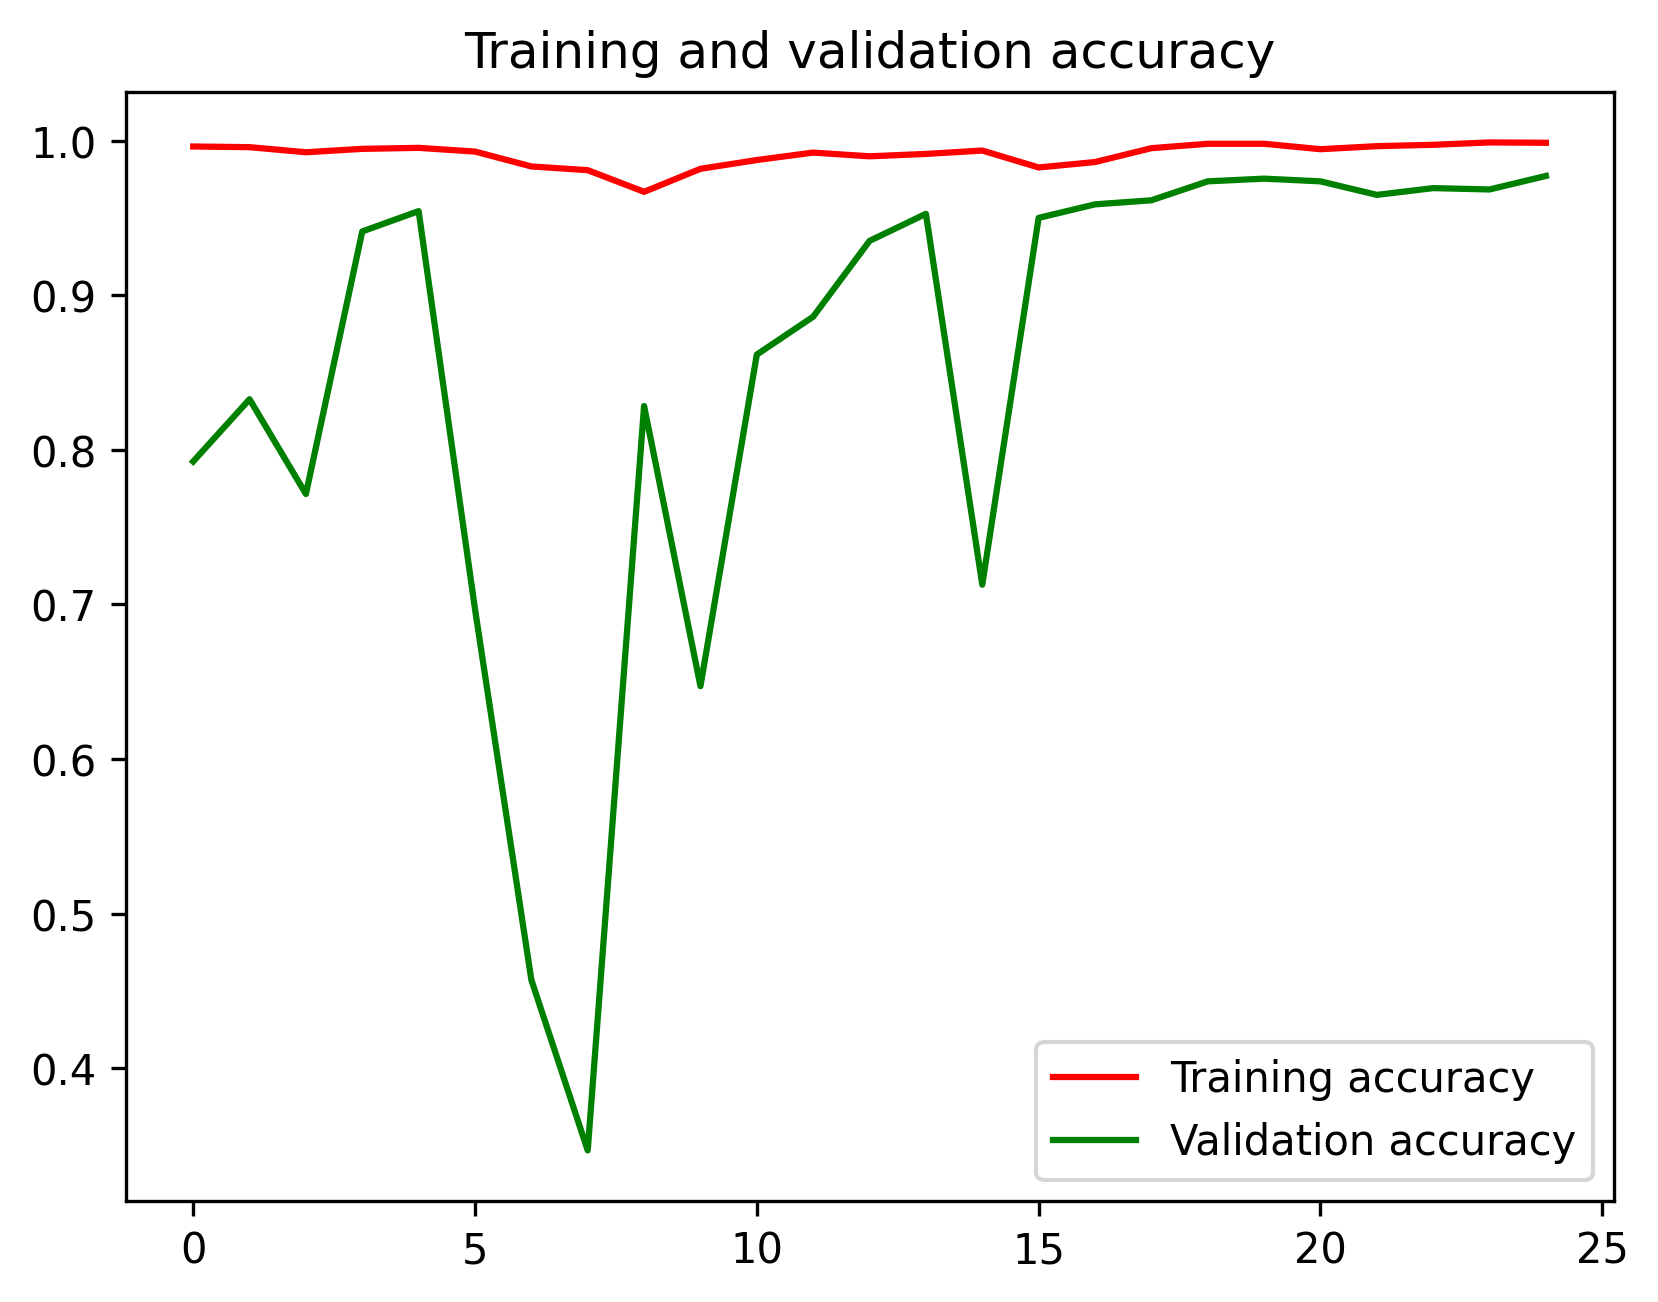

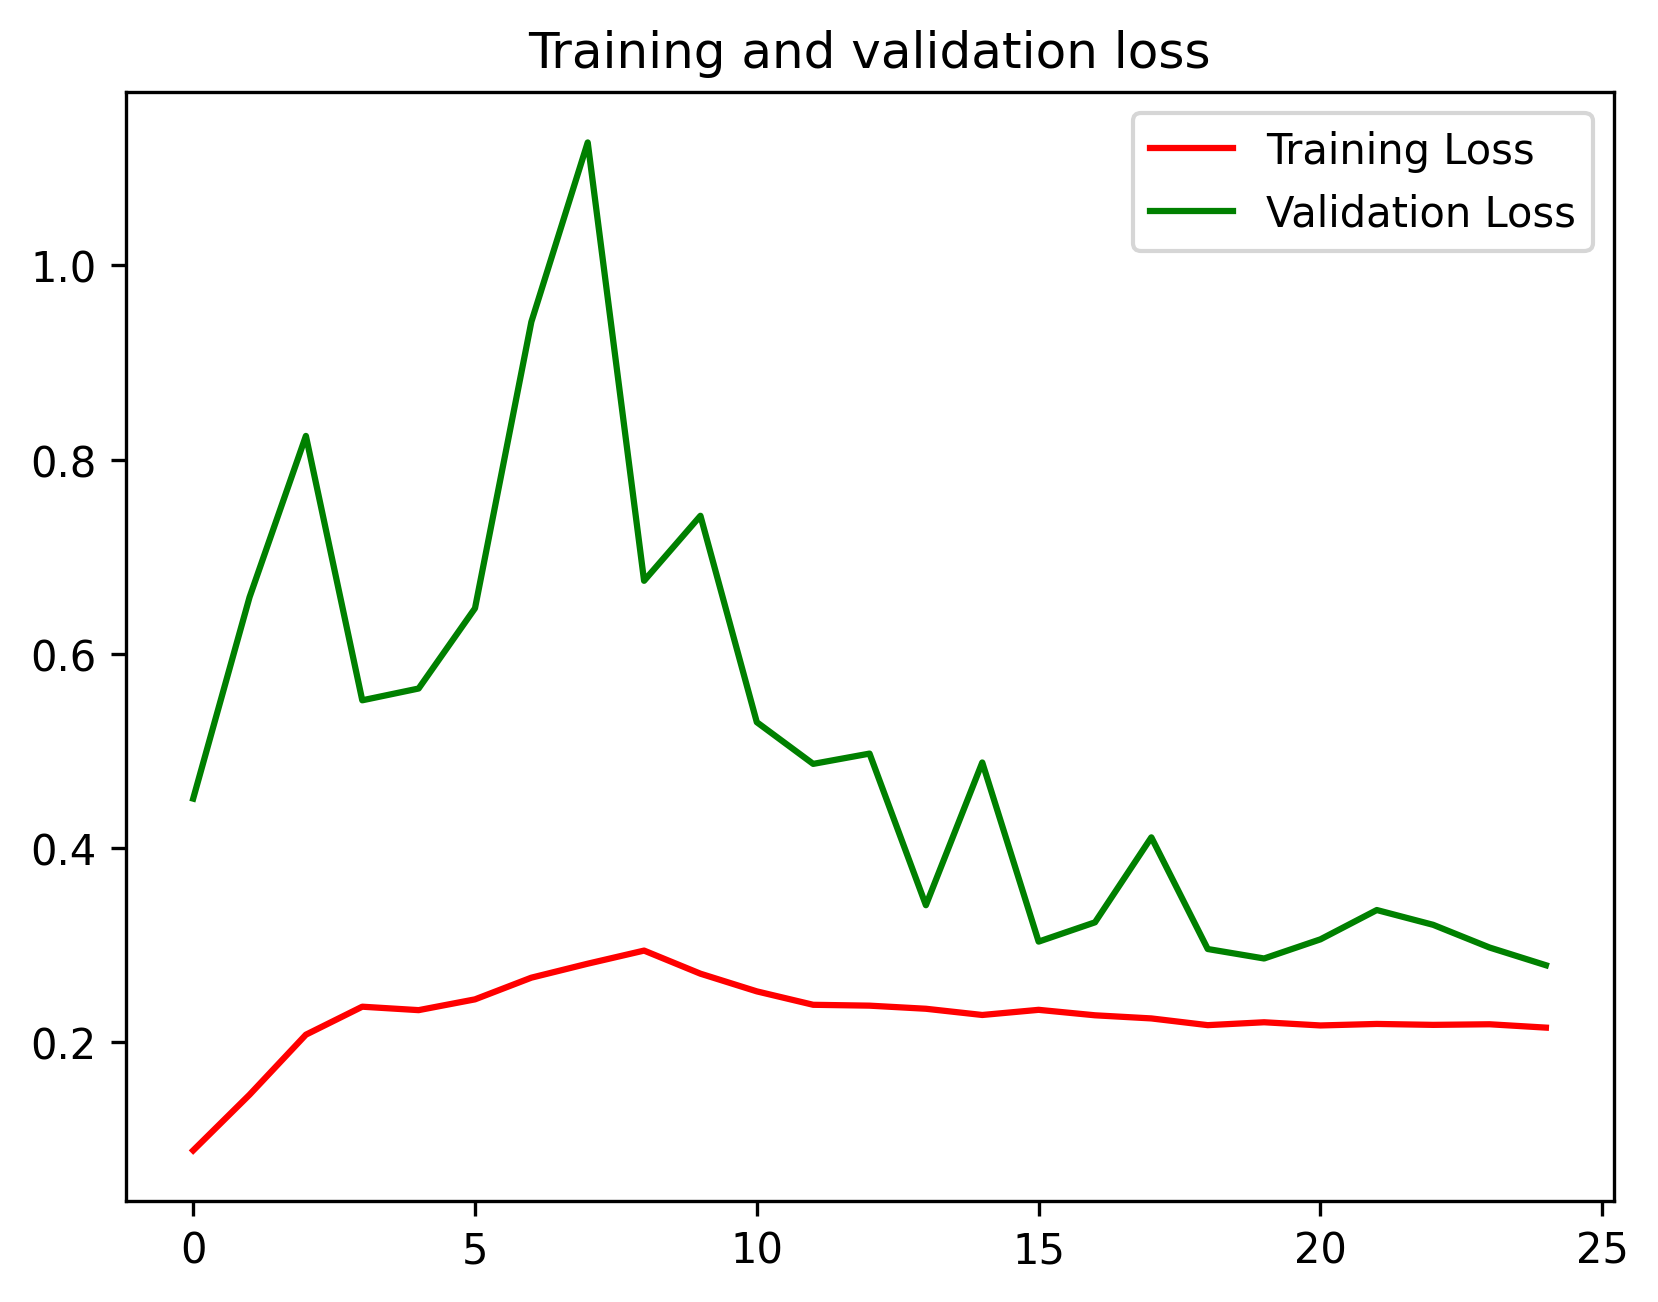

In [87]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [88]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
print(train_label.shape)

test_label = np.concatenate([y for x, y in test_ds], axis=0)
print(test_label.shape)

(4570,)
(1142,)


/tmp/ipykernel_15/865114918.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = ensemble_model.predict_generator(test_ds, 1600)
2023-08-06 05:51:17.898758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-08-06 05:51:18.774845: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


Confusion Matrix
[[225   6   0   0]
 [  0 284  12   1]
 [  1   0 320   0]
 [  0   2   4 287]]
Classification Report
              precision    recall  f1-score   support

      glioma       1.00      0.97      0.98       231
  meningioma       0.97      0.96      0.96       297
     notumor       0.95      1.00      0.97       321
   pituitary       1.00      0.98      0.99       293

    accuracy                           0.98      1142
   macro avg       0.98      0.98      0.98      1142
weighted avg       0.98      0.98      0.98      1142



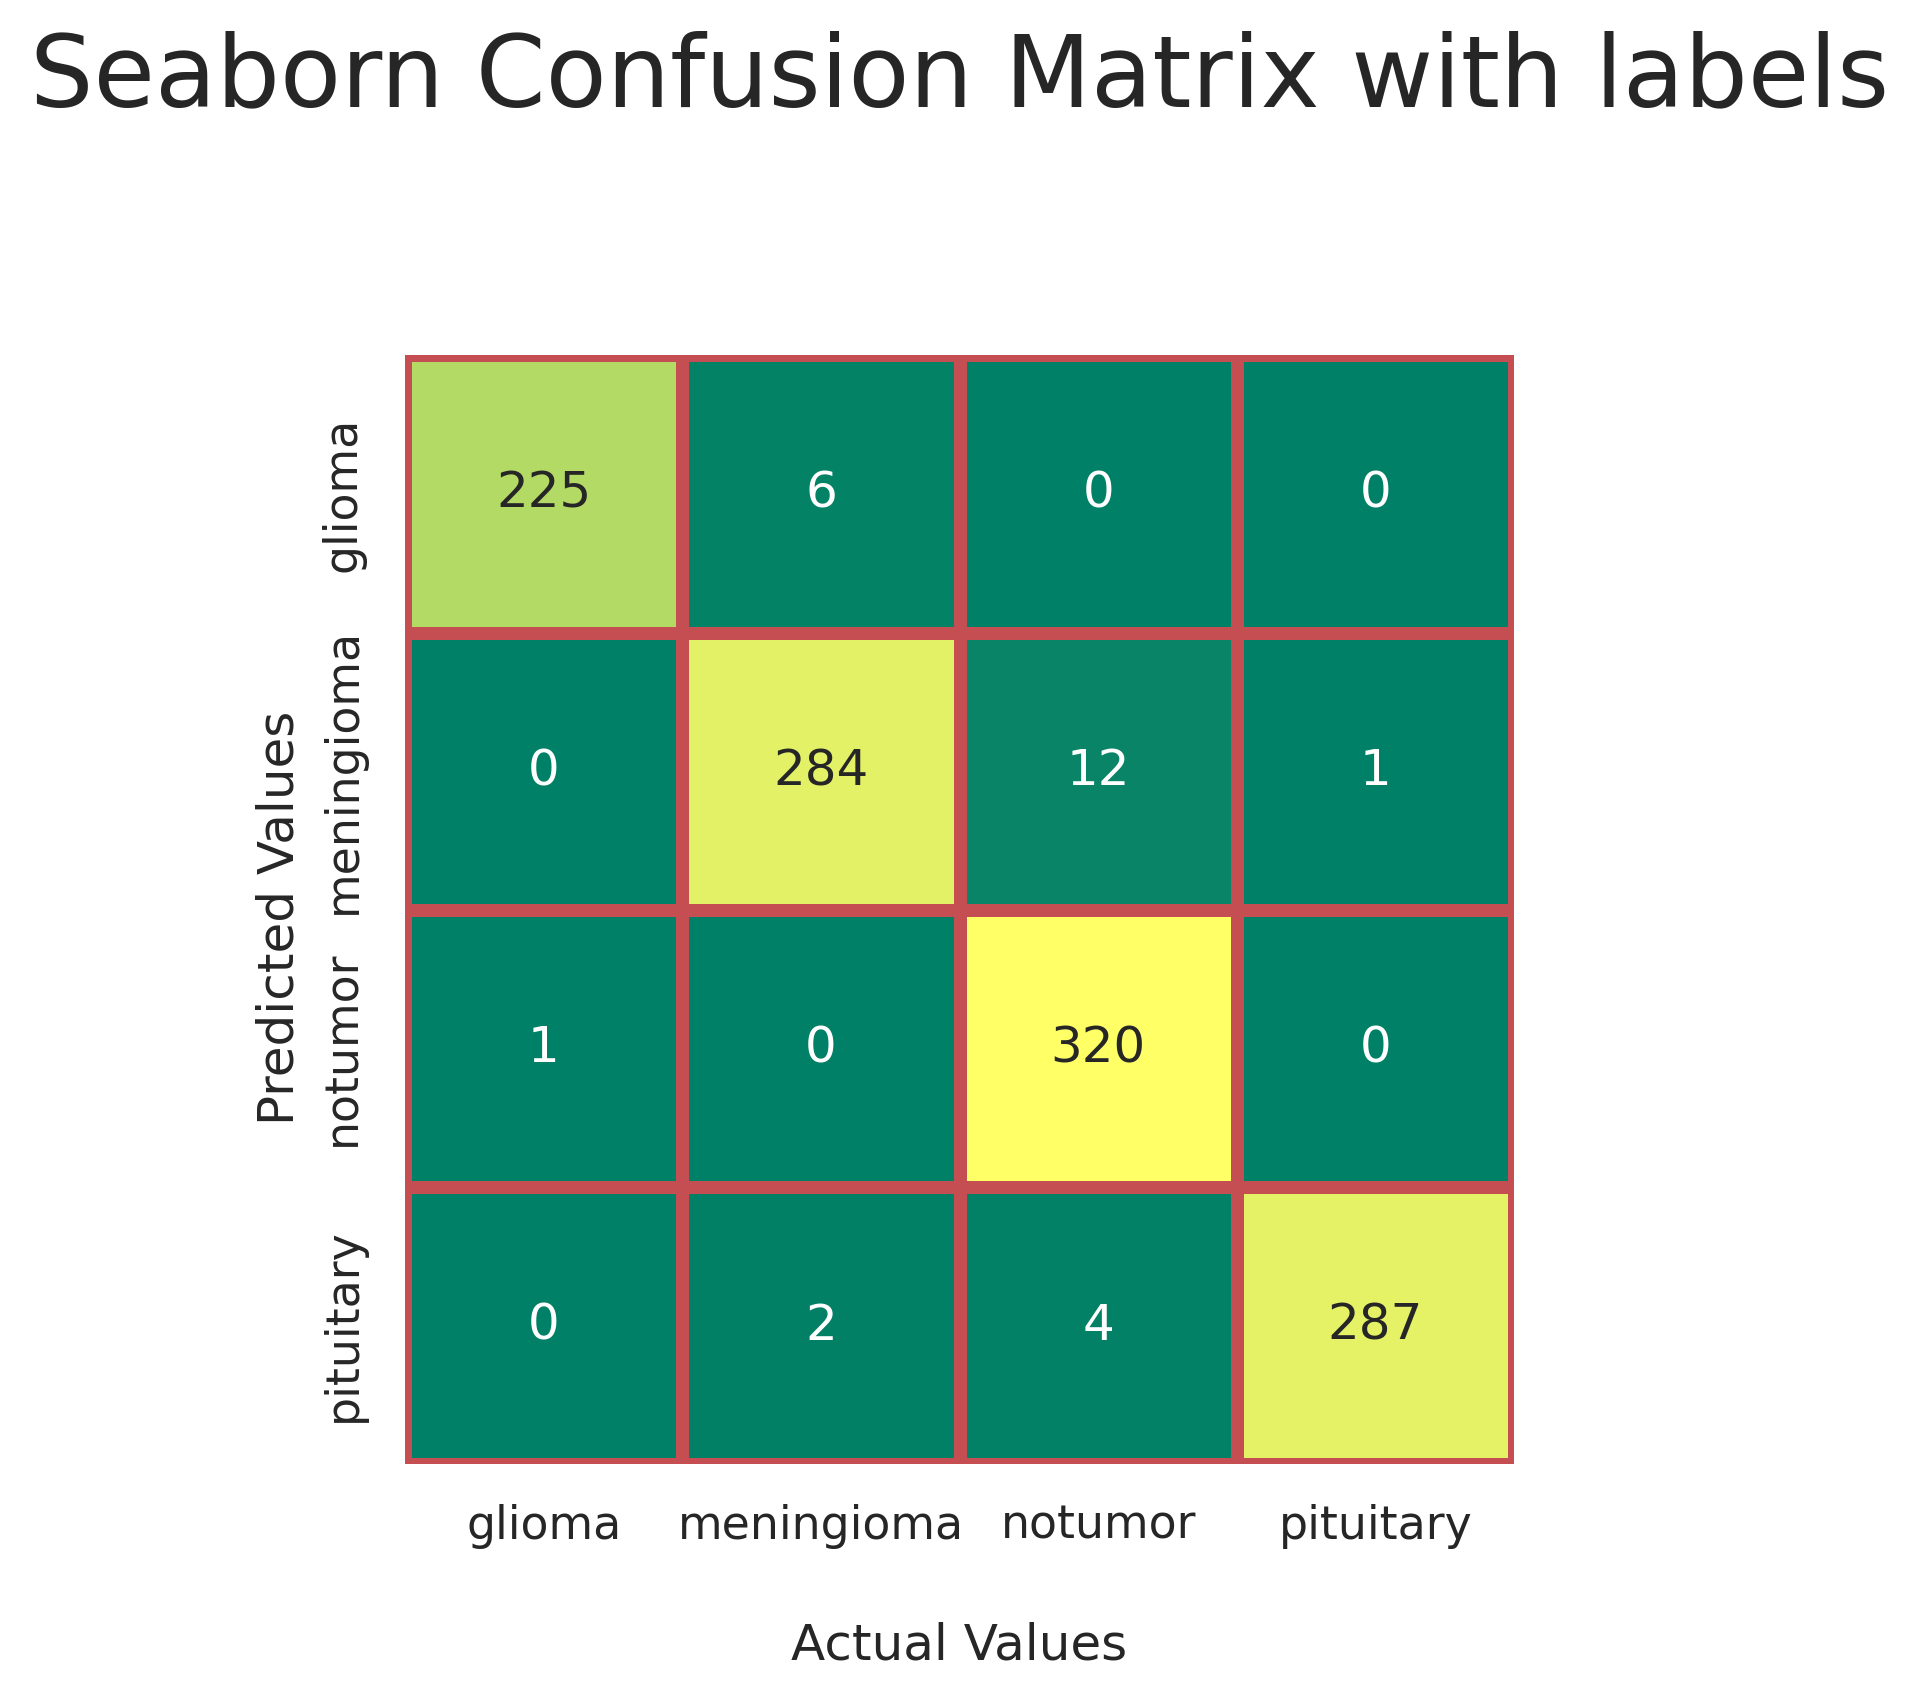

In [89]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#Confution Matrix and Classification Report
import matplotlib.pyplot as plt
Y_pred = ensemble_model.predict_generator(test_ds, 1600)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm=confusion_matrix(test_label, y_pred)
print(cm)
print('Classification Report')
target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
print(classification_report(test_label, y_pred, target_names=target_names))

import seaborn as sns
sns.set(font_scale=1.0)
ax=sns.heatmap(cm, annot=True, cmap='summer', cbar=False, linewidths=3, linecolor='r', square=True, xticklabels=target_names,yticklabels=target_names,fmt='')
#sns.heatmap(cm, annot=True,annot_kws={"size": 22})
sns.set(font_scale = 2.0)
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');